# Key Project Strategy Simulator

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate
import h5py

## Gaia Event Sky Locations

To start off with, let's start by simulating the set of Gaia events that we are likely to detect. 

The code skymap_events.py was previously used to map the events detected in Gaia Data Release 3 by Katarzyna, and convert this into a very rough map of event rate per year per HEALpixel (see code skymap_events.py).  This takes into account Gaia's time sampling, the distributions of stars, events and extinction, and Gaia's restricted limiting magnitude in crowded fields. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [4]:
map_file_path = 'gaia/gaia_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

gaia_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
gaia_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

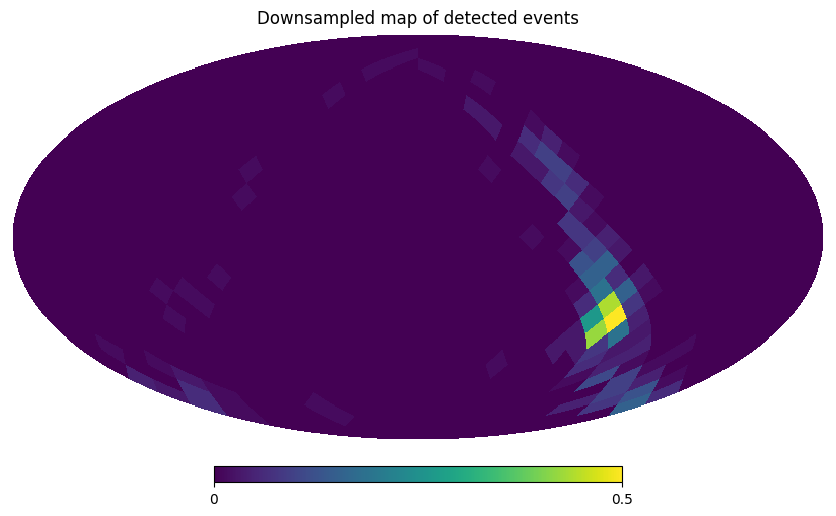

In [5]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(gaia_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [6]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

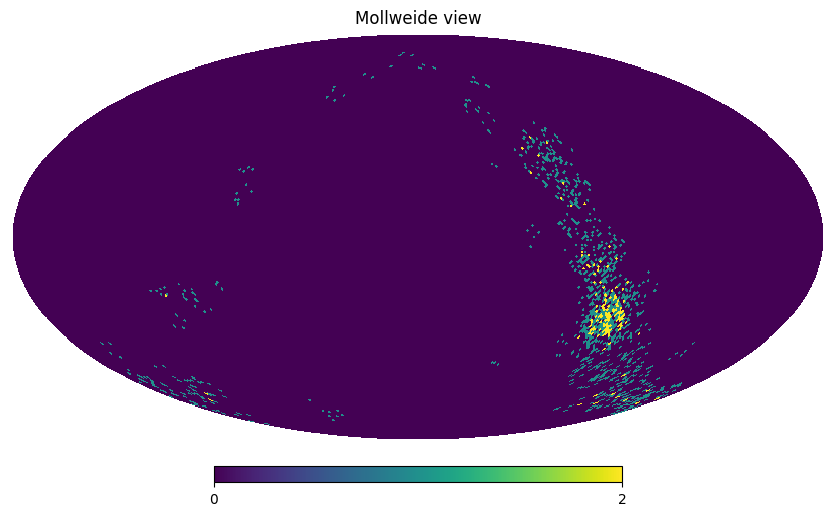

In [7]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = gaia_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (232.875, -60.43443611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (216.29032083, -67.18971944)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (133., -56.63719722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (265.078125, -14.47751111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -40.22818333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (303.75, 39.45089444)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (255.234375, -35.68533333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (211.15384583, -61.189775)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (277.03125, -13.86194722)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (331.44230417, 51.25580556)>"


## Gaia Event Baseline Magnitudes

Next we need to simulate the lightcurve data that Gaia would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by looking at the distribution of historic data from the Gaia Alerts system.  

In [8]:
def str2float(str):
    if len(str) > 0:
        return float(str)
    else:
        return -99.999

In [9]:
file_path = 'gaia/gaia_alerts_data.csv'
file_lines = open(file_path, 'r').readlines()
event_ids = []
data = []
for i,line in enumerate(file_lines):
    if i > 0:
        row = line.replace('\n','').split(',')
        event_ids.append(row[0])
        data.append([str2float(row[2]), str2float(row[3]), str2float(row[5]), str2float(row[6])])
data = np.array(data)

gaia_alert_table = Table([
                            Column(name="Event", data=event_ids, dtype='str'),
                            Column(name="RA", data=data[:,0], dtype='str'),
                            Column(name="Dec", data=data[:,1], dtype='str'),
                            Column(name="mag", data=data[:,2], dtype='float'),
                            Column(name="mag_error", data=data[:,3], dtype='float'),
                            ])
gaia_alert_table

Event,RA,Dec,mag,mag_error
str9,str32,str32,float64,float64
Gaia22epg,19.96019,-53.955,19.83,0.4
Gaia22epf,274.77416,-28.17701,19.55,0.05
Gaia22epe,273.40098,-29.60688,19.3,0.04
Gaia22epd,271.10083,-24.27362,18.34,0.36
Gaia22epc,14.69411,-56.98653,16.86,0.18
Gaia22epb,272.94736,-27.39745,18.11,0.06
...,...,...,...,...
Gaia14aag,219.14335,44.65261,18.42,0.02
Gaia14aaf,244.25381,62.00685,18.06,0.19


Text(0.5, 1.0, 'Distribution of baseline magnitudes of Gaia Alerts')

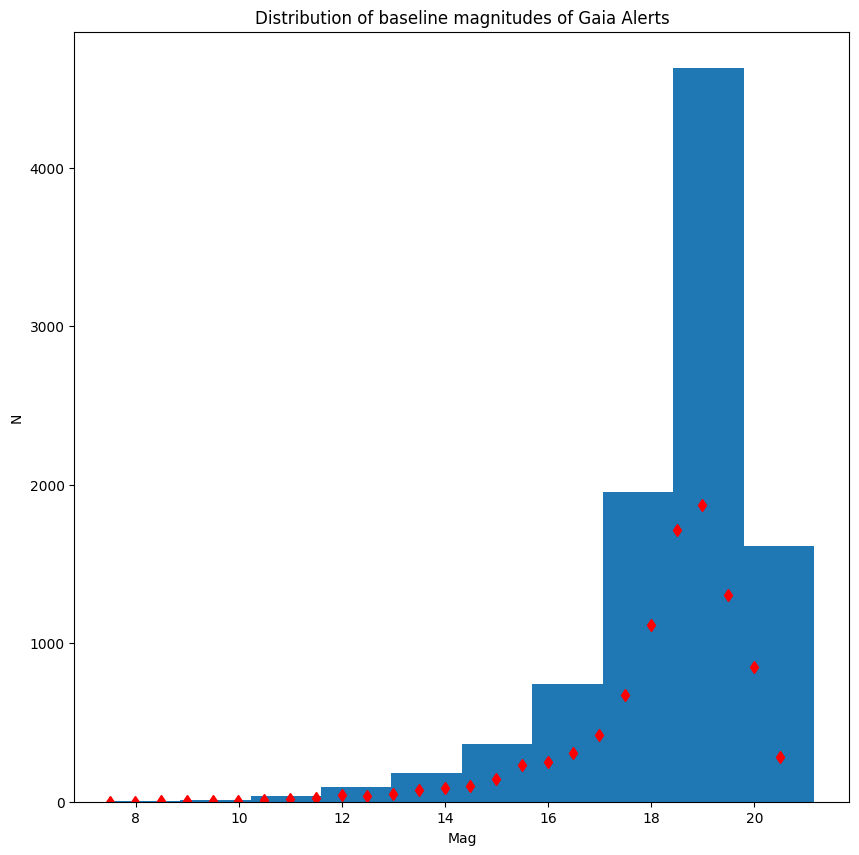

In [10]:
idx = np.where(gaia_alert_table['mag'] > 0.0)
mag_min = gaia_alert_table['mag'][idx].min()
mag_max = gaia_alert_table['mag'][idx].max()
(mag_dist, mag_bins) = np.histogram(gaia_alert_table['mag'][idx], bins=np.arange(mag_min, mag_max, 0.5))


fig = plt.figure(1,(10,10))
plt.hist(gaia_alert_table['mag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of Gaia Alerts')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for Gaia detections

Text(0.5, 1.0, 'Distribution of simulated Gaia detections')

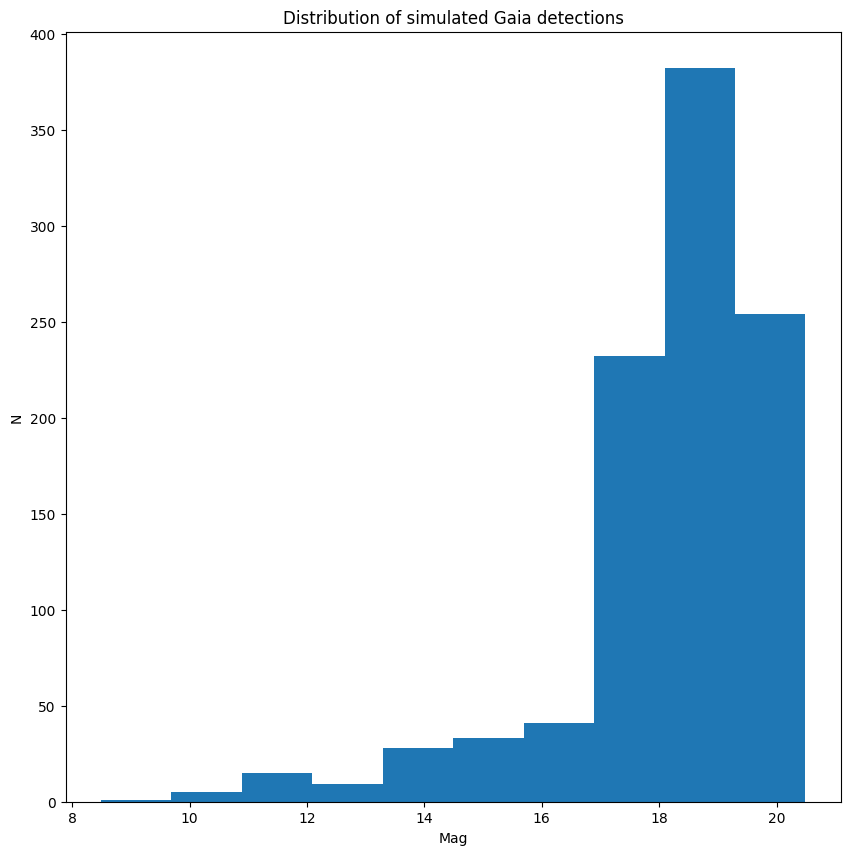

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated Gaia detections')

## Gaia Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [12]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [13]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [14]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

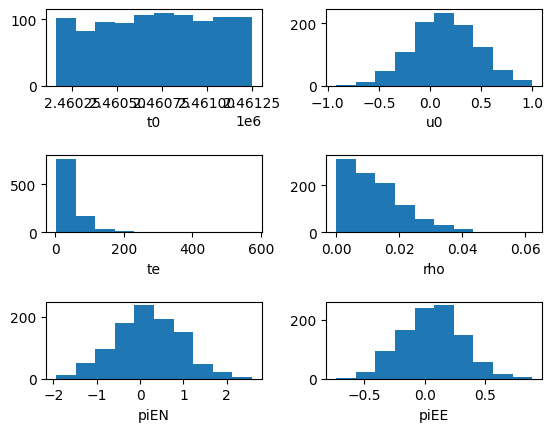

In [15]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

For ease of handling, let's combine these data into a single events table

In [16]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('GaiaSim'+roundID(x))

In [17]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,45975,"<SkyCoord (ICRS): (ra, dec) in deg\n (232.875, -60.43443611)>",19.490000000000002,2461194.63245024,0.4914800586293935,33.19208115112246,0.007540421477433737,-0.09997423446104658,-0.19518178491902569,0.0
GaiaSim00002,47242,"<SkyCoord (ICRS): (ra, dec) in deg\n (216.29032083, -67.18971944)>",18.990000000000002,2461009.0741367224,0.06528635049362055,14.315063629915041,0.0013142122645072906,1.3572451037921032,-0.1046194355171913,0.0
GaiaSim00003,45078,"<SkyCoord (ICRS): (ra, dec) in deg\n (133., -56.63719722)>",18.990000000000002,2460567.9808425503,-0.06383372038511578,3.548444090711342,0.012390464163992799,-0.41569396457354174,0.15684876235697828,0.0
GaiaSim00004,30780,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.078125, -14.47751111)>",19.990000000000002,2460962.8109928155,0.17179298446645896,58.85780210119071,0.013203319420704745,-0.6926592173157229,-0.3786507736347285,0.0
GaiaSim00005,40507,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -40.22818333)>",19.990000000000002,2460655.3747903933,-0.018378213613318428,9.521009393196406,0.007013308264182005,-0.13925015146812242,-0.13129802974516347,0.0
GaiaSim00006,9048,"<SkyCoord (ICRS): (ra, dec) in deg\n (303.75, 39.45089444)>",18.990000000000002,2460373.0962856174,0.5618779989360406,34.87961819658686,0.006197921871334012,0.2596887296528607,-0.06821784575216622,0.0
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,40000,"<SkyCoord (ICRS): (ra, dec) in deg\n (270.703125, -38.68218611)>",16.990000000000002,2460530.3956139633,-0.30123780773832753,9.97141120202945,0.010924112773315448,0.12430000073753023,-0.11273923664812083,0.0
GaiaSim00995,45475,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., -58.16036667)>",19.990000000000002,2460938.0600074525,0.1809334247076661,20.619072640765825,0.003989385894202168,-0.03735829037032967,-0.26234989323067526,0.0


## Gaia Event Lightcurve sampling

In order to generate realistic Gaia lightcurves, we take into account the non-uniform map of visits that results from Gaia's scanning law. We read in this data, which was resampled using the gaia/gaia_scanning_law notebook, and output to file gaia/gaia_dr3_nvisits_34months.fits.  

In [18]:
map_file_path = 'gaia/gaia_dr3_nvisits_34months.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

gaia_nvisits = Table([
                        Column(name="HP", data=data_table['hp_index'], dtype='int'),
                        Column(name="nvisits", data=data_table['nvisits'], dtype='int'),
                        ])
gaia_nvisits

HP,nvisits
int64,int64
1,308
2,315
3,307
4,306
5,324
6,311
...,...
49146,312
49147,322


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [19]:
events_table['nvisits'] = gaia_nvisits['nvisits'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,int64
GaiaSim00001,45975,"<SkyCoord (ICRS): (ra, dec) in deg\n (232.875, -60.43443611)>",19.490000000000002,2461194.63245024,0.4914800586293935,33.19208115112246,0.007540421477433737,-0.09997423446104658,-0.19518178491902569,302
GaiaSim00002,47242,"<SkyCoord (ICRS): (ra, dec) in deg\n (216.29032083, -67.18971944)>",18.990000000000002,2461009.0741367224,0.06528635049362055,14.315063629915041,0.0013142122645072906,1.3572451037921032,-0.1046194355171913,392
GaiaSim00003,45078,"<SkyCoord (ICRS): (ra, dec) in deg\n (133., -56.63719722)>",18.990000000000002,2460567.9808425503,-0.06383372038511578,3.548444090711342,0.012390464163992799,-0.41569396457354174,0.15684876235697828,368
GaiaSim00004,30780,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.078125, -14.47751111)>",19.990000000000002,2460962.8109928155,0.17179298446645896,58.85780210119071,0.013203319420704745,-0.6926592173157229,-0.3786507736347285,351
GaiaSim00005,40507,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -40.22818333)>",19.990000000000002,2460655.3747903933,-0.018378213613318428,9.521009393196406,0.007013308264182005,-0.13925015146812242,-0.13129802974516347,151
GaiaSim00006,9048,"<SkyCoord (ICRS): (ra, dec) in deg\n (303.75, 39.45089444)>",18.990000000000002,2460373.0962856174,0.5618779989360406,34.87961819658686,0.006197921871334012,0.2596887296528607,-0.06821784575216622,298
...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,40000,"<SkyCoord (ICRS): (ra, dec) in deg\n (270.703125, -38.68218611)>",16.990000000000002,2460530.3956139633,-0.30123780773832753,9.97141120202945,0.010924112773315448,0.12430000073753023,-0.11273923664812083,203
GaiaSim00995,45475,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., -58.16036667)>",19.990000000000002,2460938.0600074525,0.1809334247076661,20.619072640765825,0.003989385894202168,-0.03735829037032967,-0.26234989323067526,251


Store the table of simulated event parameters

In [125]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_events_table.fits', overwrite=True)


## Gaia Event Lightcurves

Now we can simulate the lightcurves that Gaia would produce for these simulated events.  Although the scanning law data does not tell us the distribution of visits over the 34 months included in Gaia DR3, it is a regularly repeating function with a non-varying scan from a space-based facility.  The sampling isn't uniform, but we approximate it here as uniform, since experiments with the Gaia scanninglaw package failed due to out of date documentation.  

In [20]:
def add_gaia_g_noise(mag):
    """Code by Markus Hundertmark
    """
    a1 = 0.2
    b1 = -5.3 #-5.2
    a2=0.2625
    b2= -6.3625 #-6.2625

    mag_obs_list = []
    magerr_list = []

    for value in mag:
        log_err1 = a1*value + b1
        log_err2 = a2*value + b2
        if (value < 13.5):
            magerr = 10**(a1*13.5+b1)
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if value>=13.5 and value<17:
            magerr = 10**log_err1
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if (value>=17):
            magerr = 10**log_err2
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        #this works until 21 mag.
    return np.array(mag_obs_list), np.array(magerr_list)

In [169]:
def simulate_event_gaia(event_params, start_date, end_date, horizons_table, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps
    cadence = (end_date - start_date) / event_params['nvisits']
    timestamps = np.arange(start_date, end_date, cadence)
    
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude, with fixed photometric uncertainties, 
    # since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel.spacecraft_positions = spacecraft_positions
    
    sim_event.telescopes.append(tel)
    sim_event.find_survey('Gaia')
    
    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]
        
    sim_model.define_model_parameters()
    
    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
    tel = sim_model.event.telescopes[0]
    
    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    #print(event_params)
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
    (lightcurve[:,1],lightcurve[:,2]) = add_gaia_g_noise(lightcurve[:,1])
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
    
    return sim_event, sim_model, lensing_parameters

In order to implement parallax for Gaia events, we use the projected vector locations of the spacecraft, as generated by JPL Horizons, and output to an ASCII table which can be read from file.  
The JPL Horizons configuration used to generate this table is:
* Ephemeris type: Vector table
* Target body: Gaia (spacecraft)
* Coordinate center: Solar System Barycenter SSB [500@0]
* Time: 2023-01-01 to 2026-08-30, increments of 1 day (duration of Key Project)
* Table settings: default

However, this appears not to be the format required to calculate the observed location of the spacecraft.  Instead it needs the RA, Dec position, meaning that the observer table format is required, with the following options:
* Astrometric RA & Dec
* Rates RA & Dec
* Airmass and extinction (required)
* Visual mag & surface brightness
* Heliocentric range and range rate
* Observer range and range rate
* Sun-Observer-Target ELONG angle
* Sun-Target-Observer PHASE angle
* Local apparent hour angle
* Sky motion
* Lunar sky brightness

In [170]:
gaia_vector_table_file = './gaia/jplhorizons_observer_table.txt'

horizons_table = jplhorizons_utils.parse_JPL_Horizons_table(horizons_file_path=gaia_vector_table_file, 
                                                                   table_type='OBSERVER')
horizons_table

Date,RA,Dec,Delta,JD
bytes16,float64,float64,float64,float64
2023-Jan-01T00:0,101.31470833333333,22.988694444444445,0.99424530711027,2459945.5
2023-Jan-02T00:0,102.41991666666667,22.90411111111111,0.99437003596059,2459946.5
2023-Jan-03T00:0,103.52370833333335,22.811972222222224,0.99450009481111,2459947.5
2023-Jan-04T00:0,104.625875,22.712305555555556,0.9946354327103,2459948.5
2023-Jan-05T00:0,105.72629166666665,22.605194444444447,0.99477599538272,2459949.5
2023-Jan-06T00:0,106.82491666666667,22.49063888888889,0.99492172842485,2459950.5
...,...,...,...,...
2026-Aug-22T00:0,330.5357916666667,-12.060194444444445,1.02354688405442,2461274.5
2026-Aug-23T00:0,331.45425,-11.725111111111111,1.02327762396697,2461275.5


In [171]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

gaia_lens, gaia_lens_model, lens_model_pars = simulate_event_gaia(events_table[event_number], start_date, end_date, horizons_table, parallax=True)

Picked bright event:  6  baseline_mag= 15.49 mag
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.487204771651504


Simulate all events

In [246]:
sim_gaia_lenses = []
sim_gaia_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (gaia_lens, gaia_lens_model, lens_model_pars) = simulate_event_gaia(events_table[ievent], start_date, end_date, horizons_table, parallax=True)
    sim_gaia_lenses.append(gaia_lens)
    sim_gaia_lens_models.append(gaia_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.474353284951974
0 [2461194.63245024, 0.4914800586293935, 33.19208115112246, 0.007540421477433737, -0.09997423446104658, -0.19518178491902569]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.99267249589666
1 [2461009.0741367224, 0.06528635049362055, 14.315063629915041, 0.0013142122645072906, 1.3572451037921032, -0.1046194355171913]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.990920963195034
2 [2460567.9808425503, -0.06383372038511578, 3.548444090711342, 0.012390464163992799, -0.41569396457354174, 0.15684876235697828]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.962959010578423
3 [2460962.8109928155, 0.17179298446645896, 58.85780210119071, 0.013203319420704745, -

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96459799652593
38 [2461033.407199768, 0.4728678781799962, 86.7709105722814, 0.012737583298574214, 1.026398408909832, 0.5005941422105549]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.969888826752467
39 [2460257.559736424, -0.19973259653906753, 33.51098874549254, 0.004014735147017473, 1.4809095890125508, 0.13229502428396048]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48911360030148
40 [2461117.5345906685, -0.42076433886289244, 16.005830701333373, 0.010350678449212322, 1.376190170839114, -0.01932460340297385]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.483452210431988
41 [2461086.396628747, -0.09751231229667418, 25.97473892041373, 0.01586875195240684, -0.2804120218831518, -0.2942437378310923]
15.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.134561924912997
84 [2460589.5664022663, 0.26380475628065114, 498.5490720554182, 0.013183193761031178, 0.7692332816087095, 0.08921960286168559]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97641781572571
85 [2460970.919477911, -0.11242736447773169, 34.438812273786475, 0.028698121391775536, -0.2591488391782448, 0.29114589798659535]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.482059169247712
86 [2460554.7373506078, 0.0909740057374655, 45.67583959571058, 0.0128567297851167, -0.09345486966818278, -0.07444528178909005]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48740618890376
87 [2460994.5296901693, 0.1632985707023057, 11.561801164202189, 0.028167837812086212, -0.8717656451957452, 0.5523323148760085

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.490567501578472
128 [2461007.4842661833, 0.1726140444198584, 7.667105684069566, 0.004488128195807956, -0.24905535927659223, 0.15290061294722113]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978777348694305
129 [2460406.6705274647, 0.11113337480704522, 29.945885258049724, 0.01866504994994519, 0.22378742499307447, -0.727095655159328]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98564972516671
130 [2460853.9516191664, 0.0877063447045607, 44.759622991961216, 0.0074536050855185335, -0.20231935690912195, 0.14375232284995346]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.488501800230807
131 [2460565.6241639014, 0.07506623156994936, 8.242661185996962, 0.013121787488620059, -0.3746368656212525, 0.2527661604256212]
19.4

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.48682859295436
171 [2460621.3018203294, 0.4420035089938703, 18.57675797741928, 0.022440000754074214, -0.911369826160839, -0.055429779922517596]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978474358528178
172 [2460387.239305484, -0.040130966708521565, 49.10085765121558, 0.016878390591711506, 1.8166572691671892, 0.3620731315959235]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98384799594143
173 [2460747.3057682654, 0.49949889899857536, 20.353009581417364, 0.00175960691453385, 0.453172164260721, 0.36997275954088604]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.967451717647116
174 [2460294.031384693, 0.05344973458314142, 176.82585390889477, 0.008310474530787466, -0.4942517929262758, 0.09933685112275

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.986479037457364
204 [2461140.1638272284, -0.28579906436537983, 18.109844474219173, 0.011076107279242338, 0.6657972527525693, 0.15202996255174706]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.472116019777793
205 [2461150.8056203234, 0.33431787104600785, 48.782267819680875, 0.00552173671200438, 0.06519032872506943, 0.2549967927279834]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.96562806974458
206 [2460662.5650364663, -0.13754458946426915, 42.14493773891496, 0.009298795771463352, 1.177114260335572, 0.302521186325172]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.995603596351295
207 [2461097.4173443904, 0.07076230766039332, 4.934054504838126, 0.019448719200893402, -0.48853783196831396, 0.353756169460

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.485563709240783
250 [2460377.5246116, -0.5472615398477231, 23.913407913854453, 0.009040555046019446, 0.3402340850691845, 0.1385693239200672]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.963109003891105
251 [2460531.0658632377, 0.11554683040263743, 117.8062631010705, 0.006517966483861269, 0.042281646802391507, 0.21662721248137803]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.988324611905124
252 [2460902.7798804953, -0.0844416923890765, 14.872413243309962, 0.013994918911984932, -0.5171928835687332, 0.37257643550899483]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48663257229903
253 [2460548.250063709, -0.21341182604134493, 22.735307786076152, 0.015647923623213888, 0.08130356565213519, 0.23850137659

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.45896804147842
296 [2460207.932260419, 0.13172892119175925, 81.11667537066383, 0.0258095601520021, 0.2790802366358592, 0.215267946699218]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96646350494382
297 [2460841.646072953, 0.32954521942125875, 60.88271208546177, 0.00555727393522272, 0.35040573137658193, 0.10631322420005104]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.46840015807409
298 [2460286.406376199, -0.22699732564677153, 103.26053522457875, 0.01780097506670103, 0.13110545478742927, -0.23535826487982556]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48015083720089
299 [2460294.158447718, 0.07989770225387609, 32.147951805928685, 0.017626207774452958, 0.39725722681229736, 0.3551142255815684]
17

Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.989147825122984
342 [2460590.1180391964, 0.1118258444278136, 11.928193797410918, 0.03487949752492707, -0.05682330473867511, 0.13908965395461706]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.98183783134578
343 [2460954.988303162, 0.9625535695354868, 40.50997192589251, 0.025897325350565464, -0.035920926467974235, 0.16455636119188674]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.968593024697093
344 [2460847.3497638344, 0.24253311252084025, 58.60665878728624, 0.010203709857685149, 0.3694861718557463, 0.04428870450886957]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.99186248092803
345 [2461096.59760288, -0.04539382633881939, 14.64488569173364, 0.018115808932001057, 0.6180459094541161, -0.29165709787075667]
19.9900

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98652081550053
374 [2460812.3321639486, -0.28223381366462075, 9.080813502146665, 0.0012493013908845968, -0.6888864047033914, 0.0813109902487544]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.988195483811264
375 [2460384.5509479493, 0.2825846815232451, 9.702546290125413, 0.015080570085609854, 0.9848457340233063, -0.08702365130583486]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47580036474868
376 [2461075.2930938946, -0.2936877456530491, 32.38304289858195, 0.0028174440589180463, 0.08418607801031427, -0.10605612392998448]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.983436933293092
377 [2461089.10251204, -0.3172558947446198, 23.054386677109882, 0.005744109073004062, 0.07975007026324625, 0.0977381703

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.485740119498562
407 [2460874.972630997, -0.23078995896843044, 19.292153516235835, 0.01886767837386865, 1.14314472600946, 0.3172517177597112]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.478635021569797
408 [2460986.9528160323, 0.30683697708600044, 43.53478247870269, 0.00733039739116893, -0.3081693472206115, -0.4877045417824872]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.479762411385586
409 [2460829.7816095673, 0.1768688349052959, 37.35299067487173, 0.011816983250784561, -0.4860801301877424, -0.05083572745539771]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.92570919684183
410 [2460538.532147368, 0.11333278157107815, 217.19456529218814, 0.032317312121281236, 0.41848149550720937, 0.306241917191435

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.429662651615914
454 [2460711.963660346, -0.009157444454887725, 198.4382730519247, 0.022147286254816812, -0.40235457094833255, -0.1380166243865656]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.945709431378056
455 [2460807.6815535454, 0.45387260078074343, 74.8081588558564, 0.025349935683576102, 0.2722855650697247, -0.06537674402965327]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.480916921783848
456 [2460486.9569527777, 0.350469283582706, 80.95319438230148, 0.015729149997144802, -0.7233029411164831, 0.014060235722670563]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484366363451635
457 [2461010.3265573354, -0.2480665196975382, 37.136429910593336, 0.012346072637414489, -1.4343853671080529, 0.10167860

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.965632767237306
498 [2461159.2327781473, 0.7315028252790307, 89.31377572462547, 0.01074620800214928, -0.5704039545939719, -0.16691699863012616]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.487678265915953
499 [2460163.9311824404, 0.20141495848775315, 22.326070230841363, 0.043692654854532546, 1.5461613179625737, 0.2609769490376034]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.476309360484706
500 [2460396.26925565, -0.26481244690657246, 27.75257204412286, 0.016931293202666155, 0.05036730629698881, -0.15306537259215644]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47078191799455
501 [2460629.7503747474, 0.22920516209380232, 79.70237151763862, 0.0019593039199517197, -0.9247264828732973, 0.31129542940

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.483422051852642
547 [2461091.5776310815, 0.3897369998690966, 62.69539558734452, 0.01393359308517332, 0.3575063909934587, 0.11373238468541219]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.943309523535852
548 [2461216.6144948825, 0.18057531602356022, 135.16398786230147, 0.004751067936391332, 0.05727320705104784, 0.13175942836862797]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48170255542801
549 [2460612.5709796175, -0.13039095987906693, 35.691405451445036, 0.005223460371995928, 0.5219461049281019, -0.22465544476943297]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.979047577488632
550 [2460221.4199549807, 0.6269721841929895, 44.46191109990289, 0.02056274436167619, -0.15880281954511594, 0.26806276801049317]
13.99

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.487786764124117
593 [2460681.098082312, -0.06582938361401222, 5.426962962181301, 0.0002882415644705535, 1.3074444662036389, 0.019436657380852405]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.480511658696955
594 [2460632.5056417594, 0.56419187295177, 21.39252692284625, 0.0023968995472193905, 1.0515593168208868, -0.1711046999303067]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.476167702297644
595 [2461050.357697958, -0.22643104636042685, 21.152958423209935, 0.018197103415926445, 1.1597684304463283, -0.005463606778652208]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.983474092644343
596 [2460913.633273047, -0.12458098699095974, 20.725566327747845, 0.0037788567285616196, 1.8684232381275618, 0.19797904

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.973475204639605
636 [2460900.8425935335, 0.1722701266942555, 75.34986214983745, 0.004725543988046144, -0.4116544449772637, -0.12210646824253521]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.450496327847596
637 [2460801.034613569, 0.6968626486321831, 79.71943080742867, 0.009987139502422878, 0.26499002127254756, -0.020989931199141366]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.984181594244763
638 [2460416.08323994, 0.6303135115621068, 29.08155204741573, 0.002147391042356398, 0.1671398259520034, 0.16719516131898954]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.98277866856737
639 [2461200.1110221357, 0.12911723921132556, 82.32641352442812, 0.021470451119009963, -1.3201340544574338, -0.1715948464972

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.983892109652782
678 [2460376.9953185357, 0.2267290956010048, 24.272332309061795, 0.011553184043130828, -1.5306691421490604, 0.006472081187026822]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.469840498100236
679 [2460538.9451699946, 0.24720898876237615, 70.46691374369979, 0.0038522933471993558, 0.6682454706620926, 0.16712332912809447]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48149219172521
680 [2460774.1455612816, 0.3723291398114855, 27.689611575502102, 0.01703691719443083, 0.5061900037892524, 0.1346819876719995]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.981257141355854
681 [2460785.200189881, -0.2823205848565531, 29.483502653558897, 0.009581144195524308, 0.07571972376446405, -0.11304340696

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.479272777830232
718 [2461091.0452555534, -0.03585357745766393, 67.63522054060077, 0.0176661776215431, -0.6619615322937449, -0.22899839495357618]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97774401278524
719 [2460280.77910265, 0.02279887120262486, 8.275301004010224, 0.0024492698114017327, 0.96476791139567, -0.31871125519243504]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.486251070107915
720 [2460653.086244696, 0.24183570116877084, 9.54209779777536, 0.004119244906852995, -1.1803482251970792, 0.1373662958087955]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.414737212141524
721 [2460618.328981259, -0.041438186820445644, 99.08487557543393, 0.020188271966758008, -0.4693039184255838, -0.16486056075910

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.492156836926068
761 [2461127.660966532, 0.5521544850297379, 3.934696243132993, 0.017611468455560688, 1.4514804634768335, 0.048341405029236305]
13.49 13.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.48886851975587
762 [2461142.0525870803, 0.2267448204637707, 34.56533338120635, 0.0137658770163674, 0.021446484036722613, 0.020099297950302113]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.97782583947302
763 [2460530.5278525418, 0.30135851807180913, 172.11713139399316, 0.008508241487953387, 1.062293787706536, 0.23922544586442662]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.481879966154494
764 [2461121.6326245386, -0.07056744613320792, 13.128035230066295, 0.012268378640590792, 0.5017545564474322, 0.03186941007952815]
18.490000000000002 18.490000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.481221918667103
805 [2460748.1800075667, 0.06225422337031747, 32.939818903252714, 0.024030798679641356, 0.7982012982572861, 0.14552898631141192]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48381709483438
806 [2460165.080034098, -0.10617141402492061, 39.989830186642, 0.0029497615949850616, -0.6364865897665897, 0.18843125156552448]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48610995076014
807 [2460960.735560712, -0.021370539822254425, 11.418029947645818, 0.01401516527585486, -0.32617653258099827, -0.12964375134524958]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.98787641871372
808 [2460606.176162814, 0.5541591507950699, 24.15973145489514, 0.011658080011022531, -1.2130119761243572, 0.49562394345411337]
18.990000000000002 18.9900000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47868846047676
853 [2460424.695647917, 0.45101728042504896, 29.434394192990354, 0.005774620974067909, 0.4234236923656757, 0.14761382732167092]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.456615704709414
854 [2460961.6388770784, 0.01392517377496405, 51.35784502801944, 0.030612096814853156, -0.06663233872712615, -0.34420296967303765]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.980021168339874
855 [2460687.9336901633, 0.17491583832150392, 36.35725889564009, 0.02090665566835809, 0.8120376485538829, 0.04001034309323868]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.474473810357026
856 [2460794.976878034, -0.37634478373706814, 104.1852519504571, 0.014017475100134832, 1.9414049885205182, 0.053250198027

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.979157333173674
895 [2460901.1154638366, -0.05747227171763805, 40.893657121612655, 0.008368679193545801, -1.172266184610058, 0.25104241909585123]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978891242068475
896 [2460830.1998419417, 0.11703442076374752, 17.365753553553855, 0.005762216953668759, -1.0923977810532197, -0.24288364166607926]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.4807043525303
897 [2460776.8866709075, 0.3190542982446142, 19.040931039268425, 0.012224538445336344, -1.0236787619527996, 0.05302619897871121]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.485211910871392
898 [2461113.1609181864, 0.08972110236944507, 14.269203302475397, 0.009798536675676739, 0.12529380994074568, 0.2678875

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.48531945334292
939 [2461219.225036059, 0.05611242630343752, 9.876555861076483, 0.0010642818793406249, 0.19484254290787423, -0.07850114138713782]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47512291254353
940 [2460836.2444847682, 0.40417573269825924, 52.889806508367336, 0.012719286063530061, 0.527762352512638, 0.12574034292037337]
13.99 13.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.989552827105204
941 [2460214.096645816, 0.0718595413353848, 14.312966927402877, 0.017087455053394263, -0.34343205228376644, 0.0846364963973103]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.489683502849413
942 [2460625.2837196654, 0.20273996095908556, 10.129469169230466, 0.014532811399586862, -0.7444625217540046, 0.2749599808894762]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.486599722567092
983 [2461232.410858586, 0.003927299934114004, 11.914028374572242, 0.010329981222690467, 0.21026889880713093, 0.3434582923469284]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.98871085456789
984 [2460598.5306903142, 0.5369842575895004, 24.126522389649207, 0.017633952540192767, 1.6110014061111746, -0.025584594245438873]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.476601644500533
985 [2460864.7450739723, 0.4741726333054872, 65.53377392169502, 0.01829610343884222, 1.052874940956442, -0.15024677763325003]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.489074774636205
986 [2460398.5669348524, 0.1294052122413138, 15.068151291985947, 0.006622798673171584, -0.13651157312424472, 0.24277226839

Store the simulated Gaia lightcurves

In [247]:
file_path = 'simulated_gaia_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_gaia_lenses),1):
        lc = sim_gaia_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

Plot an example event

  EventID      HP                                location                              baseline_mag         t0                  u0                 te                 rho                piEN               piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------ ------------------ ------------------- ------------------ ------------------- ------------------ ------------------ -------
GaiaSim00007 38965 <SkyCoord (ICRS): (ra, dec) in deg\n    (255.234375, -35.68533333)>        15.49 2460471.6818540716 0.41440980957788087 57.091538539600656 0.01228782328645692 1.0832679589828285 0.3421087311264171     252


Text(0.5, 1.0, 'Simulated event GaiaSim00007')

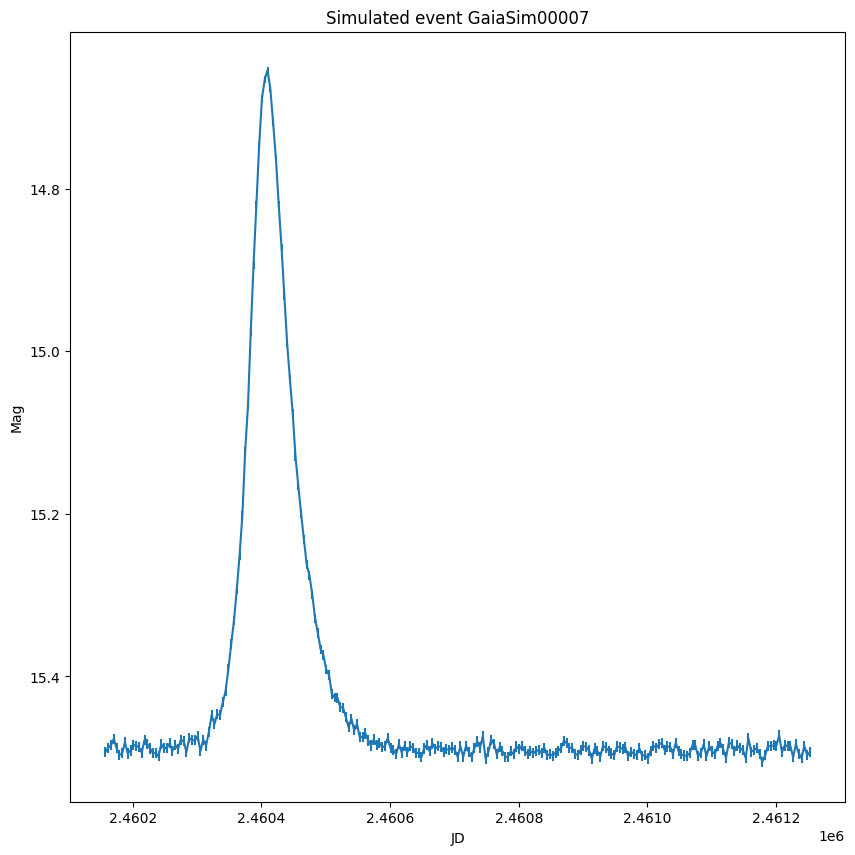

In [248]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_gaia_lenses[event_number].telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
#xmin = float(events_table[event_number]['t0']) - 2*float(events_table[event_number]['te'])
#xmax = float(events_table[event_number]['t0']) + 2*float(events_table[event_number]['te'])
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [249]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

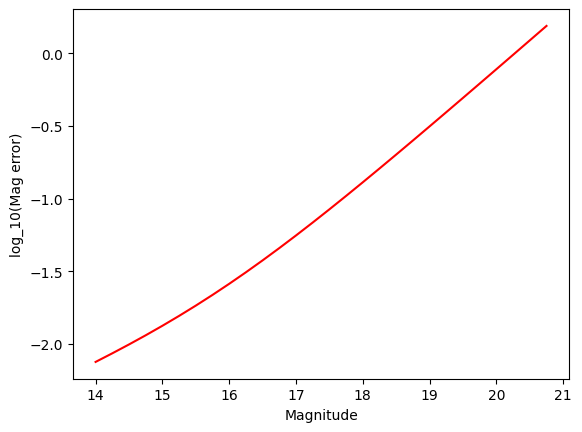

In [250]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [251]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [252]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [253]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Gaia events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [254]:
def simulate_lco_observations(gaia_event, gaia_model, gaia_model_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    gaia_lc = gaia_lens.telescopes[0].lightcurve_magnitude
    if len(gaia_lc) == 0:
        return gaia_event
    
    mag_threshold = 17.5
    bright_data = np.where(gaia_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(gaia_lc[:,1].min())+' no LCO observations')
        return gaia_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = gaia_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = gaia_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(gaia_event.ra, gaia_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = gaia_lc[:,0].min()
    end_jd = gaia_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (gaia_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = gaia_lc[idx,0].min()
            pre_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = gaia_lc[:,0].min()
            pre_peak_end = gaia_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = gaia_lc[idx,0].min()
            post_peak_end = gaia_lc[idx,0].max()
            cadence = 1.0 # days
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = gaia_lc[:,0].max()
            post_peak_end = gaia_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        ts = np.concatenate((ts1,ts2,ts3))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return gaia_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for Gaia
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(gaia_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    gaia_event.telescopes.append(tel)
    
    if parallax:
        gaia_model.event.compute_parallax_all_telescopes(gaia_model.parallax_model)
        
    tel = gaia_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = gaia_model.compute_pyLIMA_parameters(gaia_model_params)
    magnification = gaia_model.model_magnification(tel, pylima_parameters)
    A = gaia_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)
    lc = np.delete(lc, idx, axis=0)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    gaia_event.telescopes[1] = tel
    
    return gaia_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [255]:
gaia_lens = sim_gaia_lenses[event_number]
gaia_lens_model = sim_gaia_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, visibility_data)

Event model parameters:  2460471.6818540716 0.41440980957788087 57.091538539600656 0.01228782328645692 1.0832679589828285 0.3421087311264171
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                                location                              baseline_mag         t0                  u0                 te                 rho                piEN               piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------ ------------------ ------------------- ------------------ ------------------- ------------------ ------------------ -------
GaiaSim00007 38965 <SkyCoord (ICRS): (ra, dec) in deg\n    (255.234375, -35.68533333)>        15.49 2460471.6818540716 0.41440980957788087 57.091538539600656 0.01228782328645692 1.0832679589828285 0.3421087311264171     252


Text(0.5, 1.0, 'Simulated event GaiaSim00007')

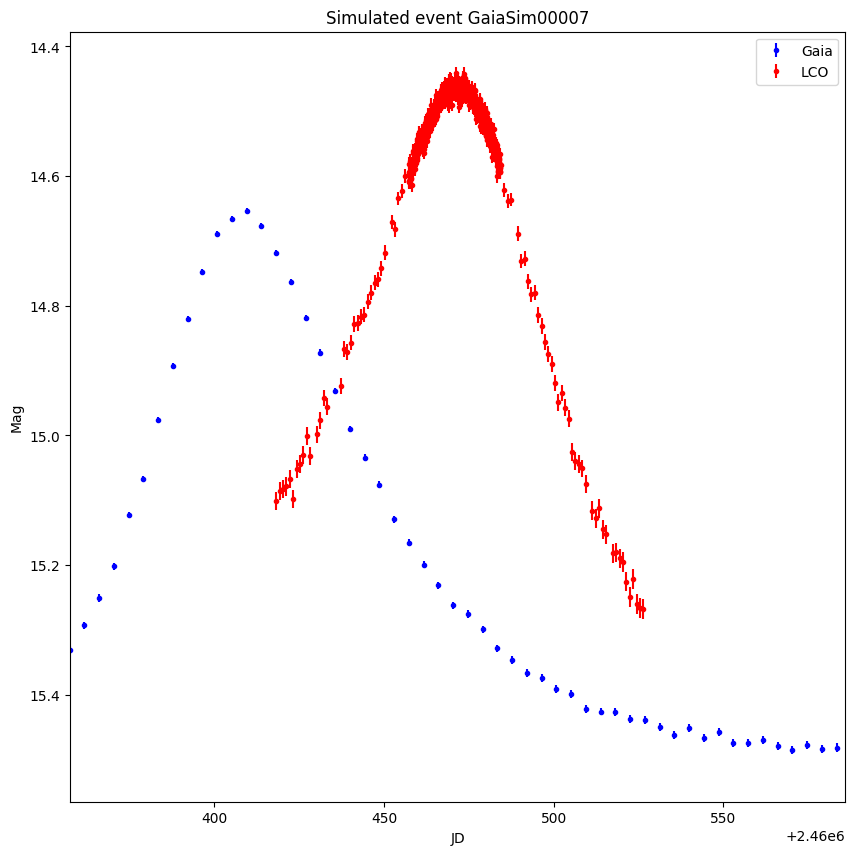

In [256]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated Gaia events

In [257]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_gaia_event = simulate_lco_observations(sim_gaia_lenses[ievent], 
                                                   sim_gaia_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   visibility_data)
    simulated_events_list.append(updated_gaia_event)

Event model parameters:  2461194.63245024 0.4914800586293935 33.19208115112246 0.007540421477433737 -0.09997423446104658 -0.19518178491902569
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461009.0741367224 0.06528635049362055 14.315063629915041 0.0013142122645072906 1.3572451037921032 -0.1046194355171913
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460567.9808425503 -0.06383372038511578 3.548444090711342 0.012390464163992799 -0.41569396457354174 0.15684876235697828
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460962.8109928155 0.17179298446645896 58.85780210119071 0.013203319420704745 -0.6926592173157229 -0.3786507736347285
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460655.3747903933 -0.018378213613318428 9.521009393196406 0.007013308264182005 -0.13925015146812242 -0.13129802974516347
No viable times for LCO observations
Event model parame

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460249.8772793696 1.0 82.48142858307475 0.01841109355318455 -0.8119552023057703 0.0672430382858047
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460997.4373502173 -0.3574803070163243 25.191909183496257 0.006558078768067441 0.403865224286953 0.3119515148223948
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460692.9841551096 0.4929096313617828 6.718410749125392 0.0033045395325232273 0.4700907569775422 -0.3231314090747877
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460208.0357336057 0.5668707644666311 65.14513914431457 0.021742259237674765 0.15402516374101774 0.17433233083206998
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460788.1261692396 -0.06118034567333225 7.852300386362744 0.007473918961878371 -0.012237686364704098 0.44427215197783093
Parallax(Full) estimated

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460554.7373506078 0.0909740057374655 45.67583959571058 0.0128567297851167 -0.09345486966818278 -0.07444528178909005
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460994.5296901693 0.1632985707023057 11.561801164202189 0.028167837812086212 -0.8717656451957452 0.5523323148760085
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461019.7996765827 0.9223730619920713 48.465634419091295 0.011204431558984965 -0.5438625961965209 0.13236074398821865
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460891.0513917557 0.014101121029342495 77.31541142003302 0.013606983086053414 2.0485840655725593 0.12424646610372822
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460329.9988477337 0.10251104562083718 9.672990621349168 0.013088234764993614 0.7311786146573371 -0.1608638377701843
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460853.9516191664 0.0877063447045607 44.759622991961216 0.0074536050855185335 -0.20231935690912195 0.14375232284995346
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460565.6241639014 0.07506623156994936 8.242661185996962 0.013121787488620059 -0.3746368656212525 0.2527661604256212
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460531.6641981946 0.15078247598709765 60.948725031618466 0.023628408941364094 0.28609458334418947 0.1948611732476873
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460203.319519765 -0.39619076850967727 49.19230210576728 0.004477286430450216 0.06941167485735926 0.23446414567375856
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461192.5924605075 0.13843759156856097 52.05034778434631 0.01828582285664617 0.9885972621921866 0.10488146341652728
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460448.7312741023 0.3696304389159949 37.82536756396081 0.0003671087403415117 -0.03065073298725371 0.1831470495236167
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460542.4326791195 -0.37795658867598003 24.025519198661325 0.005403682508805085 0.5438152801022869 0.024229280712355236
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461070.1292608795 0.5361885310236356 23.739462859207208 0.013565702454036373 0.500806263005257 0.10981504634829381
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460605.5013955836 0.11678112141911433 200.47580033197428 0.0014256639015614763 0.7739651755427519 0.399995264545447
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461166.669724793 -0.7170992896699324 61.02757460414775 0.02819585328276024 1.1591887392612308 0.35297345308674244
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460901.8075762377 -0.08870197026451687 5.073226452624213 0.01358776894079957 0.22513180790476278 -0.19327128969985705
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460763.901772753 -0.24388647552607698 4.845202658128159 0.007648436232473155 -0.25388099308412876 0.20369182840786354
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461183.2814301266 -0.258463266383159 15.82687497048565 0.00884425155287766 -0.9818087962853101 0.34683943397198475
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460489.0162798245 0.48095274933376464 17.069627099052244 0.01666471698697389 0.8180456853257378 0.017321602316787907
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460435.527579059 0.10682416439498518 24.547894138077073 0.0010857847183730618 0.35741866479914897 0.34544382618179487
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460869.347787387 0.15364096035491512 25.094890274416226 0.006546552611313252 0.5832518573886478 0.09334556322969234
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460623.777347563 0.4629333779468402 13.073931538643837 0.0045191077674047765 -0.08821135511770756 0.210537612856046
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460340.5482702227 0.21207218938734698 16.58016348663804 0.006667918080656675 0.8598432281231405 -0.10324016229281571
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460811.0282251975 -0.09908224033923996 9.23209722253425 0.00533806759428786 -0.46211354300054513 0.2204025619548314
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460841.3485067547 -0.409636213456922 59.492709079335995 0.025158633199711435 -0.200862620247293 0.19670436205396655
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460924.772697343 0.1467777574604915 26.414033991838096 0.010653834008956605 1.32454644985377 -0.36740349169008496
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460373.8794194735 -0.12223767520332343 60.86586222542589 0.03814995309736906 -0.8896406118452567 -0.1125854466285244
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460755.797117732 0.3973934567895069 12.986851587573582 0.02244815778176335 -0.09726464128153378 0.018868387932614156
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461196.897082281 0.20445152803801245 129.99624052298904 0.0010686351437514292 -0.4092735774050818 0.1335723684261758
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461191.2199812946 -0.3703807491798371 32.1964257327686 0.018348049046019138 0.07242495490030154 0.3076105503998002
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460390.7051093327 -0.11297189159582902 8.668425911273482 0.02061308698902692 0.47829003759252264 0.06733739860123829
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460641.988777515 0.0048637869606472095 17.08283879553028 0.007493914208836211 -0.14112285426090276 -0.041622219999318734
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461135.840746562 0.17301600339150652 19.028290394418303 0.01717130844841072 0.5111011209532532 -0.10638500922738844
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460173.1584199555 -0.3585581504865246 6.505602135484387 0.0077994563042862374 0.17185043291635535 -0.26916181829472124
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460161.804539654 -0.13099367282303157 6.171498348889794 0.016022929584267962 -0.46019529009944854 -0.1630079136769939

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460305.794633244 -0.1026747863168066 49.03192677055329 0.025269466365266946 -0.789172138126834 -0.0031776832090700396
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460699.8668806423 -0.318129086865954 70.07289876725459 0.002066996418428467 0.727993550422029 0.0934220956051171
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460694.8233213187 -0.9168584614112643 55.48260612732084 0.03347055623464351 -1.5270501121978164 -0.20211556063664515
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460408.230181875 -0.02837778577823516 13.011892891698567 0.015193088535636008 0.7335688177734079 0.09448382365256446
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460902.954965745 0.5802856637459449 9.03204182368209 0.0011421690687270242 -0.49241124622239646 -0.29025629555787563
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460255.0436239922 0.22703544280704502 77.28486375822469 0.005898229250822534 1.1542378282045809 0.18263593025532462
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461180.1911490317 0.33016936208671344 8.668202474899042 0.011759621242458681 -0.24173955063588354 0.4589454347696244
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460162.365724596 -0.2441520063932768 49.46363607269921 0.00016766678927560875 0.27414895379020443 0.021846596838227754
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460616.2677249103 -0.11814858508040407 87.2019370799077 0.013552921631064772 1.0327799766030277 -0.18311945369977495
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460342.3125670077 0.07077290021839971 28.434746693173985 0.01132521880398099 -0.34151618963550173 -0.024878956443894575
P

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460430.0872418755 -0.269389070657595 40.062399880500614 0.0008692832009349234 -0.6614389280474091 -0.04510591075558453
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460716.9073825236 0.006640419088563859 26.90229375400692 0.011455355989689872 0.057477560123020924 -0.34931839785980556
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461017.082936305 0.332663254049656 22.86703316817742 0.007704461877120728 -0.8951063567179851 0.48856260681658514
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460829.7007221305 0.08935220869996963 60.56017559929107 0.04459417453924 -1.0305229426525069 0.5115492543626419
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460749.116241246 0.1524871934094782 9.051038640691893 0.022561075573199738 -0.3285536906213598 -0.1563616091079316
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460169.814836647 0.16336265615713472 23.229156550903976 0.009340751117699097 -1.064866218065614 -0.5095977887628266
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460959.8595187576 -0.7114590443363893 45.78708906008978 0.026229334014769644 0.7611383497694331 -0.3739854709576616
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460823.5500044543 0.23365208206096144 41.34009389954828 0.015391477021809083 -1.0106654880251529 -0.335434914745883
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460413.1014400437 -0.009127268510297687 50.7045908652071 0.0059233691088105556 0.6119469051871216 -0.39086469605078783
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461099.6904157638 -0.3027815096250027 9.615221264777556 0.0034758114058057376 0.9200986756878169 -0.07683457836773891
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460933.4668313353 0.2862639782220331 3.916634126811745 0.010578790512097098 0.23027550916819675 -0.34978517790131763
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460215.770513681 0.284687251347831 463.464211645847 0.008990694293207237 -0.03313742041417628 -0.17322637447899322
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460799.3349881065 -0.06005525182776647 67.6416544807383 0.015170242931865658 0.03056493159048318 0.18506471185231682
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460504.4119788464 0.6707148108714518 33.07102910234019 0.004247159139772721 0.45662870797431815 0.12311395762733099
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461149.9123603846 0.46057568972579854 13.04199656329715 0.014896518651584749 0.34646754726288265 0.23741509047311474
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460677.999279142 0.30734551126085974 23.329011104763293 0.008253690823764565 -1.4133817957031534 -0.11424680666953496
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460797.268534122 0.014923708229670707 23.38093541370332 0.020087869612511466 -0.20358818617884156 -0.18402130923226853
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461103.409932607 -0.000662163801457033 13.6047027369427 0.01038092372315642 -0.6962269275169066 0.44738369213539664
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461044.906158479 -0.6136811067777911 27.435516082519843 0.0038796207629633716 0.8262080640186051 -0.24677003579957127
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460522.675744674 -0.08120932754679003 21.023793776049015 0.0015563968756303389 0.26144010566615333 -0.3182088172035434


Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460835.8108726726 0.09148053677492174 8.5136885962996 0.01425543107519748 -0.8590749069247428 0.008775805350541128
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461144.6585933995 0.2943654103149007 21.51401488792384 0.017540220431976984 -1.4377466461363229 0.18694299695108865
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460625.968757866 -0.06309290543095378 15.826858427497625 0.0009388847638391734 -0.7131420633834387 0.08898521569622353
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460487.1840085797 -0.35517923203299473 59.20490689743134 0.0035072204210467375 -0.299276704967607 0.3014900459161846
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460529.4230597466 -0.03963499805125792 49.553629484291726 0.00444965380120174 0.08644003089885802 0.32282635908887486
Paral

Event model parameters:  2461129.084607729 0.4332370785765355 39.42777591816242 0.0035838370234449624 0.8130578304957214 0.10803705262551719
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460442.4181332686 0.2789923312850199 34.19738287328383 0.0030778141969310304 0.37528363222269656 0.269356467328665
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461141.103404239 0.27142297174883356 46.73466328622519 0.028161071946266228 -1.2494692570344272 -0.17821646322184453
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461185.2126653576 0.4281586195925716 41.131309671378986 0.023162767560221058 1.2252874919277932 0.4343198298462406
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461148.191989799 0.010103097289985458 16.364802735527697 0.025075515923852182 0.38777991103237897 0.03511672234169408
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mode

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461060.4371542637 -0.04318012800762708 21.47209107261839 0.0022583854766146678 0.26454093916371857 0.0925706329161688
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460740.2965018223 0.5448469218366153 108.96771240224605 0.01169993839958738 0.46549507037905397 0.2502159421126391
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461177.508631336 -0.46371212506617876 66.42275692276182 0.014252356729116024 0.48991457726115994 0.4737800471373925
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460902.604841197 0.39494970748480107 10.889351814277104 0.004779927413996831 0.6331846149705873 0.1892166949828298
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460820.70478407 0.2999091306779821 44.72313575707343 0.02168492350402676 0.9980899312269298 0.07100152224343617
Parallax(Full)

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460620.01213796 0.1407635461835263 19.019048981467282 0.01620461784358799 0.5002803437695251 0.005900805044599805
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460381.2606066917 -0.32784657108597837 85.25429227017034 0.015124109459327758 0.9968464967222803 0.2126475000322369
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460776.2915081144 0.5949907575379981 40.23547204019458 0.006179640983385299 0.7922606739325802 0.10153936850687406
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461200.0176672055 -0.052425027163826854 26.862143207366184 0.028485457496051234 1.4304685337716387 -0.2895604309967813
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460494.042981607 -0.17933440464804692 57.1470506439047 0.0016184153598270638 1.064308266850591 0.23003766681107077
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460584.4738829336 -0.4192223192361849 32.61171705961331 0.021391402410234815 0.2122506473999239 0.15440649229423156
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461221.4473886113 0.4721305118687992 23.878598936780534 0.0102610804467213 -0.9270742237764649 0.28466411167239025
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460911.9236717196 0.23356944336381658 19.4045435242588 0.006840800191491017 0.013611063647700261 -0.47664616000030163
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460818.1314077913 0.700928448502779 11.115892829194685 0.015548551513457146 -0.8262823819253924 0.18105065849203456
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460779.4401869993 0.03349125594144388 33.63618611802671 0.01601175161241945 1.075268448795504 -0.3392519393891664
Parallax(Fu

Event model parameters:  2460518.228209783 0.07058671916382912 3.4488878395990974 0.012771526835652608 0.7214678309621401 0.14006150924365648
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460348.883527796 -0.2587192627768845 27.1551979614409 0.001211696838896486 0.4692718385915891 0.3003574900479283
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460926.164412994 -0.03757225280162471 34.83116504454994 0.011141379847655812 -0.4423507497172661 -0.20758664818640285
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460614.321550412 0.8621963970246821 14.51222310883572 0.010358267917912771 0.4016773744773855 -0.24773477983283923
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.40322757 -0.46312151892825026 25.396664690317007 0.022560247396724947 0.5848701128550929 -0.0662678614825376
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460715.5947675523 0.3236856544750918 17.201125950318954 0.007368329961617605 -0.3362782114675876 -0.023168930764472524
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460435.786561978 0.36039653249303044 3.240522580270989 0.02617850080193867 -0.5518569603889103 0.1387893105269743
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460318.544204927 -0.025545941710929998 43.01909804512997 0.016485040223687804 0.32684501907734165 -0.1678660907034397
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460754.351575352 -0.37576977832489455 16.19047655213057 0.0007451692290659983 0.9880307127804413 0.09688832283777568
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460459.8053079415 -0.4116301361554896 42.60676079185477 0.02018757593667181 -1.334489462010106 -0.1176542494540542
Paralla

Event model parameters:  2461246.5757 0.07637054015734403 8.851922377438154 0.0003422223929354703 -0.35039636578644723 0.19471636427061623
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460273.5677596615 0.22984520891833982 7.067326687517504 0.02004305007830115 -0.08755513011028276 0.1882345608186495
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460331.9906198937 0.1083205620501104 8.331786552088353 0.0026872416381878775 0.031162246327791937 0.025433207099414552
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460794.8819178734 0.34354789525797896 27.183578833787642 0.0018396847533021145 1.4899350892589596 0.11340565450100143
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460791.947626583 0.7311186423444596 29.933502444855748 0.008543247929541148 1.1290605425869409 0.09144476011621866
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mod

In [258]:
file_path = 'simulated_lco_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [259]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [260]:
def fit_event_model(event_params, model_type, horizons_table, gaia_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=gaia_lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel1.spacecraft_positions = spacecraft_positions
    
    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Gaia')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Gaia', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [261]:
gaia_lc = updated_gaia_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_gaia_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                                location                              baseline_mag         t0                  u0                 te                 rho                piEN               piEE        nvisits
------------ ----- ------------------------------------------------------------------- ------------ ------------------ ------------------- ------------------ ------------------- ------------------ ------------------ -------
GaiaSim00007 38965 <SkyCoord (ICRS): (ra, dec) in deg\n    (255.234375, -35.68533333)>        15.49 2460471.6818540716 0.41440980957788087 57.091538539600656 0.01228782328645692 1.0832679589828285 0.3421087311264171     252
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00007, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: 

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [262]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        gaia_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, horizons_table, gaia_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 698.876
DE converge to objective function : f(x) =  698.8457654830909
DE converge to parameters : =  ['2461194.6321502402' '0.49118005862939346' '33.191781151122456'
 '0.007240421477433737' '-0.10027423446104658' '-0.19548178491902568']
trust_region_reflective  : TRF fit SUCCESS
[2461194.6321503427, 0.49118005862939595, 33.19178115112375, 0.0072404214774880096, -0.10027423446102286, -0.1954817849189993, 1493.082821832479, -35.55196810828296, 58163.894876340615, 228.98996392574816, 698.84576802603]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461194.632

differential_evolution step 1: f(x)= 373.812
DE converge to objective function : f(x) =  373.80471087426633
DE converge to parameters : =  ['2460373.0959856175' '0.5621779989360406' '34.879918196586864'
 '0.006497921871334012' '0.2593887296528607' '-0.06791784575216622']
trust_region_reflective  : TRF fit SUCCESS
[2460373.095985618, 0.5621779989360405, 34.87991819658686, 0.006497921871334011, 0.25938872965286075, -0.06791784575216624, 2261.4272751501985, 49.24822448865892, 57905.27355913701, 642.7082754246992, 373.8047108956856]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460373.095985618, 0.5621779989360405, 34.87991819658686, 0.006497921871334011, 0.25938872965286075, -0.06791784575216624, 2261.4272751501985, 49.24822448865892, 57905.27355913701, 642.7082754246992, 373.8047108956856]
t0: Fitted value=2460373.095985618+/-0.0843958738199525 expected value=2460373.0962856174
t0: delta=0.00029999949038028717 prop_delta=1.

differential_evolution step 27: f(x)= 629.39
differential_evolution step 28: f(x)= 629.39
differential_evolution step 29: f(x)= 629.39
differential_evolution step 30: f(x)= 629.39
differential_evolution step 31: f(x)= 629.39
differential_evolution step 32: f(x)= 629.39
differential_evolution step 33: f(x)= 629.39
differential_evolution step 34: f(x)= 629.39
differential_evolution step 35: f(x)= 629.39
differential_evolution step 36: f(x)= 629.39
differential_evolution step 37: f(x)= 629.39
differential_evolution step 38: f(x)= 629.298
differential_evolution step 39: f(x)= 629.298
differential_evolution step 40: f(x)= 629.156
differential_evolution step 41: f(x)= 629.156
differential_evolution step 42: f(x)= 629.156
differential_evolution step 43: f(x)= 629.156
differential_evolution step 44: f(x)= 629.156
differential_evolution step 45: f(x)= 629.148
differential_evolution step 46: f(x)= 629.148
differential_evolution step 47: f(x)= 629.148
differential_evolution step 48: f(x)= 629.148

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00014, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 740.181
DE converge to objective function : f(x) =  740.0922867354252
DE converge to parameters : =  ['2460379.688574071' '-0.10594793502212971' '112.49555156463836'
 '0.008520423892752533' '-0.9586463568191159' '-0.13366502768352712']
trust_region_reflective  : TRF fit SUCCESS
[2460379.688591086, -0.10594793976381384, 112.49555156547433, 0.008520423892252533, -0.9586463568254331, -0.13366502769037916, 36570.01999838082, 71.25398286384451, 58319.0210704762, -118.20714023258772, 740.0932738564721]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460379.688591086, -0.10594793976381384, 112.49555156547433, 0.008520423892252533, -0.9586463568254331, -0.13366502769037916, 36570.01999838082, 71.25398286384451, 58319.0210

differential_evolution step 1: f(x)= 835.499
differential_evolution step 2: f(x)= 835.499
differential_evolution step 3: f(x)= 835.499
differential_evolution step 4: f(x)= 835.499
differential_evolution step 5: f(x)= 835.351
differential_evolution step 6: f(x)= 835.305
DE converge to objective function : f(x) =  834.7419261248572
DE converge to parameters : =  ['2460364.9096333897' '0.033660074851213875' '141.92043444914293'
 '0.012457633313717974' '-0.3442364038075192' '-0.15775088393037506']
trust_region_reflective  : TRF fit SUCCESS
[2460364.909633389, 0.03366007978338803, 141.92043444914296, 0.012457633313717973, -0.34423640380751924, -0.1577508839303751, 918.2381692761736, -2.3389629667540865, 58431.62854075875, -195.52095776071639, 834.7419261832065]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460364.909633389, 0.03366007978338803, 141.92043444914296, 0.012457633313717973, -0.34423640380751924, -0.1577508839303751

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00022, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1140.15
DE converge to objective function : f(x) =  1140.0986804031445
DE converge to parameters : =  ['2460340.7133233566' '0.34551314265760863' '67.8920140832459'
 '0.008074967352542218' '0.7851780939887778' '0.17468215954736194']
trust_region_reflective  : TRF fit SUCCESS
[2460340.7133233505, 0.34551314265760963, 67.89201408324591, 0.008074967352537134, 0.7851780939887779, 0.1746821595473608, 5799.793540652864, 4.075899676758262, 58030.550716818296, 542.1703169716138, 1140.0986806018404]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460340.7133233505, 0.34551314265760963, 67.89201408324591, 0.008074967352537134, 0.7851780939887779, 0.1746821595473608, 5799.793540652864, 4.075899676758262, 58030.550716818296, 

differential_evolution step 1: f(x)= 772.092
differential_evolution step 2: f(x)= 772.092
differential_evolution step 3: f(x)= 771.656
differential_evolution step 4: f(x)= 770.461
differential_evolution step 5: f(x)= 770.461
differential_evolution step 6: f(x)= 769.907
differential_evolution step 7: f(x)= 769.635
differential_evolution step 8: f(x)= 769.635
differential_evolution step 9: f(x)= 769.635
differential_evolution step 10: f(x)= 769.378
differential_evolution step 11: f(x)= 769.004
differential_evolution step 12: f(x)= 768.854
differential_evolution step 13: f(x)= 768.854
differential_evolution step 14: f(x)= 768.854
differential_evolution step 15: f(x)= 768.751
differential_evolution step 16: f(x)= 768.751
differential_evolution step 17: f(x)= 768.673
DE converge to objective function : f(x) =  768.2820627354863
DE converge to parameters : =  ['2460281.4795384374' '0.015946315569096793' '80.38939113830087'
 '0.018765585790771346' '0.5780407771355585' '0.336150074456753']
tru

check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00031, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 898.411
DE converge to objective function : f(x) =  898.3717785429726
DE converge to parameters : =  ['2461204.449438374' '0.5119134984945446' '57.465348763349084'
 '0.008266391620163663' '0.5490199975676161' '-0.07362888256502212']
trust_region_reflective  : TRF fit SUCCESS
[2461204.449438346, 0.5119134984945507, 57.465348763349425, 0.00771750607314344, 0.549019997567624, -0.0736288825650288, 2271.1782098519616, 36.16465075250982, 58088.60366243504, 308.5134929580798, 898.372104202393]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461204.449438346, 0.5119134984945507, 57.465348763349425, 0.007

DE converge to objective function : f(x) =  573.4514900795016
DE converge to parameters : =  ['2460320.7721786276' '-0.10934701735584808' '67.09568187103412'
 '0.008403430284963794' '-0.9224451432247374' '0.24200717942005248']
trust_region_reflective  : TRF fit SUCCESS
[2460320.772178628, -0.10934701383367575, 67.09568187103413, 0.008403430284963782, -0.9224451432247375, 0.2420071794200525, 9202.558031839155, -2.208127752464804, 58250.90586513009, 61.10535416080832, 573.4514901675703]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460320.772178628, -0.10934701383367575, 67.09568187103413, 0.008403430284963782, -0.9224451432247375, 0.2420071794200525, 9202.558031839155, -2.208127752464804, 58250.90586513009, 61.10535416080832, 573.4514901675703]
t0: Fitted value=2460320.772178628+/-0.008380474070542748 expected value=2460320.7724786275
t0: delta=0.00029999949038028717 prop_delta=1.2193511258211077e-08% within_range? True
te

differential_evolution step 1: f(x)= 517.509
DE converge to objective function : f(x) =  517.4695021951557
DE converge to parameters : =  ['2460257.559436424' '-0.20003259653906752' '33.51128874549254'
 '0.004197259991503313' '1.4806095890125508' '0.13199502428396048']
trust_region_reflective  : TRF fit SUCCESS
[2460257.5594364293, -0.2000325965390675, 33.51128874549251, 0.003914497389333067, 1.480609589012555, 0.13199502428396598, 832.8914919933037, 87.34251938866261, 58294.60218914385, 62.34704111001282, 517.464294608776]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460257.5594364293, -0.2000325965390675, 33.51128874549251, 0.003914497389333067, 1.480609589012555, 0.13199502428396598, 832.8914919933037, 87.34251938866261, 58294.60218914385, 62.34704111001282, 517.464294608776]
t0: Fitted value=2460257.5594364293+/-0.01277938934677418 expected value=2460257.559736424
t0: delta=0.0002999948337674141 prop_delta=1.21936352

differential_evolution step 1: f(x)= 404.658
DE converge to objective function : f(x) =  404.635560134313
DE converge to parameters : =  ['2461081.1001561363' '0.4809986685789161' '24.27292152433726'
 '0.014020248886376036' '0.3334371034079779' '0.005417964918202218']
trust_region_reflective  : TRF fit SUCCESS
[2461081.1001561377, 0.4809986685789158, 24.27292152433725, 0.014020248886376274, 0.33343710340797755, 0.005417964918201874, 905.315866821951, 8.270227065591179, 58383.261174281346, -267.3338500133454, 404.6355602600897]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461081.1001561377, 0.4809986685789158, 24.27292152433725, 0.014020248886376274, 0.33343710340797755, 0.005417964918201874, 905.315866821951, 8.270227065591179, 58383.261174281346, -267.3338500133454, 404.6355602600897]
t0: Fitted value=2461081.1001561377+/-0.04948472669863928 expected value=2461081.1004561363
t0: delta=0.00029999855905771255 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00048, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 895.814
DE converge to objective function : f(x) =  895.7753981825924
DE converge to parameters : =  ['2460208.0360336057' '0.5665707644666311' '65.14483914431457'
 '0.022042259237674767' '0.15432516374101773' '0.17463233083206997']
trust_region_reflective  : TRF fit SUCCESS
[2460208.036033605, 0.5665707644666313, 65.14483914431459, 0.022042259237674607, 0.1543251637410175, 0.17463233083206986, 2293.386446917253, 20.569170184942898, 58266.244069055945, -13.24633170914775, 895.775398197673]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460208.036033605, 0.5665707644666313, 65.14483914431459, 0.022042259237674607, 0.1543251637410175, 0.17463233083206986, 2293.386446917253, 20.569170184942898, 58266.244069055945, -

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00052, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 636.487
DE converge to objective function : f(x) =  636.3646318239495
DE converge to parameters : =  ['2460730.7913593375' '-0.13354655188477602' '30.152741564738047'
 '0.00419105279130888' '1.8484715673904581' '0.32019741671373686']
trust_region_reflective  : TRF fit SUCCESS
[2460730.791359618, -0.13354654969211582, 30.152741564738044, 0.004191052791309069, 1.848471567390458, 0.3201974167137368, 14586.830970483905, -11.560766639898269, 58153.94498970248, 449.8651334478826, 636.3646451331037]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460730.791359618, -0.13354654969211582, 30.152741564738044, 0.004191052791309069, 1.848471567390458, 0.3201974167137368, 14586.830970483905, -11.560766639898269, 58153.944989702

DE converge to objective function : f(x) =  946.4190517759129
DE converge to parameters : =  ['2460848.6360358545' '0.2650508971248966' '48.6918909708017'
 '0.007423242860392934' '0.5139446343502392' '0.5015421137049152']
trust_region_reflective  : TRF fit SUCCESS
[2460848.6360358726, 0.2650508971248778, 48.691890970799676, 0.007423242860446414, 0.5139446402003119, 0.5015421137043793, 3668.180817438703, 1.6378991208380658, 58461.876769472976, -442.57865768090835, 946.4190579233572]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460848.6360358726, 0.2650508971248778, 48.691890970799676, 0.007423242860446414, 0.5139446402003119, 0.5015421137043793, 3668.180817438703, 1.6378991208380658, 58461.876769472976, -442.57865768090835, 946.4190579233572]
t0: Fitted value=2460848.6360358726+/-0.011962724215772562 expected value=2460848.6363358544
t0: delta=0.0002999817952513695 prop_delta=1.2190176625330167e-08% within_range? True
te:

differential_evolution step 1: f(x)= 695.04
DE converge to objective function : f(x) =  695.0090779488595
DE converge to parameters : =  ['2460225.3136411076' '0.5135751243732518' '37.53622420122852'
 '0.015528078343451044' '-0.12347865250939236' '-0.14226837494434963']
trust_region_reflective  : TRF fit SUCCESS
[2460225.313641108, 0.5135751243732521, 37.53622420122853, 0.01552807834345064, -0.12347865250939237, -0.14226837494434977, 3689.418762633496, -23.451595665606455, 58692.607006222956, -910.4307663864533, 695.00907798243]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460225.313641108, 0.5135751243732521, 37.53622420122853, 0.01552807834345064, -0.12347865250939237, -0.14226837494434977, 3689.418762633496, -23.451595665606455, 58692.607006222956, -910.4307663864533, 695.00907798243]
t0: Fitted value=2460225.313641108+/-0.044834936581838146 expected value=2460225.3139411076
t0: delta=0.00029999949038028717 prop_delta

DE converge to objective function : f(x) =  723.816823660894
DE converge to parameters : =  ['2461140.4727890296' '0.16426774955577245' '48.789235985265755'
 '0.010519990489565026' '1.298527870591484' '-0.09321224786029614']
trust_region_reflective  : TRF fit SUCCESS
[2461140.472789029, 0.16426426430133093, 48.78923598526576, 0.010279031760038844, 1.2985278705914842, -0.09321224786029615, 1490.0105515426478, -37.210613351930355, 58305.21792044663, -183.29420810270412, 723.8163705015497]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461140.472789029, 0.16426426430133093, 48.78923598526576, 0.010279031760038844, 1.2985278705914842, -0.09321224786029615, 1490.0105515426478, -37.210613351930355, 58305.21792044663, -183.29420810270412, 723.8163705015497]
t0: Fitted value=2461140.472789029+/-0.006195878921674906 expected value=2461140.4724890296
t0: delta=0.00029999949038028717 prop_delta=1.2189450124189301e-08% within_range? T

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00070, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 375.543
DE converge to objective function : f(x) =  375.5313113586725
DE converge to parameters : =  ['2460462.1343754567' '0.366913177500999' '14.50561887220921'
 '0.0007387067732946578' '0.22106323525498173' '-0.1674384478175917']
trust_region_reflective  : TRF fit SUCCESS
[2460462.134329855, 0.3669140732683291, 14.50561887077009, 0.0007387067732946578, 0.2210632352067046, -0.16743844791366128, 1399.00901037537, 55.93909809619205, 58514.96128478861, -870.6961530629559, 375.53876101303365]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460462.134329855, 0.3669140732683291, 14.50561887077009, 0.0007387

differential_evolution step 1: f(x)= 194.181
DE converge to objective function : f(x) =  194.15121063122956
DE converge to parameters : =  ['2460646.619012296' '0.1831325245473993' '17.589761483503445'
 '0.0181190029887129' '0.5735390294857114' '0.3251961251300085']
trust_region_reflective  : TRF fit SUCCESS
[2460646.6190122953, 0.18313252454739934, 17.589761483503448, 0.018119002988712895, 0.5735390294857113, 0.32519612513000856, 1475.0403209025976, -19.5140525851125, 58081.79604622909, 293.1865851740302, 194.15121065104185]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460646.6190122953, 0.18313252454739934, 17.589761483503448, 0.018119002988712895, 0.5735390294857113, 0.32519612513000856, 1475.0403209025976, -19.5140525851125, 58081.79604622909, 293.1865851740302, 194.15121065104185]
t0: Fitted value=2460646.6190122953+/-0.012988009158762453 expected value=2460646.6187122962
t0: delta=0.00029999902471899986 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00079, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 626.238
DE converge to objective function : f(x) =  626.2258710633171
DE converge to parameters : =  ['2461171.8091528267' '0.6593182114730247' '22.20532601289869'
 '0.0004321351592202231' '0.33887345611958847' '0.08993723452515215']
trust_region_reflective  : TRF fit SUCCESS
[2461171.8089897544, 0.6593182114726489, 22.205326010757826, 0.0004321351592202231, 0.3388734560261009, 0.08993723459152929, 1407.4157824679742, 46.84702109978808, 57682.488528524926, 914.2322491408254, 626.2308354703026]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461171.8089897544, 0.6593182114726489, 22.205326010757826, 0.0004321351592202231, 0.3388734560261009, 0.0899372345915292

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00084, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 535.854
DE converge to objective function : f(x) =  535.7498782292828
DE converge to parameters : =  ['2461118.8397488836' '-0.19066400808887096' '41.374703812451145'
 '0.00075025002873622' '0.43607769408393765' '0.030078171683418854']
trust_region_reflective  : TRF fit SUCCESS
[2461118.8399094297, -0.19066422339265293, 41.374703823502415, 0.00075025002873622, 0.4360776941605483, 0.030078171764367282, 5847.673335409073, -57.60675160641718, 58175.05269690728, 387.7684814421177, 535.8161207935477]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461118.8399094297, -0.19066422339265293, 41.374703823502415, 0.00075025002873622, 0.4360776941605483, 0.030078171764367282, 5847.673335409073, -57.60675160641718, 58175.05269

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00089, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 196.44
DE converge to objective function : f(x) =  196.43654776212378
DE converge to parameters : =  ['2461019.7993765827' '0.9226730619920712' '48.4659344190913'
 '0.011504431558984965' '-0.5441625961965209' '0.13266074398821864']
trust_region_reflective  : TRF fit SUCCESS
[2461019.79937876, 0.9226730619920102, 48.465934419045254, 0.01150443155803503, -0.5441625961953884, 0.13266074398736388, 3657.420662045302, 24.38798250387333, 59146.33911826482, -1193.2455871161028, 196.43655855596]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461019.79937876, 0.9226730619920102, 48.465934419045254, 0.01150443155803503, -0.5441625961953884, 0.13266074398736388, 3657.4

differential_evolution step 1: f(x)= 400.74
DE converge to objective function : f(x) =  400.7245914495487
DE converge to parameters : =  ['2461062.852745575' '0.4558135970627281' '58.30009981646051'
 '0.004289733789420113' '0.10726942823623917' '0.18483212485102038']
trust_region_reflective  : TRF fit SUCCESS
[2461062.852832654, 0.4558135970631688, 58.30009982219767, 0.004289733889420113, 0.10726942820439322, 0.18483212485102155, 3736.733047073411, -90.78603908680866, 57825.25100060935, 926.87075746504, 400.7273776027127]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461062.852832654, 0.4558135970631688, 58.30009982219767, 0.004289733889420113, 0.10726942820439322, 0.18483212485102155, 3736.733047073411, -90.78603908680866, 57825.25100060935, 926.87075746504, 400.7273776027127]
t0: Fitted value=2461062.852832654+/-0.08086397700035809 expected value=2461062.853045575
t0: delta=0.00021292082965373993 prop_delta=8.6515803279

differential_evolution step 1: f(x)= 580.483
DE converge to objective function : f(x) =  580.4561624405321
DE converge to parameters : =  ['2461149.515553789' '0.2469665704146882' '30.475690936296477'
 '0.022193720594304304' '0.929461896527968' '0.038975393165129116']
trust_region_reflective  : TRF fit SUCCESS
[2461149.5155537887, 0.24696658495424875, 30.47569093629649, 0.022193720594304307, 0.9294618965279681, 0.0389753931651293, 2308.831775977694, -3.4267243357378234, 58320.83893382514, -106.13916183518822, 580.456162528963]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461149.5155537887, 0.24696658495424875, 30.47569093629649, 0.022193720594304307, 0.9294618965279681, 0.0389753931651293, 2308.831775977694, -3.4267243357378234, 58320.83893382514, -106.13916183518822, 580.456162528963]
t0: Fitted value=2461149.5155537887+/-0.009104844284218105 expected value=2461149.5152537893
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 1: f(x)= 1456.08
DE converge to objective function : f(x) =  1455.947289320086
DE converge to parameters : =  ['2460817.295565719' '-0.3932724843528867' '70.31845232404392'
 '0.022483628646253015' '-0.12554511329843157' '-0.2556118146366416']
trust_region_reflective  : TRF fit SUCCESS
[2460817.2955657155, -0.39327248435288664, 70.3184523240439, 0.022483628646253036, -0.12554511329843146, -0.2556118146366415, 907.4425975444813, 10.304698886364198, 58514.98220283345, -536.804948610167, 1455.9472893970967]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460817.2955657155, -0.39327248435288664, 70.3184523240439, 0.022483628646253036, -0.12554511329843146, -0.2556118146366415, 907.4425975444813, 10.304698886364198, 58514.98220283345, -536.804948610167, 1455.9472893970967]
t0: Fitted value=2460817.2955657155+/-0.03457870973973233 expected value=2460817.295265719
t0: delta=0.0002999966964125633 prop_del

differential_evolution step 1: f(x)= 233.289
DE converge to objective function : f(x) =  233.28294589144122
DE converge to parameters : =  ['2460681.6113282978' '-0.6065774767090956' '63.714931259579416'
 '0.009351212092707216' '0.38637101858550155' '0.18562582990494964']
trust_region_reflective  : TRF fit SUCCESS
[2460681.611328276, -0.6065774767090957, 63.71493125957978, 0.008770812222790865, 0.3863710185855092, 0.18562582990495236, 903.1156854472415, 1.151710133117754, 57780.533374325634, 922.9421738803427, 233.2828080045635]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460681.611328276, -0.6065774767090957, 63.71493125957978, 0.008770812222790865, 0.3863710185855092, 0.18562582990495236, 903.1156854472415, 1.151710133117754, 57780.533374325634, 922.9421738803427, 233.2828080045635]
t0: Fitted value=2460681.611328276+/-0.3921961315601235 expected value=2460681.611028298
t0: delta=0.000299978069961071 prop_delta=1.2190

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00108, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 531.114
DE converge to objective function : f(x) =  530.7811855932789
DE converge to parameters : =  ['2461050.317224413' '-0.3201881115319914' '69.12438774873664'
 '0.004718293962388542' '0.1339097364277366' '0.534581451656789']
trust_region_reflective  : TRF fit SUCCESS
[2461050.3172244136, -0.32018811153199167, 69.12438774873662, 0.0047182939623886845, 0.13390973642773726, 0.5345814516567889, 1466.4927809223352, -15.770016924317995, 58201.65913097061, 192.58185283681067, 530.7811856524606]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461050.3172244136, -0.32018811153199167, 69.12438774873662, 0.0047182939623886845, 0.13390973642773726, 0.5345814516567889, 1466.4927809223352, -15.770016924317995, 58201.659130

differential_evolution step 2: f(x)= 477.945
differential_evolution step 3: f(x)= 477.945
differential_evolution step 4: f(x)= 477.945
differential_evolution step 5: f(x)= 477.319
differential_evolution step 6: f(x)= 477.319
differential_evolution step 7: f(x)= 477.319
differential_evolution step 8: f(x)= 477.152
differential_evolution step 9: f(x)= 477.152
differential_evolution step 10: f(x)= 477.152
differential_evolution step 11: f(x)= 476.666
differential_evolution step 12: f(x)= 476.666
differential_evolution step 13: f(x)= 476.666
differential_evolution step 14: f(x)= 476.666
differential_evolution step 15: f(x)= 476.666
differential_evolution step 16: f(x)= 476.608
differential_evolution step 17: f(x)= 476.348
differential_evolution step 18: f(x)= 476.348
differential_evolution step 19: f(x)= 476.348
differential_evolution step 20: f(x)= 476.348
differential_evolution step 21: f(x)= 476.348
differential_evolution step 22: f(x)= 476.348
differential_evolution step 23: f(x)= 476.

trust_region_reflective  : TRF fit SUCCESS
[2461242.741598579, 0.3145853996890152, 65.94825336587077, 0.0034895890161020077, 0.126408062760122, -0.2872078125980444, 933.7411478917741, -27.53762469280546, 58252.71950897299, 233.84393833696112, 821.971728714175]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461242.741598579, 0.3145853996890152, 65.94825336587077, 0.0034895890161020077, 0.126408062760122, -0.2872078125980444, 933.7411478917741, -27.53762469280546, 58252.71950897299, 233.84393833696112, 821.971728714175]
t0: Fitted value=2461242.741598579+/-0.03939659942984562 expected value=2461242.7412985796
t0: delta=0.00029999949038028717 prop_delta=1.2188943631866398e-08% within_range? True
te: Fitted value=65.94825336587077+/-1.0146472557970028 expected value=65.94795336587079
te: delta=0.00029999999998153726 prop_delta=0.0004549041853007564% within_range? True
u0: Fitted value=0.3145853996890152+/-0.002689806555869833 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00119, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 180.256
DE converge to objective function : f(x) =  180.25020213145848
DE converge to parameters : =  ['2460652.1782379695' '0.21263766467585035' '18.746335554186295'
 '0.01683596188212327' '0.6977836885166697' '0.032265161174491186']
trust_region_reflective  : TRF fit SUCCESS
[2460652.178237969, 0.21263886948982177, 18.746335554186288, 0.016900967460575952, 0.6977836885166696, 0.03226516117449118, 5814.000186108701, -17.67583206887394, 57684.10068671488, 1473.5012672127136, 180.25020051637307]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460652.178237969, 0.21263886948982177, 18.746335554186288, 0.016900967460575952, 0.6977836885166696, 0.032265161174491

differential_evolution step 2: f(x)= 722.266
differential_evolution step 3: f(x)= 722.266
DE converge to objective function : f(x) =  721.7763462691001
DE converge to parameters : =  ['2461118.271037307' '0.19149948719993132' '106.60625594049975'
 '0.022613841519219947' '0.8538704053690549' '0.34898391962229036']
trust_region_reflective  : TRF fit SUCCESS
[2461118.271037322, 0.1914994871999359, 106.60625594050028, 0.0226138415192152, 0.8538704053690566, 0.34898391962229686, 2307.7635124181693, -7.80149440299888, 58091.35180203978, 265.01989627133014, 721.7763484170941]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461118.271037322, 0.1914994871999359, 106.60625594050028, 0.0226138415192152, 0.8538704053690566, 0.34898391962229686, 2307.7635124181693, -7.80149440299888, 58091.35180203978, 265.01989627133014, 721.7763484170941]
t0: Fitted value=2461118.271037322+/-0.0648282331565313 expected value=2461118.271337307
t0: delt

differential_evolution step 1: f(x)= 671.555
DE converge to objective function : f(x) =  671.1439184705637
DE converge to parameters : =  ['2460753.705816041' '0.24001490117090782' '115.17731541174108'
 '0.0019047139443195262' '0.462410523154892' '-0.2057185324175354']
trust_region_reflective  : TRF fit SUCCESS
[2460753.705702819, 0.24001490117040783, 115.17731540025231, 0.0019047139443195262, 0.4624105232347135, -0.20571853234159165, 2339.2511609407275, -36.13914976797875, 58286.17720427253, 44.42330820433155, 671.1439229549287]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460753.705702819, 0.24001490117040783, 115.17731540025231, 0.0019047139443195262, 0.4624105232347135, -0.20571853234159165, 2339.2511609407275, -36.13914976797875, 58286.17720427253, 44.42330820433155, 671.1439229549287]
t0: Fitted value=2460753.705702819+/-0.0869940764542313 expected value=2460753.70564889
t0: delta=5.392869934439659e-05 prop_delta=2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00131, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 744.087
differential_evolution step 2: f(x)= 744.087
differential_evolution step 3: f(x)= 743.968
differential_evolution step 4: f(x)= 743.968
differential_evolution step 5: f(x)= 743.968
differential_evolution step 6: f(x)= 743.968
DE converge to objective function : f(x) =  743.7525742605121
DE converge to parameters : =  ['2460853.9513191665' '0.08765957270858893' '44.759766916746045'
 '0.0077536050855185334' '-0.20220034264985948' '0.14345232284995346']
trust_region_reflective  : TRF fit SUCCESS
[2460853.951319167, 0.08766051852641128, 44.759322992300206, 0.007753605085518532, -0.20220166431238168, 0.1434523228499535, 5772.457130352704, 13.181570496805389, 58266.65042592235, -86.91989280454028, 743.7512570568737]
differential_evolution  : Differential evolution fit SUCCES

DE converge to objective function : f(x) =  772.0833879232385
DE converge to parameters : =  ['2461192.5921605076' '0.13829026004973055' '52.050047784346305'
 '0.01798582285664617' '0.9882972621921866' '0.10458146341652728']
trust_region_reflective  : TRF fit SUCCESS
[2461192.592160508, 0.13829025416480414, 52.05004778434631, 0.017985822856646173, 0.9882972621921867, 0.1045814634165273, 1445.2432314146445, 7.793918915732881, 58222.116727151246, 36.32202558214011, 772.0833881374203]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461192.592160508, 0.13829025416480414, 52.05004778434631, 0.017985822856646173, 0.9882972621921867, 0.1045814634165273, 1445.2432314146445, 7.793918915732881, 58222.116727151246, 36.32202558214011, 772.0833881374203]
t0: Fitted value=2461192.592160508+/-0.006074904809383858 expected value=2461192.5924605075
t0: delta=0.00029999949038028717 prop_delta=1.2189191991690955e-08% within_range? True
te: Fi

differential_evolution step 1: f(x)= 800.817
DE converge to objective function : f(x) =  800.8001935794055
DE converge to parameters : =  ['2460947.2087587854' '0.6829778682648985' '81.20603031066727'
 '0.010096497035581584' '-0.2706443353950092' '0.015598923753526691']
trust_region_reflective  : TRF fit SUCCESS
[2460947.208758786, 0.6829778682648993, 81.20603031066726, 0.010096497035581657, -0.2706443353950091, 0.01559892375352645, 2256.8838036403804, 45.67529693920325, 57343.10636306511, 1578.0329408163323, 800.8001935838347]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460947.208758786, 0.6829778682648993, 81.20603031066726, 0.010096497035581657, -0.2706443353950091, 0.01559892375352645, 2256.8838036403804, 45.67529693920325, 57343.10636306511, 1578.0329408163323, 800.8001935838347]
t0: Fitted value=2460947.208758786+/-0.2176769120435004 expected value=2460947.2090587853
t0: delta=0.00029999949038028717 prop_delta=1.2

differential_evolution step 1: f(x)= 381.773
differential_evolution step 2: f(x)= 381.773
differential_evolution step 3: f(x)= 381.746
DE converge to objective function : f(x) =  381.5138607182938
DE converge to parameters : =  ['2460582.563486481' '0.05168635473625726' '7.1111021932179685'
 '0.008861689456604156' '-0.22720545201452988' '-0.16978860181212452']
trust_region_reflective  : TRF fit SUCCESS
[2460582.5634864806, 0.05168635894019969, 7.111102193217969, 0.008861689456604163, -0.2272054520145299, -0.16978860181212455, 1492.5348633637566, -29.138140957648055, 58168.75780940522, 246.0656812768382, 381.51386119399484]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460582.5634864806, 0.05168635894019969, 7.111102193217969, 0.008861689456604163, -0.2272054520145299, -0.16978860181212455, 1492.5348633637566, -29.138140957648055, 58168.75780940522, 246.0656812768382, 381.51386119399484]
t0: Fitted value=2460582.5634864806

differential_evolution step 3: f(x)= 602.048
differential_evolution step 4: f(x)= 602.048
differential_evolution step 5: f(x)= 602.048
differential_evolution step 6: f(x)= 602.018
DE converge to objective function : f(x) =  601.9582849758342
DE converge to parameters : =  ['2460561.768409851' '0.07335799372160882' '74.34667828074232'
 '0.019046170247080454' '0.7178703500343351' '0.14744745693117223']
trust_region_reflective  : TRF fit SUCCESS
[2460561.7684098803, 0.07335777803001425, 74.34665997914792, 0.019040415447954106, 0.7178703500343354, 0.14746240173837083, 935.8517749161815, -26.949150639155988, 58296.78724880157, -72.89437250433578, 601.9580056499035]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460561.7684098803, 0.07335777803001425, 74.34665997914792, 0.019040415447954106, 0.7178703500343354, 0.14746240173837083, 935.8517749161815, -26.949150639155988, 58296.78724880157, -72.89437250433578, 601.9580056499035]


trust_region_reflective  : TRF fit SUCCESS
[2461077.720562167, 0.36631845969129223, 31.919740671067576, 0.0036396696523406224, -1.3431289491288412, 0.3300943654748161, 9262.945041029858, -70.39765653554095, 58496.849228590414, -538.9766268335492, 311.9055946516632]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461077.720562167, 0.36631845969129223, 31.919740671067576, 0.0036396696523406224, -1.3431289491288412, 0.3300943654748161, 9262.945041029858, -70.39765653554095, 58496.849228590414, -538.9766268335492, 311.9055946516632]
t0: Fitted value=2461077.720562167+/-0.03111347451836355 expected value=2461077.7208621185
t0: delta=0.0002999515272676945 prop_delta=1.2187812059938567e-08% within_range? True
te: Fitted value=31.919740671067576+/-1.2797733190460852 expected value=31.91944067106768
te: delta=0.00029999999989627213 prop_delta=0.0009398660928548075% within_range? True
u0: Fitted value=0.36631845969129223+/-0.01783137

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00156, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 312.355
differential_evolution step 2: f(x)= 312.317
differential_evolution step 3: f(x)= 312.317
differential_evolution step 4: f(x)= 312.317
differential_evolution step 5: f(x)= 312.311
differential_evolution step 6: f(x)= 312.282
DE converge to objective function : f(x) =  312.0843950296264
DE converge to parameters : =  ['2460260.258988472' '-0.02521683905395947' '12.930449593162102'
 '0.01614881494925746' '-0.26569345959152185' '0.07543055341317158']
trust_region_reflective  : TRF fit SUCCESS
[2460260.258988525, -0.0252158011896045, 12.931010615768885, 0.016148814947446338, -0.2656934595915219, 0.07543055341317156, 2309.87511098961, 5.820169284778619, 58392.09246670868, -457.1659981611735, 312.0840676738791]
differ

DE converge to objective function : f(x) =  675.2688675373204
DE converge to parameters : =  ['2460162.696975978' '0.21289360582852374' '62.11167187144717'
 '0.031506604631772406' '-0.7887261849270946' '0.46797884241437787']
trust_region_reflective  : TRF fit SUCCESS
[2460162.697221984, 0.2128944182010614, 62.111671865236005, 0.03150660473176162, -0.7887261848270947, 0.4679788423144034, 949.1818193274609, -43.202947688066686, 58298.01269034871, -206.21267550633306, 675.2696165781142]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460162.697221984, 0.2128944182010614, 62.111671865236005, 0.03150660473176162, -0.7887261848270947, 0.4679788423144034, 949.1818193274609, -43.202947688066686, 58298.01269034871, -206.21267550633306, 675.2696165781142]
t0: Fitted value=2460162.697221984+/-0.02146373338476817 expected value=2460162.697275978
t0: delta=5.3993891924619675e-05 prop_delta=2.1947285024850006e-09% within_range? True
te: 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00164, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 382.97
DE converge to objective function : f(x) =  382.72324436241894
DE converge to parameters : =  ['2460838.3483070587' '0.2922676901447934' '13.744731738274671'
 '0.0071038139293739914' '-0.5794756915863974' '0.07418525565171576']
trust_region_reflective  : TRF fit SUCCESS
[2460838.348307059, 0.29226769014479337, 13.74473173827467, 0.0071038139293745535, -0.5794756915863973, 0.07418525565171577, 145993.0125469912, -42.3957029611837, 58009.36160316707, 864.0130195392911, 382.7232444690714]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460838.348307059, 0.29226769014479337, 13.74473173827467, 0.0071038139293745535, -0.5794756915863973, 0.0741852556517157

differential_evolution step 2: f(x)= 744.366
differential_evolution step 3: f(x)= 744.282
differential_evolution step 4: f(x)= 744.282
differential_evolution step 5: f(x)= 744.133
differential_evolution step 6: f(x)= 744.133
differential_evolution step 7: f(x)= 744.133
differential_evolution step 8: f(x)= 744.133
differential_evolution step 9: f(x)= 744.133
differential_evolution step 10: f(x)= 744.133
differential_evolution step 11: f(x)= 744.133
differential_evolution step 12: f(x)= 744.133
differential_evolution step 13: f(x)= 744.133
differential_evolution step 14: f(x)= 744.133
differential_evolution step 15: f(x)= 744.103
DE converge to objective function : f(x) =  743.7507783305783
DE converge to parameters : =  ['2460584.823349383' '-0.007225384465032507' '39.76135345265443'
 '0.030861541932061396' '-1.15778924951646' '0.06502101745539651']
trust_region_reflective  : TRF fit SUCCESS
[2460584.8233496575, -0.007225355784153066, 39.7615288090004, 0.030861408267858163, -1.157789249

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00172, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 372.175
DE converge to objective function : f(x) =  372.094291544083
DE converge to parameters : =  ['2460621.3015203294' '0.4417035089938703' '18.57645797741928'
 '0.022740000754074216' '-0.9116698261608389' '-0.0557297799225176']
trust_region_reflective  : TRF fit SUCCESS
[2460621.3015203374, 0.4417035089938704, 18.576457977419285, 0.02274000075407401, -0.9116698261608388, -0.055729779922517556, 23052.78659426564, 72.74008881073101, 57888.169302453396, 782.3120475093901, 372.09429195270565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460621.3015203374, 0.4417035089938704, 18.576457977419285, 0.02274000075407401, -0.9116698261608388, -0.0557297799225175

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00177, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 797.034
DE converge to objective function : f(x) =  796.9267672404114
DE converge to parameters : =  ['2461178.9211034435' '0.301000364764858' '285.67822394533863'
 '0.022128608630589297' '0.8049565345727849' '0.6109710205805677']
trust_region_reflective  : TRF fit SUCCESS
[2461178.9211025424, 0.3010003647651208, 285.6782239453908, 0.02212860863000955, 0.8049565345730466, 0.6109710205801381, 1468.464375842576, -20.57754551426123, 58044.839527063894, 245.26904669521826, 796.9267805872768]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461178.9211025424, 0.3010003647651208, 285.6782239453908, 0.02212860863000955, 0.8049565345730466, 0.6109710205801381, 1468.4

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00181, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 808.927
DE converge to objective function : f(x) =  808.9224967723487
DE converge to parameters : =  ['2461070.1289608795' '0.5358885310236357' '23.73916285920721'
 '0.013865702454036373' '0.500506263005257' '0.10951504634829382']
trust_region_reflective  : TRF fit SUCCESS
[2461070.1289608814, 0.5358885310331036, 23.739162859229857, 0.013865702442599178, 0.5005062630052571, 0.10951504634831526, 3713.699392705242, -50.19692315017722, 57754.89918935226, 915.9783281988921, 808.9224969239506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461070.1289608814, 0.5358885310331036, 23.739162859229857, 0.013865702442599178, 0.5005062630052571, 0.10951504634831526, 3713.699392705242, -50.19692315017722, 57754.89918935226, 9

trust_region_reflective  : TRF fit SUCCESS
[2461172.239399314, 0.3867137115451618, 11.320820107028254, 0.002009768164922539, -0.31002248837916024, -0.08133520119450409, 2310.045174751571, -4.470606431126021, 58249.376849435306, -27.466704457462694, 376.50645212547624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461172.239399314, 0.3867137115451618, 11.320820107028254, 0.002009768164922539, -0.31002248837916024, -0.08133520119450409, 2310.045174751571, -4.470606431126021, 58249.376849435306, -27.466704457462694, 376.50645212547624]
t0: Fitted value=2461172.239399314+/-0.013853308630100985 expected value=2461172.2391979317
t0: delta=0.00020138220861554146 prop_delta=8.18236958016273e-09% within_range? True
te: Fitted value=11.320820107028254+/-0.3235574420965241 expected value=11.321120105902857
te: delta=0.0002999988746026361 prop_delta=0.002649904530614564% within_range? True
u0: Fitted value=0.3867137115451618+/-0.0065

differential_evolution step 1: f(x)= 629.801
DE converge to objective function : f(x) =  629.519687374692
DE converge to parameters : =  ['2460944.002199248' '0.3736576460659009' '25.018424965094727'
 '0.0012807130981984198' '-1.2648178994944952' '-0.25781587620183183']
trust_region_reflective  : TRF fit SUCCESS
[2460944.002109194, 0.37365764606590096, 25.018424962946405, 0.0012807130981984198, -1.264817899494495, -0.2578158761983943, 3673.0785897646183, -12.15180676955737, 58043.583035853706, 310.6678926450826, 629.5393502744938]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460944.002109194, 0.37365764606590096, 25.018424962946405, 0.0012807130981984198, -1.264817899494495, -0.2578158761983943, 3673.0785897646183, -12.15180676955737, 58043.583035853706, 310.6678926450826, 629.5393502744938]
t0: Fitted value=2460944.002109194+/-0.014048407407802093 expected value=2460944.001899248
t0: delta=0.0002099461853504181 prop_del

differential_evolution step 1: f(x)= 252.061
DE converge to objective function : f(x) =  252.0597932771203
DE converge to parameters : =  ['2461100.236439382' '-0.381158989519872' '20.358289405302422'
 '0.007738839867596487' '-0.05270517529139578' '-0.5045195256542612']
trust_region_reflective  : TRF fit SUCCESS
[2461100.2364408425, -0.3811589895192303, 20.358289405302532, 0.0073138159486746575, -0.05270517529139958, -0.5045195256542665, 1527.9999674109972, -72.54339342147696, 58374.30489467022, -79.50977255816844, 252.05502283093068]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461100.2364408425, -0.3811589895192303, 20.358289405302532, 0.0073138159486746575, -0.05270517529139958, -0.5045195256542665, 1527.9999674109972, -72.54339342147696, 58374.30489467022, -79.50977255816844, 252.05502283093068]
t0: Fitted value=2461100.2364408425+/-0.027345869205252133 expected value=2461100.236739382
t0: delta=0.0002985396422445774

DE converge to objective function : f(x) =  885.669098876271
DE converge to parameters : =  ['2460858.9027338442' '-0.08246550286815796' '136.90975179383216'
 '0.03057692135723261' '-1.375860697378677' '-0.03547957527652254']
trust_region_reflective  : TRF fit SUCCESS
[2460858.902733842, -0.08246550024001693, 136.9097517938323, 0.030576921357231654, -1.3758606973786776, -0.035479575276520715, 5814.301944480975, -7.530171886537671, 58322.74796319712, -92.85580362024338, 885.669099096247]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460858.902733842, -0.08246550024001693, 136.9097517938323, 0.030576921357231654, -1.3758606973786776, -0.035479575276520715, 5814.301944480975, -7.530171886537671, 58322.74796319712, -92.85580362024338, 885.669099096247]
t0: Fitted value=2460858.902733842+/-0.05220209734612319 expected value=2460858.9024338443
t0: delta=0.00029999762773513794 prop_delta=1.2190769143181414e-08% within_range? Tru

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00202, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1237.44
differential_evolution step 2: f(x)= 1237.44
differential_evolution step 3: f(x)= 1237.44
differential_evolution step 4: f(x)= 1237.38
differential_evolution step 5: f(x)= 1237.38
differential_evolution step 6: f(x)= 1237.3
differential_evolution step 7: f(x)= 1237.3
differential_evolution step 8: f(x)= 1237.3
DE converge to objective function : f(x) =  1237.101657820915
DE converge to parameters : =  ['2460436.6456973115' '-0.07641381108518515' '76.11175203809759'
 '0.006439358822924524' '-0.7682017904875029' '0.19708099005586008']
trust_region_reflective  : TRF fit SUCCESS
[2460436.6456864844, -0.07641317145951472, 76.11175416566611, 0.006408604936917185, -0.7682017904874904, 0.19708099005586163, 9204.153375940661, 0.4981645386149389, 58284.518148501484, -17.9266502

differential_evolution step 1: f(x)= 857.702
DE converge to objective function : f(x) =  857.6368609335343
DE converge to parameters : =  ['2461150.8059203234' '0.33401787104600783' '48.78196781968087'
 '0.005812752186274213' '0.06489032872506943' '0.2546967927279834']
trust_region_reflective  : TRF fit SUCCESS
[2461150.8059202367, 0.3340178710460079, 48.7819678196809, 0.0053784598090697916, 0.06489032872506947, 0.25469679272798346, 601.6936408074897, -33.135019936198496, 58121.6546709703, 349.80446399431213, 857.6340117939925]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461150.8059202367, 0.3340178710460079, 48.7819678196809, 0.0053784598090697916, 0.06489032872506947, 0.25469679272798346, 601.6936408074897, -33.135019936198496, 58121.6546709703, 349.80446399431213, 857.6340117939925]
t0: Fitted value=2461150.8059202367+/-0.02642490618429911 expected value=2461150.8056203234
t0: delta=0.00029991334304213524 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00210, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 816.649
differential_evolution step 2: f(x)= 816.649
differential_evolution step 3: f(x)= 816.649
differential_evolution step 4: f(x)= 802.034
differential_evolution step 5: f(x)= 791.315
differential_evolution step 6: f(x)= 790.843
differential_evolution step 7: f(x)= 790.843
differential_evolution step 8: f(x)= 790.331
differential_evolution step 9: f(x)= 790.331
differential_evolution step 10: f(x)= 789.005
differential_evolution step 11: f(x)= 783.02
differential_evolution step 12: f(x)= 783.02
differential_evolution step 13: f(x)= 783.02
differential_evolution step 14: f(x)= 783.02
differential_evolution step 15: f(x)= 783.02
differential_evolution step 16: f(x)= 783.02
differential_evolution step 17: f(x)= 783.02
differential_evolution step 18: f(x)= 783.02
differential

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00214, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 505.996
differential_evolution step 2: f(x)= 505.996
differential_evolution step 3: f(x)= 505.996
differential_evolution step 4: f(x)= 505.86
differential_evolution step 5: f(x)= 505.86
differential_evolution step 6: f(x)= 505.86
differential_evolution step 7: f(x)= 505.86
differential_evolution step 8: f(x)= 505.86
differential_evolution step 9: f(x)= 505.83
differential_evolution step 10: f(x)= 505.83
differential_evolution step 11: f(x)= 505.83
differential_evolution step 12: f(x)= 505.83
differential_evolution step 13: f(x)= 505.83
differential_evolution step 14: f(x)= 505.83
DE converge to objective function : f(x) =  505.7027206488305
DE converge to parameters : =  ['2460808.120743226' '0.023925162712871127' '25.349149652470686'
 '0.00048100476846975267' '0.509293214489

differential_evolution step 1: f(x)= 467.584
differential_evolution step 2: f(x)= 467.584
differential_evolution step 3: f(x)= 467.584
differential_evolution step 4: f(x)= 467.584
differential_evolution step 5: f(x)= 467.584
differential_evolution step 6: f(x)= 467.584
differential_evolution step 7: f(x)= 467.584
differential_evolution step 8: f(x)= 467.584
differential_evolution step 9: f(x)= 467.584
differential_evolution step 10: f(x)= 467.584
DE converge to objective function : f(x) =  467.18618862004826
DE converge to parameters : =  ['2461133.5795603716' '0.03511529168207352' '21.324796468699866'
 '0.002178124601044945' '1.140431875506529' '-0.06030937522534535']
trust_region_reflective  : TRF fit SUCCESS
[2461133.579560371, 0.03512205901982615, 21.32479646869987, 0.0025793389105218134, 1.1404318755065292, -0.06030937522534536, 9214.941894657828, -0.7793544988495269, 58211.382559096004, 190.03136305136044, 467.17831398864257]
differential_evolution  : Differential evolution fit S

DE converge to objective function : f(x) =  409.4370540671163
DE converge to parameters : =  ['2460901.8078176132' '-0.08868566155377448' '5.0732502344880235'
 '0.013790240587145737' '0.2251552917732365' '-0.1929953810721402']
trust_region_reflective  : TRF fit SUCCESS
[2460901.8078762353, -0.08859523728903419, 5.073526452598649, 0.0132877689408907, 0.22543180790476247, -0.1929712896998571, 2275.9901920303087, 35.464427613229184, 58236.63187352619, -114.90630165548292, 409.2645238601011]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460901.8078762353, -0.08859523728903419, 5.073526452598649, 0.0132877689408907, 0.22543180790476247, -0.1929712896998571, 2275.9901920303087, 35.464427613229184, 58236.63187352619, -114.90630165548292, 409.2645238601011]
t0: Fitted value=2460901.8078762353+/-0.0011446612872475206 expected value=2460901.8075762377
t0: delta=0.00029999762773513794 prop_delta=1.2190556600493055e-08% within_range?

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00226, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 724.318
differential_evolution step 2: f(x)= 724.29
differential_evolution step 3: f(x)= 724.273
DE converge to objective function : f(x) =  724.2725597857607
DE converge to parameters : =  ['2460435.5274294466' '0.10695524372786762' '24.548127808990778'
 '0.001158288950229515' '0.357681366788228' '0.34521187491558597']
trust_region_reflective  : TRF fit SUCCESS
[2460435.5273963613, 0.10696814225261853, 24.548137934681062, 0.001365608569616175, 0.35771842269986026, 0.34514411941729584, 2296.186616354911, 11.239212726320833, 58303.867293319156, -132.0669640087829, 724.248105984387]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460435.5273963613, 0.106968142

differential_evolution step 3: f(x)= 652.938
differential_evolution step 4: f(x)= 652.938
DE converge to objective function : f(x) =  652.7675419117072
DE converge to parameters : =  ['2460954.6167997043' '0.039510171272184424' '101.97399649498551'
 '0.01717352399032263' '-0.31819243682943477' '0.29954180246189815']
trust_region_reflective  : TRF fit SUCCESS
[2460954.6167997047, 0.03950966990159555, 101.9739964949855, 0.017169160504481924, -0.3181924368294348, 0.2995418024618981, 581.6349570379851, -10.640368281220697, 58188.3136816744, 120.00275104138014, 652.7675407873018]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460954.6167997047, 0.03950966990159555, 101.9739964949855, 0.017169160504481924, -0.3181924368294348, 0.2995418024618981, 581.6349570379851, -10.640368281220697, 58188.3136816744, 120.00275104138014, 652.7675407873018]
t0: Fitted value=2460954.6167997047+/-0.009518401470277332 expected value=2460954.617099

DE converge to objective function : f(x) =  400.2591882312771
DE converge to parameters : =  ['2460482.896789509' '0.6235202248395284' '15.609263032051793'
 '0.032016410049773625' '0.9455809419942454' '0.18278304693052302']
trust_region_reflective  : TRF fit SUCCESS
[2460482.89678955, 0.623520224839505, 15.60926303205161, 0.032214737386755836, 0.94558094199423, 0.18278304693053504, 1139.9783366783138, -237.1530535147567, 57873.78389707877, 758.709800979289, 400.2592940385327]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460482.89678955, 0.623520224839505, 15.60926303205161, 0.032214737386755836, 0.94558094199423, 0.18278304693053504, 1139.9783366783138, -237.1530535147567, 57873.78389707877, 758.709800979289, 400.2592940385327]
t0: Fitted value=2460482.89678955+/-0.045295822466499186 expected value=2460482.897089509
t0: delta=0.0002999589778482914 prop_delta=1.219106128325912e-08% within_range? True
te: Fitted value=15.6

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00239, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1195.34
differential_evolution step 2: f(x)= 1195.34
differential_evolution step 3: f(x)= 1195.34
differential_evolution step 4: f(x)= 1195.34
differential_evolution step 5: f(x)= 1195.34
differential_evolution step 6: f(x)= 1195.34
differential_evolution step 7: f(x)= 1195.34
differential_evolution step 8: f(x)= 1195.34
differential_evolution step 9: f(x)= 1195.34
differential_evolution step 10: f(x)= 1195.34
differential_evolution step 11: f(x)= 1195.31
differential_evolution step 12: f(x)= 1195.31
differential_evolution step 13: f(x)= 1195.31
differential_evolution step 14: f(x)= 1195.31
differential_evolution step 15: f(x)= 1195.31
differential_evolution step 16: f(x)= 1195.31
differential_evolution step 17: f(x)= 1195
differential_evolution step 18: f(x)= 1195
differenti

differential_evolution step 1: f(x)= 9300.44
DE converge to objective function : f(x) =  9300.422247192384
DE converge to parameters : =  ['2460645.4900357057' '-0.21792255685196776' '2.5428650455247066'
 '0.007247954899495697' '-0.16378115640735427' '0.22152450832197818']
trust_region_reflective  : TRF fit SUCCESS
[2460645.49003594, -0.21792255685198364, 2.542865045527209, 0.007247954898785121, -0.16378115640753518, 0.2215245083221958, 809.7316758147338, 100.17522370147985, 58605.583315196425, -353.7223649278391, 9300.422287523978]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460645.49003594, -0.21792255685198364, 2.542865045527209, 0.007247954898785121, -0.16378115640753518, 0.2215245083221958, 809.7316758147338, 100.17522370147985, 58605.583315196425, -353.7223649278391, 9300.422287523978]
t0: Fitted value=2460645.49003594+/-0.0171698121958575 expected value=2460645.4903357057
t0: delta=0.0002997657284140587 prop_delt

differential_evolution step 1: f(x)= 354.441
differential_evolution step 2: f(x)= 354.338
differential_evolution step 3: f(x)= 354.338
differential_evolution step 4: f(x)= 353.215
differential_evolution step 5: f(x)= 353.215
differential_evolution step 6: f(x)= 352.67
differential_evolution step 7: f(x)= 352.67
differential_evolution step 8: f(x)= 352.466
differential_evolution step 9: f(x)= 351.864
differential_evolution step 10: f(x)= 351.864
differential_evolution step 11: f(x)= 351.864
differential_evolution step 12: f(x)= 351.864
differential_evolution step 13: f(x)= 351.864
differential_evolution step 14: f(x)= 351.864
differential_evolution step 15: f(x)= 351.837
differential_evolution step 16: f(x)= 351.837
differential_evolution step 17: f(x)= 351.837
differential_evolution step 18: f(x)= 351.428
differential_evolution step 19: f(x)= 351.428
differential_evolution step 20: f(x)= 351.428
differential_evolution step 21: f(x)= 351.428
differential_evolution step 22: f(x)= 351.428

differential_evolution step 3: f(x)= 514.104
differential_evolution step 4: f(x)= 514.104
differential_evolution step 5: f(x)= 514.104
differential_evolution step 6: f(x)= 514.104
differential_evolution step 7: f(x)= 514.104
differential_evolution step 8: f(x)= 514.104
differential_evolution step 9: f(x)= 514.104
differential_evolution step 10: f(x)= 514.104
differential_evolution step 11: f(x)= 514.104
differential_evolution step 12: f(x)= 514.104
differential_evolution step 13: f(x)= 514.104
differential_evolution step 14: f(x)= 514.104
differential_evolution step 15: f(x)= 514.042
differential_evolution step 16: f(x)= 514.042
differential_evolution step 17: f(x)= 514.042
differential_evolution step 18: f(x)= 514.042
differential_evolution step 19: f(x)= 514.042
differential_evolution step 20: f(x)= 514.042
DE converge to objective function : f(x) =  514.0144650274933
DE converge to parameters : =  ['2460228.0365692787' '0.01429767894157326' '12.675153012761033'
 '0.01299131373612131

differential_evolution step 1: f(x)= 483.198
DE converge to objective function : f(x) =  483.06528127375225
DE converge to parameters : =  ['2460548.249763709' '-0.21311182604134493' '22.735007786076153'
 '0.01594792362321389' '0.08100356565213519' '0.23820137659844642']
trust_region_reflective  : TRF fit SUCCESS
[2460548.2497637095, -0.21311182604134496, 22.735007786076157, 0.015947923623213886, 0.0810035656521352, 0.23820137659844645, 3681.7924490165287, -24.997217248531754, 58152.88402082158, 274.981506822239, 483.06528141458836]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460548.2497637095, -0.21311182604134496, 22.735007786076157, 0.015947923623213886, 0.0810035656521352, 0.23820137659844645, 3681.7924490165287, -24.997217248531754, 58152.88402082158, 274.981506822239, 483.06528141458836]
t0: Fitted value=2460548.2497637095+/-0.0057150469980370485 expected value=2460548.250063709
t0: delta=0.00029999949038028717 pr

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00259, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 621.217
DE converge to objective function : f(x) =  621.0338040692968
DE converge to parameters : =  ['2460187.423314631' '-0.19518939466253754' '37.20861603100134'
 '0.004555012593417701' '0.23747225519107243' '0.20196898461227306']
trust_region_reflective  : TRF fit SUCCESS
[2460187.423314633, -0.19518939466253774, 37.20861603100136, 0.004555012593417593, 0.2374722551910724, 0.20196898461227217, 925.6437169459842, -11.023030072004298, 58087.77896616054, 315.4758655710335, 621.0338051400767]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460187.423314633, -0.19518939466253774, 37.20861603100136, 0.004555012593417593, 0.2374722551910724, 0.20196898461227217, 925.6437169459842, -11.023030072004298, 58087.778966160

differential_evolution step 1: f(x)= 479.846
DE converge to objective function : f(x) =  479.8112160781547
DE converge to parameters : =  ['2461230.0092740534' '0.25899528916870906' '17.013709144692246'
 '0.00555464046374588' '-0.11483635867367134' '-0.15840356546496498']
trust_region_reflective  : TRF fit SUCCESS
[2461230.0092740525, 0.25899523031353633, 17.013709144692356, 0.005555562136391913, -0.11483635867367135, -0.15840356546496503, 2309.2921086892898, 3.4823717440986397, 58363.813192415684, -298.6333906343703, 479.8112165813773]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461230.0092740525, 0.25899523031353633, 17.013709144692356, 0.005555562136391913, -0.11483635867367135, -0.15840356546496503, 2309.2921086892898, 3.4823717440986397, 58363.813192415684, -298.6333906343703, 479.8112165813773]
t0: Fitted value=2461230.0092740525+/-0.007022053122579346 expected value=2461230.0089740534
t0: delta=0.0002999990247189

differential_evolution step 2: f(x)= 436.94
differential_evolution step 3: f(x)= 436.94
differential_evolution step 4: f(x)= 436.94
DE converge to objective function : f(x) =  436.77672762461816
DE converge to parameters : =  ['2460811.0279251975' '-0.09878224033923996' '9.23179722253425'
 '0.00563806759428786' '-0.4618135430005451' '0.2207025619548314']
trust_region_reflective  : TRF fit SUCCESS
[2460811.027925198, -0.09878224033923998, 9.231797222534253, 0.0056380675942878595, -0.46181354300054517, 0.22070256195483137, 36509.27940847589, 143.15537711744102, 58068.1740484579, 620.4672498042737, 436.77672787079456]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460811.027925198, -0.09878224033923998, 9.231797222534253, 0.0056380675942878595, -0.46181354300054517, 0.22070256195483137, 36509.27940847589, 143.15537711744102, 58068.1740484579, 620.4672498042737, 436.77672787079456]
t0: Fitted value=2460811.027925198+/-0.001194

differential_evolution step 1: f(x)= 576.454
DE converge to objective function : f(x) =  576.4296323583322
DE converge to parameters : =  ['2461075.251891284' '0.6962903451827652' '23.476286650007175'
 '0.002123922996038243' '0.5921481392675592' '0.367432986315391']
trust_region_reflective  : TRF fit SUCCESS
[2461075.251943719, 0.6962903451759509, 23.476286647670676, 0.002123922996038243, 0.5921481393469787, 0.36743298631539106, 5860.042562754749, -64.24476476512488, 58258.31118953238, 76.80530441159323, 576.4342723231339]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461075.251943719, 0.6962903451759509, 23.476286647670676, 0.002123922996038243, 0.5921481393469787, 0.36743298631539106, 5860.042562754749, -64.24476476512488, 58258.31118953238, 76.80530441159323, 576.4342723231339]
t0: Fitted value=2461075.251943719+/-0.07255604291854943 expected value=2461075.2521912

differential_evolution step 2: f(x)= 480.71
differential_evolution step 3: f(x)= 480.71
differential_evolution step 4: f(x)= 480.71
differential_evolution step 5: f(x)= 480.71
DE converge to objective function : f(x) =  480.652688095218
DE converge to parameters : =  ['2461076.3164898334' '0.036468518383200234' '21.95827943862282'
 '0.006081886326574106' '0.8871728232596068' '0.022321398515224158']
trust_region_reflective  : TRF fit SUCCESS
[2461076.316489833, 0.036484436552750764, 21.957936142115166, 0.006435262614115849, 0.8871728232596067, 0.022321398515224154, 9241.188474184943, -53.18343554788917, 58189.333674100846, 390.9920167023649, 480.6464635241578]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461076.316489833, 0.036484436552750764, 21.957936142115166, 0.006435262614115849, 0.8871728232596067, 0.022321398515224154, 9241.188474184943, -53.18343554788917, 58189.333674100846, 390.9920167023649, 480.6464635241578]


differential_evolution step 3: f(x)= 721.9
differential_evolution step 4: f(x)= 721.9
differential_evolution step 5: f(x)= 721.9
differential_evolution step 6: f(x)= 721.9
differential_evolution step 7: f(x)= 721.9
DE converge to objective function : f(x) =  721.8473225254498
DE converge to parameters : =  ['2460759.7859315593' '0.06192723274160392' '36.61272858873879'
 '0.008237492900440884' '0.96204105030144' '0.014360437726056491']
trust_region_reflective  : TRF fit SUCCESS
[2460759.785931559, 0.0619272365527917, 36.6127285887388, 0.00823749290044083, 0.9620410503014402, 0.01436043772605649, 14569.296285132492, 7.368511783199178, 58289.893038393064, -35.89404042315195, 721.8473228262984]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460759.785931559, 0.0619272365527917, 36.6127285887388, 0.00823749290044083, 0.9620410503014402, 0.01436043772605649, 14569.296285132492, 7.368511783199178, 58289.893038393064, -35.89404042

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00286, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 869.82
differential_evolution step 2: f(x)= 869.623
differential_evolution step 3: f(x)= 869.623
DE converge to objective function : f(x) =  869.5524546753779
DE converge to parameters : =  ['2460758.7099814266' '0.25609218132746114' '226.9577632641091'
 '0.0067731518658864075' '-0.29224069483984966' '0.07351998967146783']
trust_region_reflective  : TRF fit SUCCESS
[2460758.709981426, 0.2560921813274611, 226.95776326410908, 0.006773151865886418, -0.2922407040279317, 0.07351998950885663, 3679.7598649823726, -23.117972044335627, 58292.803290963166, -1.6534001760454526, 869.55245469306]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460758.709981426, 0.2560921

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00291, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 737.915
DE converge to objective function : f(x) =  737.8737210919114
DE converge to parameters : =  ['2461131.744794699' '0.41251870490058756' '93.14269628845109'
 '0.0038117774780319696' '-0.39037443163968977' '0.40927056584894506']
trust_region_reflective  : TRF fit SUCCESS
[2461131.7447947874, 0.412518704900611, 93.14269628845389, 0.0038117774780073574, -0.39037438725695744, 0.40927056584894256, 5798.492328213655, 1.2304973558578376, 58223.71420061026, 87.51261046109884, 737.8737221707183]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461131.7447947874, 0.412518704900611, 93.14269628845389, 0.0038117774780073574, -0.39037438725695744, 0.409270565848942

trust_region_reflective  : TRF fit SUCCESS
[2460504.364930832, 0.19910813938613917, 22.952019796981208, 0.012838924593559764, -1.7176995643093393, 0.14060483576352042, 652.1608239127181, 265.9408056545774, 58191.018905134, 215.17326716128747, 526.8888828770239]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460504.364930832, 0.19910813938613917, 22.952019796981208, 0.012838924593559764, -1.7176995643093393, 0.14060483576352042, 652.1608239127181, 265.9408056545774, 58191.018905134, 215.17326716128747, 526.8888828770239]
t0: Fitted value=2460504.364930832+/-0.00828622587617344 expected value=2460504.3652308313
t0: delta=0.00029999949038028717 prop_delta=1.2192601428371894e-08% within_range? True
te: Fitted value=22.952019796981208+/-0.37364263014030485 expected value=22.952319796981204
te: delta=0.0002999999999957481 prop_delta=0.0013070574244752615% within_range? True
u0: Fitted value=0.19910813938613917+/-0.04796058089663

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00299, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 678.808
DE converge to objective function : f(x) =  678.7475605632335
DE converge to parameters : =  ['2460286.406076199' '-0.22711560685839777' '103.26023522457875'
 '0.01750097506670103' '0.13140545478742927' '-0.23505826487982556']
trust_region_reflective  : TRF fit SUCCESS
[2460286.4060761994, -0.2271156033498028, 103.26023522457876, 0.017500975066701185, 0.13140545478742924, -0.2350582648798256, 3658.928926950928, -2.0673937936866156, 58260.70626054528, 21.70010976654316, 678.7475605721588]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460286.4060761994, -0.2271156033498028, 103.26023522457876, 0.017500975066701185, 0.13140545478742924, -0.2350582648798256, 3658.928926950928, -2.0673937936866156, 58260.7062

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00303, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 456.283
DE converge to objective function : f(x) =  456.2408009444231
DE converge to parameters : =  ['2460585.107165696' '0.8516553608915947' '21.43377669379357'
 '0.012494885898519126' '1.6481339767299206' '0.3069601531492315']
trust_region_reflective  : TRF fit SUCCESS
[2460585.1071656966, 0.8516553608915945, 21.433776693793565, 0.012494885898519145, 1.6481339767299203, 0.3069601531492314, 366127.34660518763, 327.29210556494644, 57699.313897674445, 806.8691555790848, 456.2408009617429]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460585.1071656966, 0.8516553608915945, 21.433776693793565, 0.012494885898519145, 1.6481339767299203, 0.3069601531492314, 366127.34660518763, 327.29210556494644, 57699.313897674445, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00307, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 550.625
DE converge to objective function : f(x) =  550.6134281458462
DE converge to parameters : =  ['2461180.4806603556' '0.6783980520227239' '24.760818566479674'
 '0.020273419350469044' '0.4434110561535511' '-0.1847542913087149']
trust_region_reflective  : TRF fit SUCCESS
[2461180.480660356, 0.6783980520227804, 24.76081856647971, 0.020304853692588398, 0.44341105615355114, -0.18475429130871493, 2208.6547302276076, 94.27769165705112, 58918.16144914554, -1049.82085200676, 550.6134309727197]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461180.480660356, 0.6783980520227804, 24.76081856647971, 0.020304853692588398, 0.44341105615355114, -0.18475429130871493, 2208.6547302276076, 94.27769165705112, 58918.16144914554,

differential_evolution step 1: f(x)= 445.895
differential_evolution step 2: f(x)= 445.797
differential_evolution step 3: f(x)= 445.674
differential_evolution step 4: f(x)= 445.674
DE converge to objective function : f(x) =  445.1675082939944
DE converge to parameters : =  ['2461218.16350299' '0.07695984840315741' '13.397710343619304'
 '0.004545180222620669' '0.2500443474390294' '0.061467183985424806']
trust_region_reflective  : TRF fit SUCCESS
[2461218.1635029903, 0.07695985196293596, 13.397710343619305, 0.004545180222620665, 0.2500443474390295, 0.0614671839854248, 9112.408025058843, 87.31328545429419, 58240.83425824294, 88.97790779767001, 445.1675094968227]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461218.1635029903, 0.07695985196293596, 13.397710343619305, 0.004545180222620665, 0.2500443474390295, 0.0614671839854248, 9112.408025058843, 87.31328545429419, 58240.83425824294, 88.97790779767001, 445.1675094968227]
t0: F

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00315, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 760.999
differential_evolution step 2: f(x)= 760.348
differential_evolution step 3: f(x)= 760.082
differential_evolution step 4: f(x)= 760.082
differential_evolution step 5: f(x)= 760.072
differential_evolution step 6: f(x)= 760.072
differential_evolution step 7: f(x)= 760.072
differential_evolution step 8: f(x)= 760.032
differential_evolution step 9: f(x)= 760.032
differential_evolution step 10: f(x)= 760.032
DE converge to objective function : f(x) =  759.946327851844
DE converge to parameters : =  ['2461196.897382281' '0.2044726929215088' '129.99654052298905'
 '0.0007686351437514293' '-0.40924753564219507' '0.13359116924847458']
trust_region_reflective  : TRF fit SUCCESS
[2461196.897382272, 0.20447683765232405, 129.996540522989, 0.0007686351437515622, -0.409248766895915, 0

trust_region_reflective  : TRF fit SUCCESS
[2460657.1287968797, 0.14340168676255316, 48.91624472175799, 0.006868983485352806, -0.9065553290810147, -0.49173353967735695, 3675.9402664787235, -15.337207475530622, 58249.9206773538, 12.921115513983581, 841.9598729342742]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460657.1287968797, 0.14340168676255316, 48.91624472175799, 0.006868983485352806, -0.9065553290810147, -0.49173353967735695, 3675.9402664787235, -15.337207475530622, 58249.9206773538, 12.921115513983581, 841.9598729342742]
t0: Fitted value=2460657.1287968797+/-0.006706465107991989 expected value=2460657.1284968806
t0: delta=0.00029999902471899986 prop_delta=1.2191825559307303e-08% within_range? True
te: Fitted value=48.91624472175799+/-0.17394544712340976 expected value=48.916535560384794
te: delta=0.0002908386268032359 prop_delta=0.0005945609669029228% within_range? True
u0: Fitted value=0.14340168676255316+/-0.009

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00323, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 521.807
DE converge to objective function : f(x) =  521.7254378541606
DE converge to parameters : =  ['2460162.7562610037' '-0.20884112461890814' '26.169373214603638'
 '0.0006922315498468991' '1.192443564000409' '0.020597881123479603']
trust_region_reflective  : TRF fit SUCCESS
[2460162.756025019, -0.20884112461940812, 26.169373217198906, 0.0006922315498468991, 1.1924435641195252, 0.020597881222516247, 14495.236507211093, 94.39155358961084, 58163.52190354778, 165.33751533409634, 521.7773472533559]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460162.756025019, -0.20884112461940812, 26.169373217198906, 0.0006922315498468991, 1.1924435641195252, 0.02059788122

differential_evolution step 3: f(x)= 396.269
differential_evolution step 4: f(x)= 396.005
differential_evolution step 5: f(x)= 396.005
differential_evolution step 6: f(x)= 396.005
differential_evolution step 7: f(x)= 396.005
differential_evolution step 8: f(x)= 395.968
differential_evolution step 9: f(x)= 395.968
differential_evolution step 10: f(x)= 395.914
differential_evolution step 11: f(x)= 395.914
differential_evolution step 12: f(x)= 395.914
differential_evolution step 13: f(x)= 395.914
differential_evolution step 14: f(x)= 395.723
differential_evolution step 15: f(x)= 395.723
DE converge to objective function : f(x) =  395.50760498624186
DE converge to parameters : =  ['2460265.2964057196' '0.010460118210334018' '34.88462817093024'
 '0.0033934210273917674' '1.720235085873453' '0.28825556409738534']
trust_region_reflective  : TRF fit SUCCESS
[2460265.296406369, 0.010452856965961686, 34.88470602804157, 0.0033019150440005175, 1.7202350858734528, 0.28824290073346326, 92037.42111203

differential_evolution step 1: f(x)= 811.641
DE converge to objective function : f(x) =  811.5250915501547
DE converge to parameters : =  ['2460769.297177969' '0.177596408160192' '24.206847478210644'
 '0.00670218562216047' '0.5649707810721201' '0.6494130487246225']
trust_region_reflective  : TRF fit SUCCESS
[2460769.2971779727, 0.17759640816019198, 24.206847478210637, 0.00670218562216049, 0.56497078107212, 0.6494130487246224, 2309.867896525668, -4.207700503200076, 58439.87365910285, -456.78996310578293, 811.5250924367596]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460769.2971779727, 0.17759640816019198, 24.206847478210637, 0.00670218562216049, 0.56497078107212, 0.6494130487246224, 2309.867896525668, -4.207700503200076, 58439.87365910285, -456.78996310578293, 811.5250924367596]
t0: Fitted value=2460769.2971779727+/-0.004070461832928489 expected value=2460769.297477969
t0: delta=0.000299996230751276 prop_delta=1.21911562

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00336, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 393.898
differential_evolution step 2: f(x)= 393.898
differential_evolution step 3: f(x)= 393.898
differential_evolution step 4: f(x)= 393.898
differential_evolution step 5: f(x)= 393.816
differential_evolution step 6: f(x)= 393.797
differential_evolution step 7: f(x)= 393.797
differential_evolution step 8: f(x)= 393.754
DE converge to objective function : f(x) =  393.5982772697736
DE converge to parameters : =  ['2460255.536370869' '-0.04265211033751082' '73.29121218928424'
 '0.01294633450000927' '1.112685850677345' '-0.29867508908226464']
trust_region_reflective  : TRF fit SUCCESS
[2460255.5363708693, -0.04265210553280901, 73.29121218928425, 0.012946334499957418, 1.1126858506773452, -0.2986750890822646, 9220.401499404

trust_region_reflective  : TRF fit SUCCESS
[2460907.675801554, 0.3024560182490481, 9.269394532669686, 0.002595428444117034, -0.37662604799381194, 0.23058997114122037, 2325.9789224909327, -12.195137208963963, 58141.41460347316, 182.62865942820488, 420.7555639301184]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460907.675801554, 0.3024560182490481, 9.269394532669686, 0.002595428444117034, -0.37662604799381194, 0.23058997114122037, 2325.9789224909327, -12.195137208963963, 58141.41460347316, 182.62865942820488, 420.7555639301184]
t0: Fitted value=2460907.675801554+/-0.007328192666909295 expected value=2460907.676101552
t0: delta=0.00029999762773513794 prop_delta=1.2190527529678779e-08% within_range? True
te: Fitted value=9.269394532669686+/-0.16085524327570064 expected value=9.269694532669638
te: delta=0.0002999999999513392 prop_delta=0.0032363525992580933% within_range? True
u0: Fitted value=0.3024560182490481+/-0.003255447

differential_evolution step 1: f(x)= 568.147
DE converge to objective function : f(x) =  568.1423654726191
DE converge to parameters : =  ['2460954.988603162' '0.9628535695354867' '40.51027192589251'
 '0.026197325350565466' '-0.03562092646797423' '0.16425636119188675']
trust_region_reflective  : TRF fit SUCCESS
[2460954.9886031565, 0.9628535695354863, 40.51027192589246, 0.026197325350564325, -0.035620926467976384, 0.16425636119188908, 932.3642733306879, -24.0919983568736, 57614.19425596333, 859.2168934659483, 568.1423655411702]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460954.9886031565, 0.9628535695354863, 40.51027192589246, 0.026197325350564325, -0.035620926467976384, 0.16425636119188908, 932.3642733306879, -24.0919983568736, 57614.19425596333, 859.2168934659483, 568.1423655411702]
t0: Fitted value=2460954.9886031565+/-0.35434758593314303 expected value=2460954.988303162
t0: delta=0.0002999943681061268 prop_delta=1.

differential_evolution step 1: f(x)= 264.979
DE converge to objective function : f(x) =  264.96725830927727
DE converge to parameters : =  ['2461241.2389247236' '0.4352726092115035' '7.462701180614816'
 '0.009062124362810819' '1.0014031076019283' '-0.2243724946488842']
trust_region_reflective  : TRF fit SUCCESS
[2461241.238924724, 0.4352726092115093, 7.46270118061482, 0.009062270136472091, 1.0014031076019285, -0.22437249464888423, 3540.5789306455085, 120.93105494881583, 58830.61441399885, -1279.8401572356063, 264.9672584512425]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461241.238924724, 0.4352726092115093, 7.46270118061482, 0.009062270136472091, 1.0014031076019285, -0.22437249464888423, 3540.5789306455085, 120.93105494881583, 58830.61441399885, -1279.8401572356063, 264.9672584512425]
t0: Fitted value=2461241.238924724+/-0.01263352477690943 expected value=2461241.2392247235
t0: delta=0.00029999949038028717 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00353, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 793.77
DE converge to objective function : f(x) =  793.7353286991035
DE converge to parameters : =  ['2460955.5005565006' '0.26481251736377587' '81.5993296924223'
 '0.004111880432991983' '1.12597118796101' '0.16338030652016997']
trust_region_reflective  : TRF fit SUCCESS
[2460955.5005565723, 0.2648125674146984, 81.59929557229039, 0.0041118804329922775, 1.1259711879610343, 0.16338030652013988, 14603.92338643945, -24.567516500942872, 58289.47955761594, -166.29276602363956, 793.735325054241]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460955.5005565723, 0.2648125674146984, 81.59929557229039, 0.0041118804329922775, 1.1259711879610343, 0.16338030652013988, 14603.92338643945, -24.567516500942872, 58289.47955761594, 

DE converge to objective function : f(x) =  222.22896705055297
DE converge to parameters : =  ['2460173.1581199556' '-0.35885815048652464' '6.505902135484387'
 '0.008091749383906012' '0.17155043291635536' '-0.2688618182947212']
trust_region_reflective  : TRF fit SUCCESS
[2460173.158119959, -0.3588581504865246, 6.505902135484386, 0.007499456415060163, 0.17155043291635538, -0.2688618182947214, 3720.918313143173, -58.57560195966032, 58473.20084950826, -366.6126689387537, 222.22884427404531]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460173.158119959, -0.3588581504865246, 6.505902135484386, 0.007499456415060163, 0.17155043291635538, -0.2688618182947214, 3720.918313143173, -58.57560195966032, 58473.20084950826, -366.6126689387537, 222.22884427404531]
t0: Fitted value=2460173.158119959+/-0.005890991171323687 expected value=2460173.1584199555
t0: delta=0.0002999966964125633 prop_delta=1.219412931914256e-08% within_range? True

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00361, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 638.358
DE converge to objective function : f(x) =  638.3383381428453
DE converge to parameters : =  ['2460424.4683638494' '-0.8303337290862588' '12.475922978355474'
 '0.00038409026691961056' '0.9033501504557122' '0.03486005196495501']
trust_region_reflective  : TRF fit SUCCESS
[2460424.4682580577, -0.8303337290852429, 12.475922979530422, 0.00038409026691961056, 0.9033501504557148, 0.03484370895237173, 1477.3762098963728, -28.82000373020931, 57954.50782054089, 370.6926848661376, 638.3483146146103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460424.4682580577, -0.8303337290852429, 12.475922979530422, 0.00038409026691961056, 0.9033501504557148, 0.03484370895237173, 1477.3762098963728, -28.82000373020931, 57954.5

differential_evolution step 1: f(x)= 587.1
differential_evolution step 2: f(x)= 587.1
differential_evolution step 3: f(x)= 586.992
differential_evolution step 4: f(x)= 586.963
differential_evolution step 5: f(x)= 586.963
differential_evolution step 6: f(x)= 586.963
differential_evolution step 7: f(x)= 586.963
differential_evolution step 8: f(x)= 586.963
differential_evolution step 9: f(x)= 586.96
differential_evolution step 10: f(x)= 586.96
differential_evolution step 11: f(x)= 586.941
DE converge to objective function : f(x) =  586.6158629599199
DE converge to parameters : =  ['2460783.7135385373' '-0.029897597447859216' '20.574269385143495'
 '0.010983699866054122' '1.1996404947126' '0.13407476312792083']
trust_region_reflective  : TRF fit SUCCESS
[2460783.713539555, -0.02989761110901981, 20.574269385143477, 0.010983699866241136, 1.1996405724304113, 0.13407476312792085, 1454677.4883421715, 4425.378909003477, 58254.3456075091, 5.669254434492272, 586.6158690326438]
differential_evolutio

differential_evolution step 1: f(x)= 336.098
DE converge to objective function : f(x) =  336.0925604731942
DE converge to parameters : =  ['2461095.1802046183' '0.763564727907475' '24.279821517141944'
 '0.023530576397096485' '0.11749099445028688' '0.18575135776417862']
trust_region_reflective  : TRF fit SUCCESS
[2461095.180204784, 0.7635647279074568, 24.279821517140434, 0.023530576397096527, 0.11749099445022622, 0.18575135776411986, 3624.0814161569683, 35.45045780870123, 57182.528660733755, 1722.1688783172904, 336.0925618446849]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461095.180204784, 0.7635647279074568, 24.279821517140434, 0.023530576397096527, 0.11749099445022622, 0.18575135776411986, 3624.0814161569683, 35.45045780870123, 57182.528660733755, 1722.1688783172904, 336.0925618446849]
t0: Fitted value=2461095.180204784+/-0.11779094717408051 expected value=2461095.180504618
t0: delta=0.0002998341806232929 prop_delta=1

differential_evolution step 1: f(x)= 447.556
DE converge to objective function : f(x) =  447.5276277399007
DE converge to parameters : =  ['2460812.3318639486' '-0.28253381366462077' '9.080513502146665'
 '0.0010463548479994385' '-0.6885864047033914' '0.0816109902487544']
trust_region_reflective  : TRF fit SUCCESS
[2460812.3318640334, -0.2825338136322075, 9.08051362255591, 0.0010463548479994385, -0.6885864047605278, 0.0816109901698422, 2254.0542918528513, 52.5126227540829, 58093.457861610375, 439.9540707751613, 447.5276605588859]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460812.3318640334, -0.2825338136322075, 9.08051362255591, 0.0010463548479994385, -0.6885864047605278, 0.0816109901698422, 2254.0542918528513, 52.5126227540829, 58093.457861610375, 439.9540707751613, 447.5276605588859]
t0: Fitted value=2460812.3318640334+/-0.004693532560328216 expected value=2460812.3321639486
t0: delta=0.00029991520568728447 prop_delta

differential_evolution step 1: f(x)= 369.33
DE converge to objective function : f(x) =  369.25139217706146
DE converge to parameters : =  ['2460485.1430782066' '0.5779784998725847' '6.783095055634762'
 '0.004936187724121182' '0.5757055916265751' '0.013855079409431736']
trust_region_reflective  : TRF fit SUCCESS
[2460485.1430782042, 0.577978499872585, 6.783095055634763, 0.004936187724121016, 0.5757055916265749, 0.013855079409431778, 2328.529444353001, -17.395809366245054, 57469.62118912331, 1424.2253073809018, 369.2513923368327]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460485.1430782042, 0.577978499872585, 6.783095055634763, 0.004936187724121016, 0.5757055916265749, 0.013855079409431778, 2328.529444353001, -17.395809366245054, 57469.62118912331, 1424.2253073809018, 369.2513923368327]
t0: Fitted value=2460485.1430782042+/-0.02575201606489901 expected value=2460485.1427782066
t0: delta=0.00029999762773513794 prop_delta=

DE converge to objective function : f(x) =  847.8846363067435
DE converge to parameters : =  ['2460655.8019482563' '-0.3675761277019665' '134.96134675465652'
 '0.005065729051601785' '-0.23701891858327281' '-0.46525805638744633']
trust_region_reflective  : TRF fit SUCCESS
[2460655.8020796664, -0.367576127702048, 134.96125874121952, 0.005263433357767422, -0.2370244869030184, -0.4652580563873165, 3661.070884029537, 0.8610384172324963, 58226.705743032464, 10.550068033093295, 847.8843333330103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460655.8020796664, -0.367576127702048, 134.96125874121952, 0.005263433357767422, -0.2370244869030184, -0.4652580563873165, 3661.070884029537, 0.8610384172324963, 58226.705743032464, 10.550068033093295, 847.8843333330103]
t0: Fitted value=2460655.8020796664+/-0.27908402611554806 expected value=2460655.801780037
t0: delta=0.0002996292896568775 prop_delta=1.2176806257914083e-08% within_range? T

differential_evolution step 1: f(x)= 813.327
DE converge to objective function : f(x) =  813.2592281556617
DE converge to parameters : =  ['2460315.9897652604' '0.27723236658251266' '127.03829216637578'
 '0.005905256055822407' '1.7720932797402285' '-0.15488865391278875']
trust_region_reflective  : TRF fit SUCCESS
[2460315.989765264, 0.2772323665825132, 127.03829216636935, 0.005905256055821857, 1.772093279740227, -0.15488865391278786, 2286.6546111194357, 33.40388727797001, 58052.01056019901, 195.06082484415225, 813.2592281755553]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460315.989765264, 0.2772323665825132, 127.03829216636935, 0.005905256055821857, 1.772093279740227, -0.15488865391278786, 2286.6546111194357, 33.40388727797001, 58052.01056019901, 195.06082484415225, 813.2592281755553]
t0: Fitted value=2460315.989765264+/-0.2993827251874984 expected value=2460315.9900652603
t0: delta=0.000299996230751276 prop_delta=1.21

differential_evolution step 1: f(x)= 389.807
DE converge to objective function : f(x) =  389.77712726553113
DE converge to parameters : =  ['2460403.1421239637' '-0.4692022656216995' '6.899091371527968'
 '0.008253969287667456' '0.21894217282511674' '-0.13685636633888068']
trust_region_reflective  : TRF fit SUCCESS
[2460403.142123965, -0.4692022656217012, 6.899091371527969, 0.008253969287663546, 0.21894217282511874, -0.13685636633888065, 2349.5464611209686, -50.85386561871209, 58353.51181421158, -224.1186801954287, 389.77712748039556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460403.142123965, -0.4692022656217012, 6.899091371527969, 0.008253969287663546, 0.21894217282511874, -0.13685636633888065, 2349.5464611209686, -50.85386561871209, 58353.51181421158, -224.1186801954287, 389.77712748039556]
t0: Fitted value=2460403.142123965+/-0.017415260426187424 expected value=2460403.1424239636
t0: delta=0.00029999855905771255 pr

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00396, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 392.719
DE converge to objective function : f(x) =  392.7026492969011
DE converge to parameters : =  ['2461208.5874413443' '0.7058778515227943' '14.64131436215844'
 '0.009797799344109728' '0.9066242528810771' '-0.2956479557434447']
trust_region_reflective  : TRF fit SUCCESS
[2461208.587441344, 0.7058778515230939, 14.641314362158441, 0.009797799344108498, 0.9066242528810772, -0.29564795574344466, 57327.912201883606, 760.864455346948, 56641.72144886431, 2628.8678581372665, 392.70264932003545]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461208.587441344, 0.7058778515230939, 14.641314362158441, 0.009797799344108498, 0.9066242528810772, -0.29564795574344466, 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00401, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 428.283
DE converge to objective function : f(x) =  428.0921136377825
DE converge to parameters : =  ['2460699.8665806423' '-0.318429086865954' '70.07319876725458'
 '0.001766996418428467' '0.7282935504220289' '0.0937220956051171']
trust_region_reflective  : TRF fit SUCCESS
[2460699.8665806595, -0.3184290868659297, 70.07319876725441, 0.0017669964184330908, 0.7282935504220226, 0.09372209560511205, 5800.141059209121, -0.5485213324707686, 58660.56684518612, -1004.7744304981805, 428.0921149422902]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460699.8665806595, -0.3184290868659297, 70.07319876725441, 0.0017669964184330908, 0.7282935504220226, 0.0937220956051120

differential_evolution step 1: f(x)= 628.655
DE converge to objective function : f(x) =  628.6318644104263
DE converge to parameters : =  ['2461025.4447987312' '0.6405131047901962' '36.48117054046698'
 '0.004021089334793006' '-0.3205698973020448' '0.254577732483187']
trust_region_reflective  : TRF fit SUCCESS
[2461025.444557279, 0.6405131047789558, 36.481170536896606, 0.004021089334793006, -0.3205698973020826, 0.2545777324043743, 2319.2567474487855, -8.765759033268232, 57775.525775907656, 853.726400453644, 628.632597186037]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461025.444557279, 0.6405131047789558, 36.481170536896606, 0.004021089334793006, -0.3205698973020826, 0.2545777324043743, 2319.2567474487855, -8.765759033268232, 57775.525775907656, 853.726400453644, 628.632597186037]
t0: Fitted value=2461025.444557279+/-0.09312741649900132 expected value=2461025.4444987313
t0: delta=5.854759365320206e-05 prop_delta=2.378991

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00409, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 631.247
DE converge to objective function : f(x) =  631.1987810716928
DE converge to parameters : =  ['2460986.9525160324' '0.3065369770860004' '43.534482478702685'
 '0.00763039739116893' '-0.3078693472206115' '-0.4880045417824872']
trust_region_reflective  : TRF fit SUCCESS
[2460986.952516033, 0.3065369770860005, 43.53448247870269, 0.007630397391168929, -0.30786934722061154, -0.48800454178248714, 3604.9735973068914, 49.20961465982143, 58432.231007766975, -542.0594069483332, 631.198781111277]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460986.952516033, 0.3065369770860005, 43.53448247870269, 0.007630397391168929, -0.30786934722061154, -0.4880045417824871

differential_evolution step 1: f(x)= 410.501
differential_evolution step 2: f(x)= 410.501
differential_evolution step 3: f(x)= 410.475
DE converge to objective function : f(x) =  410.2822531295303
DE converge to parameters : =  ['2460648.6327645215' '0.05334130962641921' '12.910902333999365'
 '0.018477500360082468' '0.33874769684378697' '-0.11337046464329487']
trust_region_reflective  : TRF fit SUCCESS
[2460648.632766554, 0.05333823266687867, 12.910902334022895, 0.01847730958829646, 0.3387476968438757, -0.1133704646428917, 1466.1473118856632, -13.207082113103345, 58312.50939897132, -284.0869489536164, 410.28819499957245]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460648.632766554, 0.05333823266687867, 12.910902334022895, 0.01847730958829646, 0.3387476968438757, -0.1133704646428917, 1466.1473118856632, -13.207082113103345, 58312.50939897132, -284.0869489536164, 410.28819499957245]
t0: Fitted value=2460648.632766554+/-0.

differential_evolution step 1: f(x)= 780.154
DE converge to objective function : f(x) =  780.1475211207038
DE converge to parameters : =  ['2461114.1915206364' '0.5193335954768408' '57.599661524146775'
 '0.007227442146530469' '1.0001556608727922' '-0.13831110983868353']
trust_region_reflective  : TRF fit SUCCESS
[2461114.191520637, 0.5193335954768518, 57.599661524146796, 0.007227442146530467, 1.000155660872792, -0.13831110983868306, 925.1169475628071, -12.822325975107404, 58381.21643662001, -236.35279982541815, 780.1475211318628]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461114.191520637, 0.5193335954768518, 57.599661524146796, 0.007227442146530467, 1.000155660872792, -0.13831110983868306, 925.1169475628071, -12.822325975107404, 58381.21643662001, -236.35279982541815, 780.1475211318628]
t0: Fitted value=2461114.191520637+/-0.06843274731642202 expected value=2461114.1918206364
t0: delta=0.00029999949038028717 prop_delt

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00422, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 969.382
DE converge to objective function : f(x) =  969.3514857117444
DE converge to parameters : =  ['2460808.446723946' '-0.3889183317944352' '53.292094734118415'
 '0.0060249034689039745' '1.9681258565048565' '0.2099922956720072']
trust_region_reflective  : TRF fit SUCCESS
[2460808.4467239464, -0.38891833179443525, 53.29209473411841, 0.006024903468903963, 1.9681258565048563, 0.20999229567200717, 2460.874726683417, -161.02652542957745, 58194.740783836234, 48.39668162014109, 969.3514857545748]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460808.4467239464, -0.38891833179443525, 53.29209473411841, 0.006024903468903963, 1.9681258565048563, 0.209992295672007

differential_evolution step 1: f(x)= 632.539
DE converge to objective function : f(x) =  632.4234193666946
DE converge to parameters : =  ['2460740.873621097' '0.1993192366996457' '50.62053189517057'
 '0.017715782780648358' '0.1437633181673548' '-0.30581931474418717']
trust_region_reflective  : TRF fit SUCCESS
[2460740.8736210973, 0.19931923669964574, 50.62053189517058, 0.017715782780648354, 0.14376331816735477, -0.3058193147441871, 23049.665519154074, 78.37933391266905, 58048.853102376735, 659.2221577805997, 632.4234195397335]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460740.8736210973, 0.19931923669964574, 50.62053189517058, 0.017715782780648354, 0.14376331816735477, -0.3058193147441871, 23049.665519154074, 78.37933391266905, 58048.853102376735, 659.2221577805997, 632.4234195397335]
t0: Fitted value=2460740.8736210973+/-0.010288772480088542 expected value=2460740.873921097
t0: delta=0.00029999949038028717 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00431, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 540.364
differential_evolution step 2: f(x)= 540.364
differential_evolution step 3: f(x)= 540.364
differential_evolution step 4: f(x)= 540.364
DE converge to objective function : f(x) =  540.1220182810621
DE converge to parameters : =  ['2460232.683188354' '-0.13790301921197032' '81.49383850699253'
 '0.012621517170218734' '1.5121466290227579' '0.2520347173722392']
trust_region_reflective  : TRF fit SUCCESS
[2460232.683432285, -0.13790293606533296, 81.49383851507763, 0.012621210111035404, 1.5121433858527331, 0.25203471747141093, 1466.88862441182, -13.95902558274583, 58203.49902484031, 111.12670338812602, 540.1770112497678]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460232.683432285, -0.13790293606533296, 81.49

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00435, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 740.462
DE converge to objective function : f(x) =  740.3152271015588
DE converge to parameters : =  ['2461244.908715489' '0.2390487824339025' '78.5314925604544'
 '0.004913690913721402' '-0.7440009445406106' '0.08070307181366242']
trust_region_reflective  : TRF fit SUCCESS
[2461244.9087154884, 0.23904878243390254, 78.53149256045441, 0.0049136909137214016, -0.7440009445406107, 0.08070307181366243, 3640.741220423773, 28.740292472529426, 58198.05168958379, 49.66419732943686, 740.3152271655489]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461244.9087154884, 0.23904878243390254, 78.53149256045441, 0.0049136909137214016, -0.7440009445406107, 0.08070307181366243, 3640.741220423773, 28.740292472529426, 58198.0516895837

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00440, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1281.24
differential_evolution step 2: f(x)= 1281.24
differential_evolution step 3: f(x)= 1281.1
DE converge to objective function : f(x) =  1280.937150941788
DE converge to parameters : =  ['2460864.9390299846' '0.24419968895995525' '86.5703140594813'
 '0.024466953177315114' '0.8091750499527075' '-0.019403962772933894']
trust_region_reflective  : TRF fit SUCCESS
[2460864.939029941, 0.24419968895994978, 86.57031405948109, 0.024466953177320564, 0.8091750499527488, -0.019403962772926667, 14618.933682330828, -33.51082352324646, 58221.23019588638, 336.92975152135756, 1280.9371545146503]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460864.939029941, 0.24419968

differential_evolution step 2: f(x)= 669.208
differential_evolution step 3: f(x)= 669.208
DE converge to objective function : f(x) =  669.1892451001436
DE converge to parameters : =  ['2460162.3654245962' '-0.2443857370375132' '49.46333607269921'
 '0.0004186083095237408' '0.2738489537902044' '0.021546596838227752']
trust_region_reflective  : TRF fit SUCCESS
[2460162.3656701194, -0.24438664752660305, 49.463336077644406, 0.0004186083095237408, 0.2738489538889549, 0.021546596937042542, 2317.33735642678, -13.977092367589625, 58502.340090344296, -574.0982717455481, 669.1942083923766]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460162.3656701194, -0.24438664752660305, 49.463336077644406, 0.0004186083095237408, 0.2738489538889549, 0.021546596937042542, 2317.33735642678, -13.977092367589625, 58502.340090344296, -574.0982717455481, 669.1942083923766]
t0: Fitted value=246016

differential_evolution step 1: f(x)= 668.574
DE converge to objective function : f(x) =  668.5480161118619
DE converge to parameters : =  ['2460251.540230057' '0.5029468395235586' '56.19687247746528'
 '0.03142120265281551' '-0.7061889149711793' '0.11113549337868961']
trust_region_reflective  : TRF fit SUCCESS
[2460251.540230075, 0.502946839523557, 56.196872477465234, 0.03142120265281758, -0.706188914971181, 0.11113549337868832, 1503.8336381048487, -50.221171813237106, 58352.0414634948, -125.47136129009061, 668.548016220758]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460251.540230075, 0.502946839523557, 56.196872477465234, 0.03142120265281758, -0.706188914971181, 0.11113549337868832, 1503.8336381048487, -50.221171813237106, 58352.0414634948, -125.47136129009061, 668.548016220758]
t0: Fitted value=2460251.540230075+/-0.07166449701390543 expected value=2460251.540530057
t0: delta=0.0002999822609126568 prop_delta=1.2193154

differential_evolution step 1: f(x)= 166.311
DE converge to objective function : f(x) =  166.27223450216246
DE converge to parameters : =  ['2461048.6188719994' '0.22926338593558512' '21.374915933287177'
 '0.009423218899603177' '0.12658827108942586' '-0.04596635314518145']
trust_region_reflective  : TRF fit SUCCESS
[2461048.6188719473, 0.2292633859355849, 21.37491593328671, 0.009423218899603314, 0.12658827108941662, -0.04596635314517276, 9230.501686850079, -25.580681892950892, 58428.43586668759, -227.6825254411491, 166.27223619322191]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461048.6188719473, 0.2292633859355849, 21.37491593328671, 0.009423218899603314, 0.12658827108941662, -0.04596635314517276, 9230.501686850079, -25.580681892950892, 58428.43586668759, -227.6825254411491, 166.27223619322191]
t0: Fitted value=2461048.6188719473+/-0.16561030314645328 expected value=2461048.6185719995
t0: delta=0.000299947801977396 pro

trust_region_reflective  : TRF fit SUCCESS
[2460807.6812535697, 0.4535726007807461, 74.80845885585575, 0.02564993568357025, 0.272585565069716, -0.06507674402965956, 2306.4765377380963, 4.019078693129923, 58110.70792317892, 249.74395211017523, 712.152713796622]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460807.6812535697, 0.4535726007807461, 74.80845885585575, 0.02564993568357025, 0.272585565069716, -0.06507674402965956, 2306.4765377380963, 4.019078693129923, 58110.70792317892, 249.74395211017523, 712.152713796622]
t0: Fitted value=2460807.6812535697+/-0.08568239858909112 expected value=2460807.6815535454
t0: delta=0.0002999757416546345 prop_delta=1.2190133503860619e-08% within_range? True
te: Fitted value=74.80845885585575+/-2.9621080074560933 expected value=74.8081588558564
te: delta=0.0002999999993420488 prop_delta=0.0004010257757046284% within_range? True
u0: Fitted value=0.4535726007807461+/-0.02152832378954271 exp

DE converge to objective function : f(x) =  449.903225181118
DE converge to parameters : =  ['2460730.1409172006' '-0.11559330935261042' '54.718605946910046'
 '0.021207452245383146' '-0.7177842406805548' '-0.20900709214892255']
trust_region_reflective  : TRF fit SUCCESS
[2460730.1409172025, -0.11559330846247551, 54.71860594691004, 0.02120745224538315, -0.7177842406805547, -0.20900709214892257, 3665.905021873824, -14.879071358324664, 58237.8328013262, 220.42593993600718, 449.9032253724296]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460730.1409172025, -0.11559330846247551, 54.71860594691004, 0.02120745224538315, -0.7177842406805547, -0.20900709214892257, 3665.905021873824, -14.879071358324664, 58237.8328013262, 220.42593993600718, 449.9032253724296]
t0: Fitted value=2460730.1409172025+/-0.0060810510592376995 expected value=2460730.1412172006
t0: delta=0.00029999809339642525 prop_delta=1.2191425966279714e-08% within_range

trust_region_reflective  : TRF fit SUCCESS
[2461006.35220287, 0.1758806182154446, 56.728984391368094, 0.023971302464103013, 0.8537526067065188, 0.2840464183822003, 3650.3953306302774, 0.6424928843167218, 58064.58174575641, 461.38480164842935, 668.2037892295203]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461006.35220287, 0.1758806182154446, 56.728984391368094, 0.023971302464103013, 0.8537526067065188, 0.2840464183822003, 3650.3953306302774, 0.6424928843167218, 58064.58174575641, 461.38480164842935, 668.2037892295203]
t0: Fitted value=2461006.35220287+/-0.013513707862202982 expected value=2461006.3519028705
t0: delta=0.00029999949038028717 prop_delta=1.2190114428121044e-08% within_range? True
te: Fitted value=56.728984391368094+/-1.6668363097373584 expected value=56.72928439136809
te: delta=0.0002999999999957481 prop_delta=0.0005288274005469317% within_range? True
u0: Fitted value=0.1758806182154446+/-0.01622795655475751

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00468, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 425.497
DE converge to objective function : f(x) =  425.4949386342745
DE converge to parameters : =  ['2461252.235456964' '0.6317426744926656' '7.761166032844347'
 '0.0071039584389893315' '1.0939570731134454' '0.2287482167324927']
trust_region_reflective  : TRF fit SUCCESS
[2461252.235457005, 0.6317426744923939, 7.761166032844165, 0.007103958438901519, 1.0939570731134418, 0.22874821673248916, 2009.0244210015048, 308.96628328235676, 58600.59151035755, -522.0151841466376, 425.49494020546524]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461252.235457005, 0.6317426744923939, 7.761166032844165, 0.007103958438901519, 1.0939570731134418, 0.22874821673248916, 200

differential_evolution step 1: f(x)= 311.984
DE converge to objective function : f(x) =  311.9045682714177
DE converge to parameters : =  ['2460160.521506259' '-0.5744490585347626' '12.633509323208806'
 '0.015262728878572116' '0.3955772808975619' '0.10759411208063657']
trust_region_reflective  : TRF fit SUCCESS
[2460160.5215062643, -0.5744490585347525, 12.633509323208884, 0.015262728878572574, 0.395577280897563, 0.10759411208063517, 5797.842988144034, -1.0430605842294622, 59265.476932820166, -1685.7652976215913, 311.90456875454805]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460160.5215062643, -0.5744490585347525, 12.633509323208884, 0.015262728878572574, 0.395577280897563, 0.10759411208063517, 5797.842988144034, -1.0430605842294622, 59265.476932820166, -1685.7652976215913, 311.90456875454805]
t0: Fitted value=2460160.5215062643+/-0.0500357398496778 expected value=2460160.521806259
t0: delta=0.0002999948337674141 prop_d

DE converge to objective function : f(x) =  794.5841080744335
DE converge to parameters : =  ['2460860.3817499047' '0.38580284553829963' '13.673241397157392'
 '0.016673889068939234' '-0.3158573365874391' '-0.005568807418656552']
trust_region_reflective  : TRF fit SUCCESS
[2460860.381749249, 0.3858028455383318, 13.673241397156346, 0.01725564612605746, -0.3158335580439916, -0.005568831413543776, 1458673.528559873, 13.479554128436234, 58560.628731374025, -899.5220946698496, 794.5790293124045]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460860.381749249, 0.3858028455383318, 13.673241397156346, 0.01725564612605746, -0.3158335580439916, -0.005568831413543776, 1458673.528559873, 13.479554128436234, 58560.628731374025, -899.5220946698496, 794.5790293124045]
t0: Fitted value=2460860.381749249+/-0.015037946047253824 expected value=2460860.3814499048
t0: delta=0.0002993443049490452 prop_delta=1.2164213264820643e-08% within_range? 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00482, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 483.845
differential_evolution step 2: f(x)= 483.758
differential_evolution step 3: f(x)= 483.705
differential_evolution step 4: f(x)= 483.705
differential_evolution step 5: f(x)= 483.616
DE converge to objective function : f(x) =  483.4504293730281
DE converge to parameters : =  ['2460650.838892271' '0.13190365015340846' '31.116330661858136'
 '0.0369676658559235' '0.21882998263748785' '0.3167203606097023']
trust_region_reflective  : TRF fit SUCCESS
[2460650.8388922703, 0.13190365015340844, 31.116330661858132, 0.03696766585592351, 0.21882998263748782, 0.3167203606097024, 1469.388124821557, -23.938000069554587, 58351.98692897137, 9.411714084393207, 483.45042951300786]
differential_evolution  : Differential evolution fit 

differential_evolution step 1: f(x)= 499.377
DE converge to objective function : f(x) =  499.3368043237213
DE converge to parameters : =  ['2460256.890263963' '0.2344738447137845' '38.91968480639601'
 '0.0013838730308458266' '1.2351009847933556' '-0.07609045201129577']
trust_region_reflective  : TRF fit SUCCESS
[2460256.890344526, 0.23447384471378452, 38.919684809775156, 0.0013838730308458266, 1.2351009848255092, -0.07609045197121825, 1425.8435066287532, 25.873917174992336, 58084.32049259248, 626.7842893984202, 499.348617220373]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460256.890344526, 0.23447384471378452, 38.919684809775156, 0.0013838730308458266, 1.2351009848255092, -0.07609045197121825, 1425.8435066287532, 25.873917174992336, 58084.32049259248, 626.7842893984202, 499.348617220373]
t0: Fitted value=2460256.890344526+/-0.01716545927649714 expected value=2460256.890563963
t0: delta=0.00021943682804703712 prop_delta=

differential_evolution step 2: f(x)= 875.274
differential_evolution step 3: f(x)= 875.274
differential_evolution step 4: f(x)= 875.265
differential_evolution step 5: f(x)= 875.265
DE converge to objective function : f(x) =  875.1396095051657
DE converge to parameters : =  ['2460829.7004221305' '0.0893751037447947' '60.56046534967831'
 '0.04429417453924' '-1.0308229426525068' '0.5112492543626419']
trust_region_reflective  : TRF fit SUCCESS
[2460829.700422131, 0.0893750909909409, 60.56047559924814, 0.044294174539240005, -1.0308229426525064, 0.5112492543626429, 1475.0706937333987, -23.44772121670597, 58299.19707495582, -247.3921398597531, 875.139605960309]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460829.700422131, 0.0893750909909409, 60.56047559924814, 0.044294174539240005, -1.0308229426525064, 0.5112492543626429, 1475.0706937333987, -23.44772121670597, 58299.19707495582, -247.3921398597531, 875.139605960309]
t0: Fitted

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00494, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 660.998
DE converge to objective function : f(x) =  660.9153318771548
DE converge to parameters : =  ['2460458.259156222' '0.6971122367314813' '152.79850128401787'
 '0.007080765758865633' '1.1656776038727947' '-0.45737093896592096']
trust_region_reflective  : TRF fit SUCCESS
[2460458.2591654803, 0.6971122367303719, 152.79850128354408, 0.007080765758867882, 1.1656776038741896, -0.4573709389855696, 5788.5818487836, 16.123539230979887, 58466.42760866608, -286.54821612511415, 660.9153419106823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460458.2591654803, 0.6971122367303719, 152.79850128354408, 0.007080765758867882, 1.1656776038741896, -0.4573709389855696, 5788.5818487836, 16.123539230979887, 58466.42760866608, -

differential_evolution step 2: f(x)= 448.582
differential_evolution step 3: f(x)= 448.582
differential_evolution step 4: f(x)= 448.582
differential_evolution step 5: f(x)= 448.562
differential_evolution step 6: f(x)= 448.562
differential_evolution step 7: f(x)= 448.555
differential_evolution step 8: f(x)= 448.555
DE converge to objective function : f(x) =  448.5086079935066
DE converge to parameters : =  ['2460524.222805293' '-0.05173330150475588' '13.85331796051185'
 '0.007842191043431925' '-0.45419050619941226' '0.4311607074674531']
trust_region_reflective  : TRF fit SUCCESS
[2460524.2228052923, -0.05173045885312677, 13.853230703819797, 0.0077706710164180135, -0.4541905061994123, 0.43116070746745316, 5780.9434619777385, 14.884164706934556, 58299.76137075353, -168.79106424167983, 448.50854886725665]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460524.2228052923, -0.05173045885312677, 13.853230703819797, 0.00777067101641

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00503, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 401.534
DE converge to objective function : f(x) =  401.5241372887606
DE converge to parameters : =  ['2461175.584348471' '0.1856695628535628' '5.800768328577927'
 '0.009517094314200161' '0.7940319737411192' '0.051917486832272125']
trust_region_reflective  : TRF fit SUCCESS
[2461175.5843576486, 0.18566887695590226, 5.8007683285779175, 0.009517078372585487, 0.7940319737410714, 0.05191748683230978, 3711.7901355159947, -51.76576419537003, 58356.648747920764, -137.95013459391555, 401.524153877535]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461175.5843576486, 0.18566887695590226, 5.8007683285779175, 0.009517078372585487, 0.7940319737410714, 0.051917486832309

DE converge to objective function : f(x) =  650.3168165182892
DE converge to parameters : =  ['2461216.4106429466' '0.2006069277792232' '18.991784123120155'
 '0.007052095423405286' '-0.23521325526133388' '0.20488050988280704']
trust_region_reflective  : TRF fit SUCCESS
[2461216.410642947, 0.20060695248492513, 18.99178412312016, 0.007052095423405285, -0.2352132552613339, 0.20488050988280707, 3653.2741425028494, 2.981682558103891, 58214.352855923215, 76.68078518373255, 650.3168166982662]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461216.410642947, 0.20060695248492513, 18.99178412312016, 0.007052095423405285, -0.2352132552613339, 0.20488050988280707, 3653.2741425028494, 2.981682558103891, 58214.352855923215, 76.68078518373255, 650.3168166982662]
t0: Fitted value=2461216.410642947+/-0.00405726161821185 expected value=2461216.4109429466
t0: delta=0.00029999949038028717 prop_delta=1.2189074030485223e-08% within_range? True
t

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00511, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 210.75
DE converge to objective function : f(x) =  210.7057755820703
DE converge to parameters : =  ['2460295.8785588806' '0.19409629047512986' '32.11718445496392'
 '0.0037332060865278276' '0.25841685058580477' '0.12758380473097564']
trust_region_reflective  : TRF fit SUCCESS
[2460295.87855888, 0.19409629047512988, 32.117184454963926, 0.003733206086527827, 0.2584168505858048, 0.12758380473097566, 1454.069379980496, -14.815616444481575, 58094.409351684866, -122.27610514283258, 210.705775626144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460295.87855888, 0.19409629047512988, 32.117184454963926, 0.003733206086527827, 0.2584168505858048, 0.12758380473097566

differential_evolution step 1: f(x)= 616.349
differential_evolution step 2: f(x)= 616.329
differential_evolution step 3: f(x)= 616.271
differential_evolution step 4: f(x)= 616.271
differential_evolution step 5: f(x)= 616.271
differential_evolution step 6: f(x)= 616.271
differential_evolution step 7: f(x)= 616.271
differential_evolution step 8: f(x)= 616.271
DE converge to objective function : f(x) =  616.2012397924589
DE converge to parameters : =  ['2460690.9953651587' '-0.07887145897799365' '17.19106425201228'
 '0.008296465092912734' '-0.02738311236028946' '0.11269085198900616']
trust_region_reflective  : TRF fit SUCCESS
[2460690.995389865, -0.07886188980213932, 17.191064252007784, 0.007920845224071896, -0.027383112360289452, 0.11269085198900625, 3633.584276990556, 20.5646083696089, 58094.82670177115, 482.4294735072896, 616.2050084461162]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460690.995389865, -0.078861889802139

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00519, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 374.493
DE converge to objective function : f(x) =  374.47908876697284
DE converge to parameters : =  ['2460779.721195317' '-0.5737701924486573' '16.574847948412778'
 '0.013941719349061474' '-0.7630049057262489' '0.07412009947820257']
trust_region_reflective  : TRF fit SUCCESS
[2460779.721195577, -0.5737701924486024, 16.57484794841116, 0.013941719349061759, -0.7630049057263395, 0.07412009947831644, 922.7764824471836, -17.590067899313343, 57417.017328146154, 1551.1342918315092, 374.47910076553285]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460779.721195577, -0.5737701924486024, 16.57484794841116, 0.013941719349061759, -0.7630049057263395, 0.0741200994783

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00523, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 676.319
DE converge to objective function : f(x) =  676.2800008986968
DE converge to parameters : =  ['2460943.4930790113' '0.4751260496635053' '25.06104129382334'
 '0.00796340136776521' '-0.3233298588058845' '0.36809663452707214']
trust_region_reflective  : TRF fit SUCCESS
[2460943.4930790057, 0.4751260496635104, 25.061041293823365, 0.007963401367765428, -0.32332985880588655, 0.3680966345270708, 2253.1204845141947, 58.3556998856564, 58073.95928711227, 418.760131063369, 676.2800019074757]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460943.4930790057, 0.4751260496635104, 25.061041293823365, 0.007963401367765428, -0.32332985880588655, 0.3680966345270708, 2253.1204845141947, 58.3556998856564, 58073.95928711227, 4

differential_evolution step 2: f(x)= 444.809
differential_evolution step 3: f(x)= 444.809
differential_evolution step 4: f(x)= 444.809
differential_evolution step 5: f(x)= 444.116
differential_evolution step 6: f(x)= 443.992
differential_evolution step 7: f(x)= 443.905
differential_evolution step 8: f(x)= 443.905
differential_evolution step 9: f(x)= 443.513
differential_evolution step 10: f(x)= 443.513
differential_evolution step 11: f(x)= 443.513
differential_evolution step 12: f(x)= 443.513
differential_evolution step 13: f(x)= 443.513
differential_evolution step 14: f(x)= 443.513
differential_evolution step 15: f(x)= 443.513
differential_evolution step 16: f(x)= 443.513
differential_evolution step 17: f(x)= 443.513
differential_evolution step 18: f(x)= 443.513
differential_evolution step 19: f(x)= 443.513
differential_evolution step 20: f(x)= 443.513
differential_evolution step 21: f(x)= 443.502
differential_evolution step 22: f(x)= 443.502
differential_evolution step 23: f(x)= 443.

differential_evolution step 1: f(x)= 344.594
DE converge to objective function : f(x) =  344.57958253642846
DE converge to parameters : =  ['2460721.6782871876' '0.6847005307112914' '26.84472983209513'
 '0.008177942207059974' '1.2875454386685783' '0.0862939045998138']
trust_region_reflective  : TRF fit SUCCESS
[2460721.6782871843, 0.6847005307112929, 26.844729832095165, 0.008177942207059976, 1.2875454386685798, 0.08629390459981383, 5791.6107401547615, 9.842120279910539, 58089.43596514702, 292.64461991228154, 344.5795825974833]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460721.6782871843, 0.6847005307112929, 26.844729832095165, 0.008177942207059976, 1.2875454386685798, 0.08629390459981383, 5791.6107401547615, 9.842120279910539, 58089.43596514702, 292.64461991228154, 344.5795825974833]
t0: Fitted value=2460721.6782871843+/-0.09210417513193132 expected value=2460721.6779871876
t0: delta=0.0002999966964125633 prop_delta=1.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00536, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 849.25
differential_evolution step 2: f(x)= 849.25
differential_evolution step 3: f(x)= 849.25
differential_evolution step 4: f(x)= 849.23
differential_evolution step 5: f(x)= 846.958
differential_evolution step 6: f(x)= 846.958
differential_evolution step 7: f(x)= 846.958
differential_evolution step 8: f(x)= 846.958
differential_evolution step 9: f(x)= 846.879
differential_evolution step 10: f(x)= 846.379
differential_evolution step 11: f(x)= 846.379
differential_evolution step 12: f(x)= 846.379
differential_evolution step 13: f(x)= 846.379
differential_evolution step 14: f(x)= 846.379
differential_evolution step 15: f(x)= 846.376
differential_evolution step 16: f(x)= 846.376
differential_evolution step 17: f(x)= 846.376
differential_evolution step 18: f(x)= 846.376
differen

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00541, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 682.287
differential_evolution step 2: f(x)= 681.947
DE converge to objective function : f(x) =  681.3649858877087
DE converge to parameters : =  ['2460567.0259084394' '0.36017629729872086' '103.49237079851973'
 '0.018751292245847827' '-0.5354549180444925' '0.5431869541530748']
trust_region_reflective  : TRF fit SUCCESS
[2460567.02590844, 0.3601762982904105, 103.49237079851972, 0.018751292245847803, -0.5354549180444926, 0.5431869541530747, 2316.7650305000498, -5.522855896985619, 58162.670671652624, 103.0086218598522, 681.364985920823]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.02590844, 0.3601762982904105, 103.49237079851972, 0.018751292245847803, -0.5354549180444926, 0.5431869541530747, 2316.765030500

trust_region_reflective  : TRF fit SUCCESS
[2460448.2180508873, 0.2990731888218058, 56.716768760183015, 0.03963744983435149, 0.7031705811841112, -0.1510301582039944, 601.356536867696, -31.07985285460052, 58221.8625637536, 225.79437331713345, 909.1105070480422]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460448.2180508873, 0.2990731888218058, 56.716768760183015, 0.03963744983435149, 0.7031705811841112, -0.1510301582039944, 601.356536867696, -31.07985285460052, 58221.8625637536, 225.79437331713345, 909.1105070480422]
t0: Fitted value=2460448.2180508873+/-0.020058077098267152 expected value=2460448.218350887
t0: delta=0.00029999949038028717 prop_delta=1.2192879660818938e-08% within_range? True
te: Fitted value=56.716768760183015+/-1.1811535975634366 expected value=56.71646876576411
te: delta=0.00029999441890282696 prop_delta=0.0005289370537890632% within_range? True
u0: Fitted value=0.2990731888218058+/-0.05776804089614135

differential_evolution step 1: f(x)= 767.975
DE converge to objective function : f(x) =  767.9237804879021
DE converge to parameters : =  ['2461216.6141948826' '0.1807686943670198' '135.16368786230146'
 '0.004451067936391332' '0.05697320705104784' '0.13145942836862798']
trust_region_reflective  : TRF fit SUCCESS
[2461216.6141948896, 0.18076862646649877, 135.1636878623015, 0.0044510679363917866, 0.05697320705105016, 0.1314594283686283, 2295.80207650925, 21.71485773703823, 58356.231165666664, -88.2301617102551, 767.9237807081256]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461216.6141948896, 0.18076862646649877, 135.1636878623015, 0.0044510679363917866, 0.05697320705105016, 0.1314594283686283, 2295.80207650925, 21.71485773703823, 58356.231165666664, -88.2301617102551, 767.9237807081256]
t0: Fitted value=2461216.6141948896+/-0.07832721712767181 expected value=2461216.6144948825
t0: delta=0.00029999297112226486 prop_delta=1

differential_evolution step 1: f(x)= 634.458
DE converge to objective function : f(x) =  634.4450041284393
DE converge to parameters : =  ['2460779.5181345195' '0.3612156773629435' '212.00657531215904'
 '0.0035265549257209416' '-1.6282772142384596' '0.1622757957720538']
trust_region_reflective  : TRF fit SUCCESS
[2460779.518379167, 0.3612156773634435, 212.00657533335456, 0.0035265549257209416, -1.6282772141454611, 0.16227579567755693, 3686.733165203629, -43.55606008748581, 58377.75819286254, -134.4467236627225, 634.4453987282345]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460779.518379167, 0.3612156773634435, 212.00657533335456, 0.0035265549257209416, -1.6282772141454611, 0.16227579567755693, 3686.733165203629, -43.55606008748581, 58377.75819286254, -134.4467236627225, 634.4453987282345]
t0: Fitted value=2460779.518379167+/-1.3448090968068345 expected value=2460779.5184345194
t0: delta=5.535222589969635e-05 prop_delta=

differential_evolution step 2: f(x)= 804.178
differential_evolution step 3: f(x)= 804.178
differential_evolution step 4: f(x)= 804.174
differential_evolution step 5: f(x)= 804.174
differential_evolution step 6: f(x)= 804.174
differential_evolution step 7: f(x)= 804.174
differential_evolution step 8: f(x)= 804.174
differential_evolution step 9: f(x)= 804.174
differential_evolution step 10: f(x)= 804.174
differential_evolution step 11: f(x)= 804.174
differential_evolution step 12: f(x)= 804.174
differential_evolution step 13: f(x)= 804.174
differential_evolution step 14: f(x)= 804.174
differential_evolution step 15: f(x)= 804.174
differential_evolution step 16: f(x)= 804.174
differential_evolution step 17: f(x)= 804.174
differential_evolution step 18: f(x)= 804.174
differential_evolution step 19: f(x)= 804.174
differential_evolution step 20: f(x)= 804.174
differential_evolution step 21: f(x)= 804.174
differential_evolution step 22: f(x)= 804.174
differential_evolution step 23: f(x)= 804.

differential_evolution step 1: f(x)= 394.532
DE converge to objective function : f(x) =  394.4343368602634
DE converge to parameters : =  ['2460521.247995479' '-0.1879092571216232' '6.547417765624724'
 '0.01275400201073193' '-0.2183258596407954' '0.05776280374582884']
trust_region_reflective  : TRF fit SUCCESS
[2460521.247963702, -0.1879092570545294, 6.5474177649850445, 0.012754002110272684, -0.21832585973487448, 0.057762803653229354, 2321.945960077188, -13.29729515165349, 58385.52582904279, -172.57414131750286, 394.4571158090041]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460521.247963702, -0.1879092570545294, 6.5474177649850445, 0.012754002110272684, -0.21832585973487448, 0.057762803653229354, 2321.945960077188, -13.29729515165349, 58385.52582904279, -172.57414131750286, 394.4571158090041]
t0: Fitted value=2460521.247963702+/-0.0019396326448559448 expected value=2460521.247695479
t0: delta=0.00026822276413440704 prop

differential_evolution step 1: f(x)= 344.358
differential_evolution step 2: f(x)= 344.272
DE converge to objective function : f(x) =  344.097908455544
DE converge to parameters : =  ['2460329.407238501' '-0.16679084780053394' '61.36370602531368'
 '0.032648784785431484' '1.0322504392737535' '0.35202763116324576']
trust_region_reflective  : TRF fit SUCCESS
[2460329.4072385007, -0.16679084780053396, 61.36370602531369, 0.03264878478543148, 1.0322504442459812, 0.3520276311632457, 2303.055923089416, 8.970264228050654, 58084.67401378908, 578.2832094094165, 344.0979084844545]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460329.4072385007, -0.16679084780053396, 61.36370602531369, 0.03264878478543148, 1.0322504442459812, 0.3520276311632457, 2303.055923089416, 8.970264228050654, 58084.67401378908, 578.2832094094165, 344.0979084844545]
t0: Fitted value=2460329.4072385007+/-0.018265890988797766 expected value=2460329.406938501
t0: de

trust_region_reflective  : TRF fit SUCCESS
[2460522.6612468464, 0.6999053526526396, 55.028250375605396, 0.016124960860821737, -1.31189583369681, 0.24415689934223278, 36898.46335613357, -291.3547518690014, 57264.732127058065, 1672.1745585431597, 859.4854427549407]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460522.6612468464, 0.6999053526526396, 55.028250375605396, 0.016124960860821737, -1.31189583369681, 0.24415689934223278, 36898.46335613357, -291.3547518690014, 57264.732127058065, 1672.1745585431597, 859.4854427549407]
t0: Fitted value=2460522.6612468464+/-0.12508595606624967 expected value=2460522.661546846
t0: delta=0.00029999949038028717 prop_delta=1.2192510764834322e-08% within_range? True
te: Fitted value=55.028250375605396+/-2.3396828213403706 expected value=55.0279503756054
te: delta=0.0002999999999957481 prop_delta=0.0005451774924343575% within_range? True
u0: Fitted value=0.6999053526526396+/-0.03921167752999

differential_evolution step 1: f(x)= 553.617
DE converge to objective function : f(x) =  553.5260151583404
DE converge to parameters : =  ['2460832.540815381' '0.39390730397510104' '19.812959323709325'
 '0.005424111920511636' '-0.5602686914591959' '0.07601405703373434']
trust_region_reflective  : TRF fit SUCCESS
[2460832.540815398, 0.3939073039751011, 19.812959323710007, 0.005519447284086637, -0.5602686914698909, 0.07601405703373768, 3618.514643882713, 37.96755946257731, 58417.10223484994, -407.8490268974872, 553.5282554923126]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460832.540815398, 0.3939073039751011, 19.812959323710007, 0.005519447284086637, -0.5602686914698909, 0.07601405703373768, 3618.514643882713, 37.96755946257731, 58417.10223484994, -407.8490268974872, 553.5282554923126]
t0: Fitted value=2460832.540815398+/-0.01422301057942955 expected value=2460832.541115381
t0: delta=0.0002999827265739441 prop_delta=1.21

differential_evolution step 1: f(x)= 264.365
DE converge to objective function : f(x) =  264.3599678994736
DE converge to parameters : =  ['2460933.4665313354' '0.28596397822203307' '3.9163341268117446'
 '0.010878790512097098' '0.23057550916819675' '-0.3494851779013176']
trust_region_reflective  : TRF fit SUCCESS
[2460933.466533448, 0.28596397829848397, 3.9163341272003622, 0.010878790412404537, 0.23057550907018623, -0.3494851779993743, 3679.0140901532727, -14.262401412345563, 58283.80117558967, -181.91575508843022, 264.36046642197476]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460933.466533448, 0.28596397829848397, 3.9163341272003622, 0.010878790412404537, 0.23057550907018623, -0.3494851779993743, 3679.0140901532727, -14.262401412345563, 58283.80117558967, -181.91575508843022, 264.36046642197476]
t0: Fitted value=2460933.466533448+/-0.002783286762431384 expected value=2460933.4668313353
t0: delta=0.00029788725078105927

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00584, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 778.901
DE converge to objective function : f(x) =  778.8200649532776
DE converge to parameters : =  ['2460496.7413060926' '-0.42629250340176666' '44.40325209282627'
 '0.014878236660984838' '0.04692490293362638' '-0.16351057876410777']
trust_region_reflective  : TRF fit SUCCESS
[2460496.741288803, -0.42629426036001217, 44.40325209247023, 0.015083881649289532, 0.046924902939969496, -0.16351057875738662, 5826.010808665518, -22.024058073472034, 57928.28723256096, 782.0072472293638, 778.8193051383486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.741288803, -0.42629426036001217, 44.40325209247023, 0.015083881649289532, 0.046924902939969496, -0.16351057875738662, 5826.010808665518, -22.024058073472034, 57928.2

check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00588, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 915.213
DE converge to objective function : f(x) =  914.87752441529
DE converge to parameters : =  ['2460198.0560698323' '0.1890647508640485' '60.62423556738901'
 '0.00798568079511847' '1.2452250028590426' '0.10298003308445791']
trust_region_reflective  : TRF fit SUCCESS
[2460198.0560698328, 0.18906475086404853, 60.624235567389, 0.007985680795118464, 1.2452250028590424, 0.1029800330844579, 58212.278619721146, -189.1636889063971, 58247.37256205959, -86.20212818340767, 914.8775245407987]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460198.0560698328, 0.18906475086404853, 60.624235567389, 0.00798

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00592, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 588.672
DE converge to objective function : f(x) =  588.5915908969371
DE converge to parameters : =  ['2460576.286959866' '0.29659238706064533' '19.441611400481012'
 '0.005956327849140856' '1.105821812346876' '0.15293863350429807']
trust_region_reflective  : TRF fit SUCCESS
[2460576.2869598656, 0.2965923870606453, 19.44161140048101, 0.0059563278491408566, 1.1058218123468757, 0.1529386335042981, 58250.92427934108, -188.45605882967985, 58272.05611322209, 40.83015542658822, 588.5915909267909]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460576.2869598656, 0.2965923870606453, 19.44161140048101, 0.0059563278491408566, 1.1058218123468757, 0.1529386335042981, 58250.92427934108, -188.45605882967985, 58272.05611322209, 

differential_evolution step 1: f(x)= 164.274
DE converge to objective function : f(x) =  164.22965559097966
DE converge to parameters : =  ['2461050.357997958' '-0.22673104636042685' '21.153258423209934'
 '0.017897103415926444' '1.1600684304463282' '-0.005763606778652208']
trust_region_reflective  : TRF fit SUCCESS
[2461050.3578885174, -0.22673104635896565, 21.153258423199357, 0.01789710341748212, 1.160068430445532, -0.0057636067779787, 1442.8459270730266, 16.55596322207825, 58417.71945793533, -227.17539290528526, 164.22971246189957]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461050.3578885174, -0.22673104635896565, 21.153258423199357, 0.01789710341748212, 1.160068430445532, -0.0057636067779787, 1442.8459270730266, 16.55596322207825, 58417.71945793533, -227.17539290528526, 164.22971246189957]
t0: Fitted value=2461050.3578885174+/-0.027037873356887884 expected value=2461050.357697958
t0: delta=0.00019055930897593498 pro

differential_evolution step 1: f(x)= 887.712
DE converge to objective function : f(x) =  887.6113351988299
DE converge to parameters : =  ['2460613.0149708693' '0.11409534346151373' '116.88009009949457'
 '0.0327050943130346' '0.29001956001935053' '-0.1133836459222276']
trust_region_reflective  : TRF fit SUCCESS
[2460613.0149708707, 0.11409534562024282, 116.88009009949462, 0.032705094313034797, 0.29001956001935125, -0.11338364592222663, 2300.994471484746, 8.23450551015435, 58211.7668863433, 56.41222022411816, 887.6113352913374]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460613.0149708707, 0.11409534562024282, 116.88009009949462, 0.032705094313034797, 0.29001956001935125, -0.11338364592222663, 2300.994471484746, 8.23450551015435, 58211.7668863433, 56.41222022411816, 887.6113352913374]
t0: Fitted value=2460613.0149708707+/-0.037515538260556654 expected value=2460613.0152708692
t0: delta=0.00029999855905771255 prop_delta=1

differential_evolution step 1: f(x)= 463.45
differential_evolution step 2: f(x)= 463.172
differential_evolution step 3: f(x)= 463.172
differential_evolution step 4: f(x)= 463.099
differential_evolution step 5: f(x)= 463.099
differential_evolution step 6: f(x)= 463.099
differential_evolution step 7: f(x)= 463.026
differential_evolution step 8: f(x)= 463.026
differential_evolution step 9: f(x)= 463.02
DE converge to objective function : f(x) =  462.89475594703646
DE converge to parameters : =  ['2460994.0345916245' '-0.10690045223520472' '78.10821905736823'
 '0.002046862774237916' '0.4344414822084032' '-0.47402470675537167']
trust_region_reflective  : TRF fit SUCCESS
[2460994.034589864, -0.10690045223520474, 78.10821905736825, 0.002046862774237904, 0.4344414029085903, -0.4740247067553716, 3665.0209515632323, -18.61476408463655, 58111.76537156137, 329.32491956725977, 462.8947712022522]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit resu

differential_evolution step 1: f(x)= 936.952
differential_evolution step 2: f(x)= 936.952
differential_evolution step 3: f(x)= 936.906
differential_evolution step 4: f(x)= 936.906
differential_evolution step 5: f(x)= 936.906
DE converge to objective function : f(x) =  936.6735963739753
DE converge to parameters : =  ['2460393.5900147026' '-0.16467192022590776' '56.80973621165328'
 '0.007307573646364297' '-1.0533739971026628' '0.3578476466386987']
trust_region_reflective  : TRF fit SUCCESS
[2460393.590014703, -0.1646719202259078, 56.80973621165329, 0.007307573646364296, -1.053373997102663, 0.3578476484110916, 9172.84817217816, 19.69021668707167, 58192.11631829378, 116.54684185155152, 936.6735965249661]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460393.590014703, -0.1646719202259078, 56.80973621165329, 0.007307573646364296, -1.053373997102663, 0.3578476484110916, 9172.84817217816, 19.69021668707167, 58192.11631829378, 11

DE converge to objective function : f(x) =  309.63987535735396
DE converge to parameters : =  ['2460579.024439544' '0.16494697568999117' '9.13868385643126'
 '0.02316493642629642' '1.0528974003334215' '0.19798140077284945']
trust_region_reflective  : TRF fit SUCCESS
[2460579.0244395435, 0.1649375079589838, 9.138683856429395, 0.022899735081400165, 1.0528974003334213, 0.19798140077284943, 2456.63629126668, -154.48388572468716, 58286.550830955246, -20.529617580367116, 309.6395604883398]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460579.0244395435, 0.1649375079589838, 9.138683856429395, 0.022899735081400165, 1.0528974003334213, 0.19798140077284943, 2456.63629126668, -154.48388572468716, 58286.550830955246, -20.529617580367116, 309.6395604883398]
t0: Fitted value=2460579.0244395435+/-0.002212835448385632 expected value=2460579.024139544
t0: delta=0.00029999949038028717 prop_delta=1.219223148036044e-08% within_range? True
te:

differential_evolution step 1: f(x)= 463.178
differential_evolution step 2: f(x)= 463.178
differential_evolution step 3: f(x)= 463.125
differential_evolution step 4: f(x)= 463.125
differential_evolution step 5: f(x)= 462.754
differential_evolution step 6: f(x)= 462.754
differential_evolution step 7: f(x)= 462.639
DE converge to objective function : f(x) =  462.5359597579059
DE converge to parameters : =  ['2460266.552278454' '0.04343479041475104' '26.368943660275097'
 '0.01844689473459056' '0.028052952294136325' '-0.04853987161959743']
trust_region_reflective  : TRF fit SUCCESS
[2460266.552523322, 0.04343594562064819, 26.36894366291125, 0.01844684208020001, 0.028053128475857374, -0.048535817875345263, 9206757.94770573, -2006.9501916553752, 58243.144298572195, -104.70343576843904, 462.6026107334289]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460266.552523322, 0.04343594562064819, 26.36894366291125, 0.01844684208020001, 

differential_evolution step 1: f(x)= 316.393
DE converge to objective function : f(x) =  316.35510642130856
DE converge to parameters : =  ['2460677.999579142' '0.3070455112608597' '23.329311104763292'
 '0.007953690823764565' '-1.4136817957031533' '-0.11394680666953497']
trust_region_reflective  : TRF fit SUCCESS
[2460677.99957914, 0.30704551126085994, 23.32931110476329, 0.007953690823764686, -1.413681795703153, -0.11394680666953502, 1437.8723909395871, 17.8430622569503, 57880.47089808652, 375.6659012511656, 316.3551064407795]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460677.99957914, 0.30704551126085994, 23.32931110476329, 0.007953690823764686, -1.413681795703153, -0.11394680666953502, 1437.8723909395871, 17.8430622569503, 57880.47089808652, 375.6659012511656, 316.3551064407795]
t0: Fitted value=2460677.99957914+/-0.052571995239244274 expected value=2460677.999279142
t0: delta=0.00029999809339642525 prop_delta=1.2191

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00625, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 576.693
differential_evolution step 2: f(x)= 576.693
DE converge to objective function : f(x) =  576.6634989722988
DE converge to parameters : =  ['2460522.676044674' '-0.08116743421571371' '21.024093776049014'
 '0.0018563968756303388' '0.26174010566615336' '-0.3185088172035434']
trust_region_reflective  : TRF fit SUCCESS
[2460522.6760446737, -0.08116742866688303, 21.02409377604901, 0.0018563968756303386, 0.2617401056661533, -0.31850881720354335, 913.3045815923498, -3.563785829818189, 58220.60541230778, 71.41396756985004, 576.6634992595518]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460522.6760446737, -0.08116742866688303, 21.02409377604901, 0.001856396

DE converge to objective function : f(x) =  364.8862278564169
DE converge to parameters : =  ['2461252.2894322905' '0.1463729977730166' '37.68496103219726'
 '0.023300261262045832' '-0.5894085429296465' '0.08226684018085637']
trust_region_reflective  : TRF fit SUCCESS
[2461252.2894322514, 0.14637306670681238, 37.68495714345515, 0.023300261262048514, -0.5894085429296464, 0.08226684018085638, 1445.2191001249319, 9.712725859476441, 58180.379129686655, 309.8400617133789, 364.88622696094257]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461252.2894322514, 0.14637306670681238, 37.68495714345515, 0.023300261262048514, -0.5894085429296464, 0.08226684018085638, 1445.2191001249319, 9.712725859476441, 58180.379129686655, 309.8400617133789, 364.88622696094257]
t0: Fitted value=2461252.2894322514+/-0.03629957621395806 expected value=2461252.2891322905
t0: delta=0.00029996084049344063 prop_delta=1.218732601358763e-08% within_range? True

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00633, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 453.155
DE converge to objective function : f(x) =  453.1457552610233
DE converge to parameters : =  ['2460781.7853923705' '0.45989503094698797' '27.458254233000854'
 '0.0017795663844488358' '0.7742776755493266' '-0.15530738238809094']
trust_region_reflective  : TRF fit SUCCESS
[2460781.785394219, 0.459894693323239, 27.45825423029616, 0.0017795663844488358, 0.7742776754741846, -0.15530738233516916, 2216.2695708249094, 92.27533189611022, 58177.903774531085, 168.29331532484684, 453.1459066394566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460781.785394219, 0.459894693323239, 27.45825423029616, 0.0017795663844488358, 0.7742776754741846, -0.15530738233516916, 2216.2695708249094, 92.27533189611022, 58177.903774531

differential_evolution step 1: f(x)= 822.978
DE converge to objective function : f(x) =  822.9419018234714
DE converge to parameters : =  ['2460648.2248081393' '0.2541371406382677' '129.62718217121792'
 '0.005928782950393317' '1.2318064676491587' '-0.02479157250343647']
trust_region_reflective  : TRF fit SUCCESS
[2460648.2248092107, 0.2541371412589995, 129.62718217133158, 0.005928782950683437, 1.2318064676496574, -0.024791572502833176, 5787.007070687088, 13.418117004231487, 58149.16936125928, 160.60682398124482, 822.9419158612455]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460648.2248092107, 0.2541371412589995, 129.62718217133158, 0.005928782950683437, 1.2318064676496574, -0.024791572502833176, 5787.007070687088, 13.418117004231487, 58149.16936125928, 160.60682398124482, 822.9419158612455]
t0: Fitted value=2460648.2248092107+/-0.22322465532782354 expected value=2460648.225108139
t0: delta=0.00029892846941947937 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00640, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1113.57
differential_evolution step 2: f(x)= 1113.57
DE converge to objective function : f(x) =  1113.488490718491
DE converge to parameters : =  ['2461200.1107221358' '0.1290868025780266' '82.32671352442811'
 '0.021770451119009965' '-1.3204340544574338' '-0.1718948464972378']
trust_region_reflective  : TRF fit SUCCESS
[2461200.110722136, 0.12908681054356305, 82.3267135244281, 0.02177045111900996, -1.3204340544574336, -0.17189484649723777, 5816.081479482836, -8.370210295885153, 58235.02111233078, 123.12863537745494, 1113.4884907910948]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461200.110722136, 0.12908681054356305, 82.3267135244281, 0.02177045111900996, -1.3204340544574336, -0.17189484649723777, 5816.0814794

DE converge to objective function : f(x) =  340.0208541212461
DE converge to parameters : =  ['2460833.8821429717' '0.30181749116096984' '8.143653630149705'
 '0.005098078615887976' '-0.9796789789886808' '0.18536136933594174']
trust_region_reflective  : TRF fit SUCCESS
[2460833.8820791594, 0.30181749106096983, 8.14365362933534, 0.005098078615887976, -0.9796789790886808, 0.18536136943594175, 3762.609289735574, -109.38421119167853, 58379.223785054346, -238.9747268555726, 340.02089172507175]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460833.8820791594, 0.30181749106096983, 8.14365362933534, 0.005098078615887976, -0.9796789790886808, 0.18536136943594175, 3762.609289735574, -109.38421119167853, 58379.223785054346, -238.9747268555726, 340.02089172507175]
t0: Fitted value=2460833.8820791594+/-0.004977140945848077 expected value=2460833.882025243
t0: delta=5.391659215092659e-05 prop_delta=2.1909886947165142e-09% within_range? T

differential_evolution step 2: f(x)= 492.496
DE converge to objective function : f(x) =  492.28341761673744
DE converge to parameters : =  ['2460472.615668958' '-0.1649423241193927' '28.099799169361923'
 '0.019497647551661175' '-0.936514916597085' '-0.045529940827179774']
trust_region_reflective  : TRF fit SUCCESS
[2460472.6156689576, -0.16494232411939272, 28.099799169361926, 0.01949764755166116, -0.9365149165970849, -0.045529940827179795, 9169.00669742834, 50.45469174769247, 58187.59625001519, -23.014079672088858, 492.2834178164701]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460472.6156689576, -0.16494232411939272, 28.099799169361926, 0.01949764755166116, -0.9365149165970849, -0.045529940827179795, 9169.00669742834, 50.45469174769247, 58187.59625001519, -23.014079672088858, 492.2834178164701]
t0: Fitted value=2460472.6156689576+/-0.004208700767041213 expected value=2460472.615368958
t0: delta=0.00029999949038028717 pr

DE converge to objective function : f(x) =  993.3574595414143
DE converge to parameters : =  ['2460845.357638983' '0.4417991250976587' '53.96928413507244'
 '0.0008206106730902819' '1.1202127431659146' '0.18975776222252225']
trust_region_reflective  : TRF fit SUCCESS
[2460845.357883673, 0.4417991251887012, 53.96928414046709, 0.0008206106730902819, 1.120215560575327, 0.18975962875134278, 36680.72230924122, -28.139513073145256, 58220.90641426207, 38.46585439980188, 993.3609940269575]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460845.357883673, 0.4417991251887012, 53.96928414046709, 0.0008206106730902819, 1.120215560575327, 0.18975962875134278, 36680.72230924122, -28.139513073145256, 58220.90641426207, 38.46585439980188, 993.3609940269575]
t0: Fitted value=2460845.357883673+/-0.038270075566391476 expected value=2460845.357938983
t0: delta=5.5309850722551346e-05 prop_delta=2.247595548583137e-09% within_range? True
te: Fitte

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00656, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 814.15
DE converge to objective function : f(x) =  814.1310658974594
DE converge to parameters : =  ['2461152.49744745' '0.3753065017976566' '61.015127157475206'
 '0.008382434205534616' '-1.1433580391656988' '0.04484237147229745']
trust_region_reflective  : TRF fit SUCCESS
[2461152.4974494567, 0.3753045572999456, 61.01512715752599, 0.00791871843062297, -1.143358039165978, 0.04484237147244729, 1482.8889297853848, -30.673977244767954, 58241.147061977055, 13.784089147991734, 814.1210709900478]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461152.4974494567, 0.3753045572999456, 61.01512715752599, 0.00791871843062297, -1.143358039165978, 0.04484237147244729, 1482.8889297853848, -30.673977244767954, 58241.147061977055

DE converge to objective function : f(x) =  643.3056100332776
DE converge to parameters : =  ['2461143.683838001' '-0.35949451931852455' '40.918298029464296'
 '0.006505193600450394' '1.0808125346588435' '-0.15557428044672447']
trust_region_reflective  : TRF fit SUCCESS
[2461143.6838377714, -0.3594945193185247, 40.9182980294643, 0.006513941562959362, 1.080812534658844, -0.1555742804467244, 5810.486589959294, 2.444749907079226, 58130.0096575377, 204.64576542818094, 643.3056207062682]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461143.6838377714, -0.3594945193185247, 40.9182980294643, 0.006513941562959362, 1.080812534658844, -0.1555742804467244, 5810.486589959294, 2.444749907079226, 58130.0096575377, 204.64576542818094, 643.3056207062682]
t0: Fitted value=2461143.6838377714+/-0.023298365837348886 expected value=2461143.683538001
t0: delta=0.00029977038502693176 prop_delta=1.2180125322711707e-08% within_range? True
te: Fitt

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00664, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 7435.35
DE converge to objective function : f(x) =  7435.243662177717
DE converge to parameters : =  ['2460736.035420666' '0.636824735862498' '4.6671778260994'
 '0.009104256848756568' '0.09103884267288703' '-0.04584413429765373']
trust_region_reflective  : TRF fit SUCCESS
[2460736.03542067, 0.6368247358624974, 4.6671778260993975, 0.009104256848757226, 0.09103884267288653, -0.0458441342976534, 5599.542720716264, 204.97320820626564, 58203.495954024176, 35.819432574898585, 7435.243663372063]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460736.03542067, 0.6368247358624974, 4.6671778260993975, 0.009104256848757226, 0.09103884267288653, -0.0458441342976534, 559

DE converge to objective function : f(x) =  999.5687786037122
DE converge to parameters : =  ['2460487.1837085797' '-0.3548792320329947' '59.205206897431346'
 '0.0036366111310179835' '-0.298976704967607' '0.30179004591618463']
trust_region_reflective  : TRF fit SUCCESS
[2460487.183905735, -0.3548792321266977, 59.20520689152024, 0.003640893144604226, -0.2989767050316861, 0.3017900458597304, 36559.33601708549, 94.49928057781113, 58443.96714650919, -557.8429188326613, 999.5901225772016]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460487.183905735, -0.3548792321266977, 59.20520689152024, 0.003640893144604226, -0.2989767050316861, 0.3017900458597304, 36559.33601708549, 94.49928057781113, 58443.96714650919, -557.8429188326613, 999.5901225772016]
t0: Fitted value=2460487.183905735+/-0.029138986228507014 expected value=2460487.1840085797
t0: delta=0.00010284455493092537 prop_delta=4.17984517860292e-09% within_range? True
te: Fi

trust_region_reflective  : TRF fit SUCCESS
[2460375.2675101035, 0.6876091452078209, 75.1230598302978, 0.010019854090953084, 0.9188270302051481, 0.5847439392742704, 3663.408536826492, -1.5963976545883523, 58570.54189644645, -546.1420630962657, 554.639294076599]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460375.2675101035, 0.6876091452078209, 75.1230598302978, 0.010019854090953084, 0.9188270302051481, 0.5847439392742704, 3663.408536826492, -1.5963976545883523, 58570.54189644645, -546.1420630962657, 554.639294076599]
t0: Fitted value=2460375.2675101035+/-0.16813740618350007 expected value=2460375.267210114
t0: delta=0.0002999897114932537 prop_delta=1.2192843729624228e-08% within_range? True
te: Fitted value=75.1230598302978+/-5.280497575417567 expected value=75.12275983029784
te: delta=0.0002999999999673264 prop_delta=0.00039934635075312166% within_range? True
u0: Fitted value=0.6876091452078209+/-0.05020261067094156 expe

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00676, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 401.699
DE converge to objective function : f(x) =  401.66138729459254
DE converge to parameters : =  ['2460726.5267142747' '0.3947800287172067' '21.56025484701337'
 '0.0010891186908196424' '-0.35665079043798453' '-0.04473005283411391']
trust_region_reflective  : TRF fit SUCCESS
[2460726.52671426, 0.39478002871716733, 21.560254844898267, 0.0010891186908196424, -0.3566507905229311, -0.04473005281523578, 2339.6017838512366, -26.053724666887327, 58282.19745183511, 25.380628838925766, 401.66139179526215]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460726.52671426, 0.39478002871716733, 21.560254844898267, 0.0010891186908196424, -0.3566507905229311, -0.04473005

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00680, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1093.09
DE converge to objective function : f(x) =  1092.8677315417729
DE converge to parameters : =  ['2460538.9448699947' '0.24750898876237615' '70.46721374369979'
 '0.003552293347199356' '0.6679454706620926' '0.16682332912809447']
trust_region_reflective  : TRF fit SUCCESS
[2460538.944869995, 0.24750898876237612, 70.46721374369977, 0.0035522933471993563, 0.6679454706620928, 0.1668233291280945, 3678.360701821731, -16.670081462728714, 58260.26779041452, 58.47441124464319, 1092.8677316669375]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460538.944869995, 0.24750898876237612, 70.46721374369977, 0.0035522933471993563, 0.6679454706620928, 0.1668233291280945, 3678.360701821731, -16.670081462728714, 58260.2677904145

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00684, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 613.577
DE converge to objective function : f(x) =  613.5390939795946
DE converge to parameters : =  ['2460850.6953468933' '0.20723147761456825' '13.031325010195554'
 '0.00226598380355395' '0.7793618998805771' '-0.2343427734587631']
trust_region_reflective  : TRF fit SUCCESS
[2460850.6953342394, 0.20722251879337297, 13.031325011496277, 0.0022659839031489836, 0.7793618997807515, -0.23434277355779853, 5999.3841586130775, -190.47856353981373, 58414.82536867929, -331.6073062844164, 613.5604276245689]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460850.6953342394, 0.20722251879337297, 13.031325011496277, 0.0022659839031489836, 0.7793618997807515, -0.23434277355779853, 5999.3841586130775, -190.47856353981373, 58414.8

differential_evolution step 1: f(x)= 1150.42
DE converge to objective function : f(x) =  1150.4047256658007
DE converge to parameters : =  ['2460480.9444167395' '0.7706621312788414' '79.36536759837287'
 '0.02432120246884347' '0.31613627473589484' '-0.14061849592475467']
trust_region_reflective  : TRF fit SUCCESS
[2460480.944416436, 0.7706621312790857, 79.36536759837522, 0.02432120246732759, 0.3161362747359542, -0.1406184959247471, 1411.2728348968926, 45.93496500498847, 58374.85774273361, -155.05553871545834, 1150.4047291654977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.944416436, 0.7706621312790857, 79.36536759837522, 0.02432120246732759, 0.3161362747359542, -0.1406184959247471, 1411.2728348968926, 45.93496500498847, 58374.85774273361, -155.05553871545834, 1150.4047291654977]
t0: Fitted value=2460480.944416436+/-0.22054361458453114 expected value=2460480.9441167396
t0: delta=0.00029969634488224983 prop_delta=1.

DE converge to objective function : f(x) =  388.28967381659356
DE converge to parameters : =  ['2461107.869876838' '0.10114577243585474' '7.7587437982534055'
 '0.01766398222232705' '-1.4452601996273229' '0.0023495942016129884']
trust_region_reflective  : TRF fit SUCCESS
[2461107.8698776052, 0.10116982680216026, 7.758743798254101, 0.018201574748590292, -1.4452601996273235, 0.0023495942020327768, 561.5440984144388, 14.392263471417824, 58191.68053318069, 109.07494499584351, 388.2902138916334]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461107.8698776052, 0.10116982680216026, 7.758743798254101, 0.018201574748590292, -1.4452601996273235, 0.0023495942020327768, 561.5440984144388, 14.392263471417824, 58191.68053318069, 109.07494499584351, 388.2902138916334]
t0: Fitted value=2461107.8698776052+/-0.001253049451574183 expected value=2461107.870176838
t0: delta=0.0002992325462400913 prop_delta=1.2158449041024383e-08% within_range?

trust_region_reflective  : TRF fit SUCCESS
[2460995.9977188567, 0.27564065740371674, 67.73256430944737, 0.00411202440431857, 0.23518993790940304, 0.10119504222954678, 2338.6737172060007, -32.23115732806949, 58430.85332083785, -386.17657992408823, 836.1356969127589]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460995.9977188567, 0.27564065740371674, 67.73256430944737, 0.00411202440431857, 0.23518993790940304, 0.10119504222954678, 2338.6737172060007, -32.23115732806949, 58430.85332083785, -386.17657992408823, 836.1356969127589]
t0: Fitted value=2460995.9977188567+/-0.024420388727064857 expected value=2460995.998018816
t0: delta=0.0002999594435095787 prop_delta=1.2188538451547913e-08% within_range? True
te: Fitted value=67.73256430944737+/-0.4471876854555413 expected value=67.73226430944835
te: delta=0.00029999999901519914 prop_delta=0.00044292037491111964% within_range? True
u0: Fitted value=0.27564065740371674+/-0.0021376

DE converge to objective function : f(x) =  657.9926526479588
DE converge to parameters : =  ['2461053.6031188946' '0.48697348606252183' '208.99636009694734'
 '0.017071238713048456' '0.3501495938806119' '0.1850617258542344']
trust_region_reflective  : TRF fit SUCCESS
[2461053.6031188928, 0.4869734860625226, 208.99636009694737, 0.017529848828951138, 0.35014959388061195, 0.18505875734311256, 556.2149859995172, 15.20085587173218, 58287.970629810356, -15.332323074320998, 657.9915766378786]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461053.6031188928, 0.4869734860625226, 208.99636009694737, 0.017529848828951138, 0.35014959388061195, 0.18505875734311256, 556.2149859995172, 15.20085587173218, 58287.970629810356, -15.332323074320998, 657.9915766378786]
t0: Fitted value=2461053.6031188928+/-0.43590972377387494 expected value=2461053.6028188947
t0: delta=0.00029999809339642525 prop_delta=1.2189823620777987e-08% within_range? Tru

differential_evolution step 1: f(x)= 628.818
DE converge to objective function : f(x) =  628.7946495251012
DE converge to parameters : =  ['2460578.895926174' '0.33681685476758383' '248.7099581082305'
 '0.003020029765828934' '2.132156066430635' '-0.029076991019394344']
trust_region_reflective  : TRF fit SUCCESS
[2460578.8956840667, 0.3368168547675553, 248.70995813303267, 0.003020029765828934, 2.132156066518018, -0.02907699101781995, 57806.386217207, 283.8184593855287, 58468.28206021317, -238.05628969003195, 628.7952112600061]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460578.8956840667, 0.3368168547675553, 248.70995813303267, 0.003020029765828934, 2.132156066518018, -0.02907699101781995, 57806.386217207, 283.8184593855287, 58468.28206021317, -238.05628969003195, 628.7952112600061]
t0: Fitted value=2460578.8956840667+/-1.3608656809907056 expected value=2460578.895626174
t0: delta=5.7892873883247375e-05 prop_delta=2.3528

differential_evolution step 1: f(x)= 772.922
DE converge to objective function : f(x) =  772.8783486826089
DE converge to parameters : =  ['2461141.103704239' '0.2717229717488336' '46.734963286225195'
 '0.027861071946266226' '-1.2491692570344273' '-0.17791646322184454']
trust_region_reflective  : TRF fit SUCCESS
[2461141.103704226, 0.27172297174883336, 46.734963286224975, 0.027861071946266493, -1.2491692570344313, -0.17791646322184942, 1452.3541382566914, 5.885395498829138, 58272.67374007644, 146.58761902055278, 772.8783498522425]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461141.103704226, 0.27172297174883336, 46.734963286224975, 0.027861071946266493, -1.2491692570344313, -0.17791646322184942, 1452.3541382566914, 5.885395498829138, 58272.67374007644, 146.58761902055278, 772.8783498522425]
t0: Fitted value=2461141.103704226+/-0.021851875047186768 expected value=2461141.103404239
t0: delta=0.00029998738318681717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00713, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 544.104
differential_evolution step 2: f(x)= 544.104
differential_evolution step 3: f(x)= 544.104
differential_evolution step 4: f(x)= 544.104
differential_evolution step 5: f(x)= 543.769
differential_evolution step 6: f(x)= 542.672
differential_evolution step 7: f(x)= 542.289
differential_evolution step 8: f(x)= 542.289
differential_evolution step 9: f(x)= 542.289
differential_evolution step 10: f(x)= 542.289
differential_evolution step 11: f(x)= 542.289
differential_evolution step 12: f(x)= 542.175
differential_evolution step 13: f(x)= 542.175
differential_evolution step 14: f(x)= 542.107
differential_evolution step 15: f(x)= 541.688
differential_evolution step 16: f(x)= 541.411
differential_evolution step 17: f(x)= 541.157
differential_evolution step 18: f(x)= 540.692
diff

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00718, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 863.741
DE converge to objective function : f(x) =  863.6963464346052
DE converge to parameters : =  ['2460735.859982267' '0.308821003063011' '224.06566707099748'
 '0.024281982305194065' '-0.731025135358937' '0.10192537641737245']
trust_region_reflective  : TRF fit SUCCESS
[2460735.8599933833, 0.30882100306750165, 224.06566707110952, 0.024281982300686004, -0.7310251353544567, 0.10192537642170493, 9254.346903924075, -75.2217546191995, 58062.53287015712, 230.31147034805417, 863.6964187649885]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460735.8599933833, 0.30882100306750165, 224.06566707110952, 0.024281982300686004, -0.7310251353544567, 0.10192537642170493

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00724, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 896.861
DE converge to objective function : f(x) =  896.7774922933211
DE converge to parameters : =  ['2460572.0433761063' '0.4412241177655128' '59.672909925482664'
 '0.038804753398149455' '-0.9932147514860985' '-0.3304256939852683']
trust_region_reflective  : TRF fit SUCCESS
[2460572.043376107, 0.44122411776551285, 59.67290992548267, 0.03880475339814944, -0.9932147514860986, -0.3304256939852687, 3691.1421693014404, -28.764696278694558, 57934.5897253304, 662.9137227482728, 896.7774923220024]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460572.043376107, 0.44122411776551285, 59.67290992548267, 0.03880475339814944, -0.9932147514860986, -0.3304256939852687, 3691.1421693014404, -28.764696278694558, 57934.5897253304

differential_evolution step 1: f(x)= 580.818
DE converge to objective function : f(x) =  580.6786758868819
DE converge to parameters : =  ['2460380.574802247' '0.2221155633958102' '45.460196538653484'
 '0.006803012248639975' '0.9660576948476849' '-0.13504134360607492']
trust_region_reflective  : TRF fit SUCCESS
[2460380.5748022473, 0.22211556339581023, 45.46019653865349, 0.006803012248639974, 0.9660576948476848, -0.13504134360607495, 5826.675230612272, -27.051348057238275, 58166.440477316166, 196.55653277522717, 580.6786759295466]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460380.5748022473, 0.22211556339581023, 45.46019653865349, 0.006803012248639974, 0.9660576948476848, -0.13504134360607495, 5826.675230612272, -27.051348057238275, 58166.440477316166, 196.55653277522717, 580.6786759295466]
t0: Fitted value=2460380.5748022473+/-0.012026913264225643 expected value=2460380.575102247
t0: delta=0.00029999949038028717 prop_

differential_evolution step 2: f(x)= 208.546
differential_evolution step 3: f(x)= 207.858
differential_evolution step 4: f(x)= 207.858
differential_evolution step 5: f(x)= 207.457
differential_evolution step 6: f(x)= 207.457
differential_evolution step 7: f(x)= 207.457
differential_evolution step 8: f(x)= 207.457
differential_evolution step 9: f(x)= 207.457
differential_evolution step 10: f(x)= 207.457
differential_evolution step 11: f(x)= 207.457
differential_evolution step 12: f(x)= 207.457
differential_evolution step 13: f(x)= 207.457
differential_evolution step 14: f(x)= 207.457
differential_evolution step 15: f(x)= 207.457
differential_evolution step 16: f(x)= 207.457
differential_evolution step 17: f(x)= 207.457
DE converge to objective function : f(x) =  206.85336790282497
DE converge to parameters : =  ['2460329.501008844' '0.007149230514584272' '35.27203541639139'
 '0.022209439647898455' '-0.6318864723396129' '-0.2883059094615095']
trust_region_reflective  : TRF fit SUCCESS
[2

differential_evolution step 1: f(x)= 414.877
DE converge to objective function : f(x) =  414.8571544627854
DE converge to parameters : =  ['2461121.000022227' '0.42187700482564844' '10.730322732550446'
 '0.03156206010001996' '1.238290161354924' '0.18067059918364925']
trust_region_reflective  : TRF fit SUCCESS
[2461121.0000222283, 0.4218770048256476, 10.730322732550444, 0.031562060100020974, 1.2382901613549238, 0.18067059918364906, 3653.3227083330544, 4.76795428693052, 58155.25240417457, 310.1724793686963, 414.8571546472023]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461121.0000222283, 0.4218770048256476, 10.730322732550444, 0.031562060100020974, 1.2382901613549238, 0.18067059918364906, 3653.3227083330544, 4.76795428693052, 58155.25240417457, 310.1724793686963, 414.8571546472023]
t0: Fitted value=2461121.0000222283+/-0.013195903647995845 expected value=2461121.000322227
t0: delta=0.00029999855905771255 prop_delta=1.2189

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00741, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 378.281
DE converge to objective function : f(x) =  378.1930807981855
DE converge to parameters : =  ['2460288.5680952533' '0.5517623126035729' '8.916179698564825'
 '0.020865658490465584' '-0.7262362515303644' '-0.14468454732264033']
trust_region_reflective  : TRF fit SUCCESS
[2460288.5680952524, 0.5517623126017915, 8.91617969856483, 0.020865658490302755, -0.7262362515303649, -0.14468454732264036, 57770.08369689849, 325.25579130867953, 60342.52486918407, -3653.294347328015, 378.19308102098483]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460288.5680952524, 0.5517623126017915, 8.91617969856483, 0.020865658490302755, -0.7262362515303649, -0.1446845473226403

differential_evolution step 1: f(x)= 265.695
DE converge to objective function : f(x) =  265.6389288268282
DE converge to parameters : =  ['2461009.89765044' '0.10752274417147524' '23.685522549328894'
 '0.007264708134581177' '-0.22325074708898004' '0.021165009024387036']
trust_region_reflective  : TRF fit SUCCESS
[2461009.8976504407, 0.10752256128582627, 23.685522549328898, 0.007254375589614899, -0.22325074708898002, 0.021165009024387033, 2292.6522008083048, 26.389229011662707, 58218.9926258005, -58.944797300450404, 265.63893431903153]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461009.8976504407, 0.10752256128582627, 23.685522549328898, 0.007254375589614899, -0.22325074708898002, 0.021165009024387033, 2292.6522008083048, 26.389229011662707, 58218.9926258005, -58.944797300450404, 265.63893431903153]
t0: Fitted value=2461009.8976504407+/-0.005507331794063794 expected value=2461009.89795044
t0: delta=0.0002999994903802871

differential_evolution step 1: f(x)= 489.193
DE converge to objective function : f(x) =  489.1821307768141
DE converge to parameters : =  ['2460292.983488581' '0.6920587900026531' '11.798546776877856'
 '0.00084079698157889' '-0.25411582849122205' '0.014890516575315997']
trust_region_reflective  : TRF fit SUCCESS
[2460292.983420604, 0.6920587900071363, 11.798546777986811, 0.00084079698157889, -0.2541158284912214, 0.014890516574018185, 1453.14627056811, -6.83258514256232, 57971.45925504739, 589.4407033906606, 489.183474756971]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460292.983420604, 0.6920587900071363, 11.798546777986811, 0.00084079698157889, -0.2541158284912214, 0.014890516574018185, 1453.14627056811, -6.83258514256232, 57971.45925504739, 589.4407033906606, 489.183474756971]
t0: Fitted value=2460292.983420604+/-0.05075747759120421 expected value=2460292.9831885

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00754, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1110.64
DE converge to objective function : f(x) =  1110.5521555197531
DE converge to parameters : =  ['2461177.508931336' '-0.4640121250661788' '66.42305692276182'
 '0.013952356729116024' '0.49021457726115997' '0.4734800471373925']
trust_region_reflective  : TRF fit SUCCESS
[2461177.5088174664, -0.4640121250654586, 66.4230569227286, 0.013952356729830034, 0.49021457726064926, 0.47348004713802294, 2303.6317587977546, 3.3956209808543205, 58356.95026782942, -166.3468130711338, 1110.5521640870757]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461177.5088174664, -0.4640121250654586, 66.4230569227286, 0.013952356729830034, 0.49021457726064926, 0.4734800471380229

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00758, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 635.273
DE converge to objective function : f(x) =  635.2162196438378
DE converge to parameters : =  ['2460786.5215065195' '0.18576500862082695' '20.796862602829947'
 '0.005964617335094055' '1.8511947119113188' '0.34340432478831895']
trust_region_reflective  : TRF fit SUCCESS
[2460786.521506521, 0.18576501713359866, 20.796862602829943, 0.005964617335080401, 1.8511947119113186, 0.343404324788319, 145256.88571285072, 651.826201398453, 58119.47356858852, 480.34826449027895, 635.2162199709626]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460786.521506521, 0.18576501713359866, 20.796862602829943, 0.005964617335080401, 1.8511947119113186, 0.343404324788319, 145

differential_evolution step 1: f(x)= 735.994
DE converge to objective function : f(x) =  735.760937545567
DE converge to parameters : =  ['2461142.0528870802' '0.22666788657849263' '34.565633381206354'
 '0.0134658770163674' '0.021746484036722614' '0.020399297950302115']
trust_region_reflective  : TRF fit SUCCESS
[2461142.05288708, 0.22666790714115592, 34.56563338120635, 0.013465877016367402, 0.02174648403672261, 0.020399297950302066, 366110.22062528227, 267.59552624314364, 58264.24928923907, -35.33419020462695, 735.7609377684328]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461142.05288708, 0.22666790714115592, 34.56563338120635, 0.013465877016367402, 0.02174648403672261, 0.020399297950302066, 366110.22062528227, 267.59552624314364, 58264.24928923907, -35.33419020462695, 735.7609377684328]
t0: Fitted value=2461142.05288708+/-0.006685854404866298 expected value=2461142.0525870803
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 449.144
DE converge to objective function : f(x) =  449.10287564263524
DE converge to parameters : =  ['2460233.9605180076' '0.2866138012457659' '28.828228371958637'
 '0.0271030310016033' '-0.8842554187266913' '-0.2714223711684035']
trust_region_reflective  : TRF fit SUCCESS
[2460233.9605179983, 0.2866140949035638, 28.828228371958648, 0.027103031001554003, -0.8842554187266914, -0.27142237116840345, 2290.0925867140863, 20.07382886833729, 58190.83935858136, 96.50362290099054, 449.10287651643995]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460233.9605179983, 0.2866140949035638, 28.828228371958648, 0.027103031001554003, -0.8842554187266914, -0.27142237116840345, 2290.0925867140863, 20.07382886833729, 58190.83935858136, 96.50362290099054, 449.10287651643995]
t0: Fitted value=2460233.9605179983+/-0.013306820783730964 expected value=2460233.9602180077
t0: delta=0.0002999906428158283 prop_de

differential_evolution step 1: f(x)= 999.244
DE converge to objective function : f(x) =  999.164098662929
DE converge to parameters : =  ['2460521.8635668936' '0.2374367915009488' '56.41310605204286'
 '0.039478914797261226' '0.6136113260141807' '0.11690529713774589']
trust_region_reflective  : TRF fit SUCCESS
[2460521.863566701, 0.23743679616794866, 56.41310605204307, 0.03947891479726138, 0.6136113260141808, 0.11690529713774359, 919.0634773102231, -3.0112280352167713, 58305.178380672696, 4.807309307279834, 999.1641076547679]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460521.863566701, 0.23743679616794866, 56.41310605204307, 0.03947891479726138, 0.6136113260141808, 0.11690529713774359, 919.0634773102231, -3.0112280352167713, 58305.178380672696, 4.807309307279834, 999.1641076547679]
t0: Fitted value=2460521.863566701+/-0.012902341822214137 expected value=2460521.8632668937
t0: delta=0.0002998071722686291 prop_delta=1.218

differential_evolution step 1: f(x)= 327.975
DE converge to objective function : f(x) =  327.97379251206615
DE converge to parameters : =  ['2460876.232365422' '0.5345738182497438' '5.755457793272598'
 '0.006225061265170494' '0.2971476509423357' '0.025718367969230535']
trust_region_reflective  : TRF fit SUCCESS
[2460876.2323654224, 0.5345738182497439, 5.7554577932725985, 0.006225061265170493, 0.29714765094233575, 0.02571836796923054, 1643.8190515381264, -198.4916051125296, 59581.5936305903, -2563.6534908879503, 327.9737925868527]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460876.2323654224, 0.5345738182497439, 5.7554577932725985, 0.006225061265170493, 0.29714765094233575, 0.02571836796923054, 1643.8190515381264, -198.4916051125296, 59581.5936305903, -2563.6534908879503, 327.9737925868527]
t0: Fitted value=2460876.2323654224+/-0.01620790721447988 expected value=2460876.232665422
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 641.028
DE converge to objective function : f(x) =  640.933859531008
DE converge to parameters : =  ['2460176.5529219965' '0.2768366653770106' '2.7870512706763293'
 '0.004667853731237898' '0.41892344363349304' '0.08376382318637648']
trust_region_reflective  : TRF fit SUCCESS
[2460176.55292197, 0.2768366653770105, 2.7870512706763146, 0.004956519511824627, 0.4189234436334906, 0.08376382318637575, 5841.633456491068, -37.5344967290847, 58283.809533887616, 24.323344764669827, 640.9422834954685]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460176.55292197, 0.2768366653770105, 2.7870512706763146, 0.004956519511824627, 0.4189234436334906, 0.08376382318637575, 5841.633456491068, -37.5344967290847, 58283.809533887616, 24.323344764669827, 640.9422834954685]
t0: Fitted value=2460176.55292197+/-0.0026009653413482745 expected value=2460176.5526219965
t0: delta=0.00029997341334819794 prop_delta=1.21

differential_evolution step 2: f(x)= 833.714
differential_evolution step 3: f(x)= 833.714
differential_evolution step 4: f(x)= 833.714
differential_evolution step 5: f(x)= 833.714
DE converge to objective function : f(x) =  833.4304184383986
DE converge to parameters : =  ['2460774.4427971244' '-0.14470321800709945' '91.10965162951001'
 '0.003288513830039675' '0.7769921187355683' '-0.09494657635060656']
trust_region_reflective  : TRF fit SUCCESS
[2460774.442797126, -0.14470321800709954, 91.10965162951045, 0.0032885138300395946, 0.7769921209873825, -0.09494657870789423, 2324.8130007794957, -13.74060814315448, 58205.48897342411, 32.62118646269095, 833.4304185213516]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460774.442797126, -0.14470321800709954, 91.10965162951045, 0.0032885138300395946, 0.7769921209873825, -0.09494657870789423, 2324.8130007794957, -13.74060814315448, 58205.48897342411, 32.62118646269095, 833.4304185213

differential_evolution step 1: f(x)= 561.085
DE converge to objective function : f(x) =  560.8459712586214
DE converge to parameters : =  ['2460475.688276978' '-0.32908417523167416' '24.786912931812097'
 '0.0016407269101136922' '0.26302219220692474' '0.2018625486744809']
trust_region_reflective  : TRF fit SUCCESS
[2460475.6880460475, -0.32908417523117417, 24.786912929382677, 0.0016407269101136922, 0.26302219214010014, 0.20186254860795375, 581919.651702713, -1256.9036958529318, 58409.86828006215, -225.94337691656105, 560.8702278877919]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460475.6880460475, -0.32908417523117417, 24.786912929382677, 0.0016407269101136922, 0.26302219214010014, 0.20186254860795375, 581919.651702713, -1256.9036958529318, 58409.86828006215, -225.94337691656105, 560.8702278877919]
t0: Fitted value=2460475.6880460475+/-0.014158039043768859 expected value=2460475.6879769783
t0: delta=6.906921043992043e-05

differential_evolution step 1: f(x)= 328.195
DE converge to objective function : f(x) =  328.1228518361966
DE converge to parameters : =  ['2461069.976172243' '-0.4567674385251825' '30.797489274019497'
 '0.021012945163064303' '0.6781165550554444' '-0.08303882240161742']
trust_region_reflective  : TRF fit SUCCESS
[2461069.9761722446, -0.4567674385251824, 30.797489274019494, 0.021012945163064307, 0.6781165550554445, -0.0830388224016175, 2315.6717662324363, -11.033054159022488, 58059.09638247743, 390.31090495672163, 328.1228518673448]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461069.9761722446, -0.4567674385251824, 30.797489274019494, 0.021012945163064307, 0.6781165550554445, -0.0830388224016175, 2315.6717662324363, -11.033054159022488, 58059.09638247743, 390.31090495672163, 328.1228518673448]
t0: Fitted value=2461069.9761722446+/-0.05080654927612141 expected value=2461069.9764722427
t0: delta=0.00029999809339642525 prop

differential_evolution step 3: f(x)= 553.613
differential_evolution step 4: f(x)= 553.56
DE converge to objective function : f(x) =  553.3285023680191
DE converge to parameters : =  ['2460202.4241199023' '-0.04993960102001038' '17.25648708223793'
 '0.0077082630348277986' '0.9631839068629868' '0.18105556503031142']
trust_region_reflective  : TRF fit SUCCESS
[2460202.424119902, -0.04991842148261752, 17.256487082237925, 0.007124679788195376, 0.9631839068629867, 0.1810555650303114, 23104.120476082942, 15.516253630299323, 58209.976291423416, 220.73044124986285, 553.3167905363415]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460202.424119902, -0.04991842148261752, 17.256487082237925, 0.007124679788195376, 0.9631839068629867, 0.1810555650303114, 23104.120476082942, 15.516253630299323, 58209.976291423416, 220.73044124986285, 553.3167905363415]
t0: Fitted value=2460202.424119902+/-0.0008042244162946773 expected value=2460202.4238

differential_evolution step 1: f(x)= 351.314
DE converge to objective function : f(x) =  351.22281594705044
DE converge to parameters : =  ['2460620.01183796' '0.14049342238531434' '19.01934898146728'
 '0.015904617843587987' '0.4999803437695251' '0.006200805044599805']
trust_region_reflective  : TRF fit SUCCESS
[2460620.0118379607, 0.14049342713836824, 19.019348981467278, 0.015904617843587994, 0.49998034376952516, 0.006200805044599788, 5795.792974462484, -6.905805424592034, 58077.45702959248, 399.8904674689458, 351.2228161364918]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460620.0118379607, 0.14049342713836824, 19.019348981467278, 0.015904617843587994, 0.49998034376952516, 0.006200805044599788, 5795.792974462484, -6.905805424592034, 58077.45702959248, 399.8904674689458, 351.2228161364918]
t0: Fitted value=2460620.0118379607+/-0.0034861990861285897 expected value=2460620.01213796
t0: delta=0.00029999949038028717 prop_de

DE converge to objective function : f(x) =  842.6155046878765
DE converge to parameters : =  ['2460494.0431875344' '-0.17949764582747932' '57.14725537996841'
 '0.0013604456234926614' '1.064008853425595' '0.23021481804252011']
trust_region_reflective  : TRF fit SUCCESS
[2460494.0430367026, -0.1794946510696619, 57.14725521015132, 0.0013604456234926614, 1.0640088423898855, 0.23021639852789513, 937.6880961104058, -38.66916267392752, 58371.274251175855, -425.5096556367632, 842.6678196221428]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460494.0430367026, -0.1794946510696619, 57.14725521015132, 0.0013604456234926614, 1.0640088423898855, 0.23021639852789513, 937.6880961104058, -38.66916267392752, 58371.274251175855, -425.5096556367632, 842.6678196221428]
t0: Fitted value=2460494.0430367026+/-0.007282810334555418 expected value=2460494.042981607
t0: delta=5.5095646530389786e-05 prop_delta=2.2392107262989072e-09% within_range? Tr

differential_evolution step 3: f(x)= 535.535
differential_evolution step 4: f(x)= 535.535
differential_evolution step 5: f(x)= 535.518
differential_evolution step 6: f(x)= 535.453
differential_evolution step 7: f(x)= 535.453
differential_evolution step 8: f(x)= 535.419
differential_evolution step 9: f(x)= 535.419
differential_evolution step 10: f(x)= 535.419
differential_evolution step 11: f(x)= 535.419
differential_evolution step 12: f(x)= 535.419
differential_evolution step 13: f(x)= 535.392
DE converge to objective function : f(x) =  535.3040658443347
DE converge to parameters : =  ['2460960.7353393445' '-0.02133247936966642' '11.41785449227199'
 '0.01371516527585486' '-0.3263860088106879' '-0.12934375134524959']
trust_region_reflective  : TRF fit SUCCESS
[2460960.7353395903, -0.021332687079399337, 11.417729947648448, 0.013715165280947399, -0.3264567015954368, -0.1293437513452496, 9189.78697394123, 19.883505528917812, 58284.17635825434, 36.91418343231867, 535.3020393961463]
differen

differential_evolution step 1: f(x)= 525.308
DE converge to objective function : f(x) =  525.1226423188675
DE converge to parameters : =  ['2461127.2444648435' '0.1663097743086088' '8.543974658798074'
 '0.0018177576032626479' '-0.12226378587158152' '0.17969422354314596']
trust_region_reflective  : TRF fit SUCCESS
[2461127.244464843, 0.16630977430860883, 8.543974658798076, 0.0018177576032626477, -0.1222637858715815, 0.179694223543146, 5829.209150802888, -33.942944073422765, 58060.854489794496, 536.3925134591557, 525.1226427972595]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461127.244464843, 0.16630977430860883, 8.543974658798076, 0.0018177576032626477, -0.1222637858715815, 0.179694223543146, 5829.209150802888, -33.942944073422765, 58060.854489794496, 536.3925134591557, 525.1226427972595]
t0: Fitted value=2461127.244464843+/-0.0022546095348250387 expected value=2461127.2441648436
t0: delta=0.00029999949038028717 prop_del

DE converge to objective function : f(x) =  290.73937468315705
DE converge to parameters : =  ['2460471.5903834663' '0.09596497752961552' '4.277239369259497'
 '0.01389004711055482' '0.3001961643013468' '0.11373613752377595']
trust_region_reflective  : TRF fit SUCCESS
[2460471.5903842915, 0.09596607919075176, 4.277239928134855, 0.013886290038810124, 0.3001961643018054, 0.11373613752432332, 900.6189859080971, 9.136935004096747, 58298.45536650126, -301.10531480082864, 290.74172506369894]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460471.5903842915, 0.09596607919075176, 4.277239928134855, 0.013886290038810124, 0.3001961643018054, 0.11373613752432332, 900.6189859080971, 9.136935004096747, 58298.45536650126, -301.10531480082864, 290.74172506369894]
t0: Fitted value=2460471.5903842915+/-0.0007757051871060253 expected value=2460471.5906834663
t0: delta=0.00029917480424046516 prop_delta=1.2159246437686394e-08% within_range? Tru

trust_region_reflective  : TRF fit SUCCESS
[2460816.0913848826, 0.5603758802354162, 21.860839381160176, 0.005513353029151064, 1.8917581816573763, 0.3687364913279931, 3725.8225944530104, -74.72590841508679, 57899.768088092795, 784.439704113647, 777.1420119110112]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460816.0913848826, 0.5603758802354162, 21.860839381160176, 0.005513353029151064, 1.8917581816573763, 0.3687364913279931, 3725.8225944530104, -74.72590841508679, 57899.768088092795, 784.439704113647, 777.1420119110112]
t0: Fitted value=2460816.0913848826+/-0.03574861160347103 expected value=2460816.091328146
t0: delta=5.673663690686226e-05 prop_delta=2.305602483127477e-09% within_range? True
te: Fitted value=21.860839381160176+/-0.9393531763924262 expected value=21.860539383298693
te: delta=0.0002999978614823817 prop_delta=0.001372325980719296% within_range? True
u0: Fitted value=0.5603758802354162+/-0.01393407891238839

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00824, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 556.741
differential_evolution step 2: f(x)= 556.652
differential_evolution step 3: f(x)= 556.618
differential_evolution step 4: f(x)= 556.617
DE converge to objective function : f(x) =  556.2523272121341
DE converge to parameters : =  ['2460749.4350987747' '-0.08483299330102333' '31.1882965433471'
 '0.0036258392212987784' '0.25584407293265377' '0.09545054603791112']
trust_region_reflective  : TRF fit SUCCESS
[2460749.435098705, -0.08483299286732224, 31.188296543346272, 0.003625839221307208, 0.25584407293261247, 0.09545054603787015, 5851.760351817395, -48.36834672401343, 58196.29638584733, 100.94402456798775, 556.2523272144725]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460749.435098705, -0.08483299286732224,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00828, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1067.34
differential_evolution step 2: f(x)= 1067.34
differential_evolution step 3: f(x)= 1067.34
differential_evolution step 4: f(x)= 1067.34
differential_evolution step 5: f(x)= 1067.34
differential_evolution step 6: f(x)= 1067.29
differential_evolution step 7: f(x)= 1067.29
differential_evolution step 8: f(x)= 1067.27
differential_evolution step 9: f(x)= 1067.22
DE converge to objective function : f(x) =  1067.1481129994906
DE converge to parameters : =  ['2460281.623789381' '-0.055943897297409645' '76.25259518800382'
 '0.01732340614384261' '0.5093527869959809' '0.02159938328345766']
trust_region_reflective  : TRF fit SUCCESS
[2460281.6237893812, -0.05594381786890283, 76.25269629280363, 0.017323406143842604, 0.5093527869959807, 0.021599383283457903, 1479.2738948504832, -32

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00832, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 864.99
DE converge to objective function : f(x) =  864.8316161814822
DE converge to parameters : =  ['2460893.1979739377' '-0.17727043086846417' '52.596975502087965'
 '0.011490113878182448' '0.09897195714989258' '0.20608167788560527']
trust_region_reflective  : TRF fit SUCCESS
[2460893.1979739578, -0.17727642303565697, 52.59697550208544, 0.011915414740942518, 0.09897195714989433, 0.20608167788559992, 5860.181897924773, -51.7675458361367, 58273.13830998972, -225.33558972165537, 864.8310181260457]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460893.1979739578, -0.17727642303565697, 52.59697550208544, 0.011915414740942518, 0.09897195714989433, 0.20608167788559992, 5860.181897924773, -51.7675458361367, 58273.138309

differential_evolution step 1: f(x)= 357.705
DE converge to objective function : f(x) =  357.69389945851594
DE converge to parameters : =  ['2461121.694603291' '-0.4152236435942211' '23.073435958263474'
 '0.01197943582120593' '0.3696785328333447' '-0.263818954550933']
trust_region_reflective  : TRF fit SUCCESS
[2461121.6946033104, -0.41522801865095893, 23.073224855399378, 0.011979435821208313, 0.3696785328333438, -0.2638189545509332, 3542.545160343431, 102.38813441931892, 58083.160351391445, 483.3579037363173, 357.6939001037644]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461121.6946033104, -0.41522801865095893, 23.073224855399378, 0.011979435821208313, 0.3696785328333438, -0.2638189545509332, 3542.545160343431, 102.38813441931892, 58083.160351391445, 483.3579037363173, 357.6939001037644]
t0: Fitted value=2461121.6946033104+/-0.023336013950756115 expected value=2461121.694903291
t0: delta=0.00029998039826750755 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00841, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 662.464
DE converge to objective function : f(x) =  662.4559553324789
DE converge to parameters : =  ['2461238.536556436' '0.5158554173204617' '138.52404034718975'
 '0.01711965852026294' '-0.5375051650268652' '0.7335216994896793']
trust_region_reflective  : TRF fit SUCCESS
[2461238.5365564357, 0.5158554173204609, 138.52404034718987, 0.017119658520263297, -0.5375051650268653, 0.7335216994896792, 14499.768148316223, 99.24626159457499, 58450.50706279132, -115.07836747371339, 662.4559553338622]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461238.5365564357, 0.5158554173204609, 138.52404034718987, 0.017119658520263297, -0.5375051650268653, 0.7335216994896792, 14499.768148316223, 99.24626159457499, 58450.50706279132,

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00845, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 520.334
DE converge to objective function : f(x) =  520.3088026419967
DE converge to parameters : =  ['2461221.4470886113' '0.4724305118687992' '23.878898936780534'
 '0.0099610804467213' '-0.9273742237764648' '0.28475135979581473']
trust_region_reflective  : TRF fit SUCCESS
[2461221.447088612, 0.47243051186879914, 23.87889893678053, 0.009961080446721306, -0.9273742237764647, 0.28475136449388144, 3683.9759270727736, -28.7234498944006, 58530.18268338647, -526.9394228301624, 520.30880265486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461221.447088612, 0.47243051186879914, 23.87889893678053, 0.009961080446721306, -0.9273742237764647, 0.28475136449388144, 36

differential_evolution step 2: f(x)= 1101.37
differential_evolution step 3: f(x)= 1101.36
DE converge to objective function : f(x) =  1101.2858933666762
DE converge to parameters : =  ['2460172.5349044995' '-0.0965889608174744' '58.2679709059889'
 '0.015433894237052393' '1.0638028104754391' '0.16737996501778177']
trust_region_reflective  : TRF fit SUCCESS
[2460172.53490468, -0.09659256621438302, 58.268472363938876, 0.01555305196644937, 1.063802810475442, 0.16737996501777622, 1449.95895877135, 5.071255086804125, 58237.16053295498, -8.719266087250999, 1101.286725832337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.53490468, -0.09659256621438302, 58.268472363938876, 0.01555305196644937, 1.063802810475442, 0.16737996501777622, 1449.95895877135, 5.071255086804125, 58237.16053295498, -8.719266087250999, 1101.286725832337]
t0: Fitted value=2460172.53490468+/-0.0043349140783509625 expected value=2460172.5352044995
t0: del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00854, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 451.176
DE converge to objective function : f(x) =  451.1624026585222
DE converge to parameters : =  ['2460424.695947917' '0.45071728042504894' '29.434094192990354'
 '0.005481516018008233' '0.42312369236567565' '0.14732800447752184']
trust_region_reflective  : TRF fit SUCCESS
[2460424.6959479167, 0.450717280425049, 29.434094192990358, 0.006074546837733852, 0.4231236923656757, 0.14756208218907138, 3693.2970552724196, -30.237398427834524, 57626.549885800494, 1262.4372892142649, 451.1608080488422]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460424.6959479167, 0.450717280425049, 29.434094192990358, 0.006074546837733852, 0.4231236923656757, 0.14756208218907138, 3693.2970552724196, -30.237398427834524, 57626.5498858

DE converge to objective function : f(x) =  690.1836943367075
DE converge to parameters : =  ['2460279.165857168' '-0.14658618957776' '91.0202659178529'
 '6.586721059170618e-05' '0.06837689002309287' '0.604169195777146']
trust_region_reflective  : TRF fit SUCCESS
[2460279.166102076, -0.14658825233354858, 91.02026592695287, 6.586731059170617e-05, 0.06837688993159577, 0.6041691958731502, 14607.952010286464, -24.071050049855213, 58193.05923224998, 129.4583870680614, 690.215685264693]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460279.166102076, -0.14658825233354858, 91.02026592695287, 6.586731059170617e-05, 0.06837688993159577, 0.6041691958731502, 14607.952010286464, -24.071050049855213, 58193.05923224998, 129.4583870680614, 690.215685264693]
t0: Fitted value=2460279.166102076+/-0.012350492467939149 expected value=2460279.166157168
t0: delta=5.5091921240091324e-05 pro

trust_region_reflective  : TRF fit SUCCESS
[2460225.766073773, -0.35495768308644515, 33.955098708058536, 0.0018342131278956265, 0.1882607958761849, 0.5506332047875283, 932.5940136640413, -23.650071156030634, 57969.66926296161, 616.5357295318786, 566.7716211552258]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460225.766073773, -0.35495768308644515, 33.955098708058536, 0.0018342131278956265, 0.1882607958761849, 0.5506332047875283, 932.5940136640413, -23.650071156030634, 57969.66926296161, 616.5357295318786, 566.7716211552258]
t0: Fitted value=2460225.766073773+/-0.02356597288846763 expected value=2460225.7663118797
t0: delta=0.00023810658603906631 prop_delta=9.678241293928544e-09% within_range? True
te: Fitted value=33.955098708058536+/-0.6843333478365988 expected value=33.955398704835694
te: delta=0.0002999967771586398 prop_delta=0.0008835024432091747% within_range? True
u0: Fitted value=-0.35495768308644515+/-0.003130854

differential_evolution step 2: f(x)= 582.059
differential_evolution step 3: f(x)= 582.059
differential_evolution step 4: f(x)= 582.059
differential_evolution step 5: f(x)= 582.059
differential_evolution step 6: f(x)= 582.059
differential_evolution step 7: f(x)= 582.059
DE converge to objective function : f(x) =  582.0328622047055
DE converge to parameters : =  ['2460916.7389629926' '-0.06881165745094499' '28.932233284030108'
 '0.0019834145183914736' '0.9077152571237754' '0.12414358884559092']
trust_region_reflective  : TRF fit SUCCESS
[2460916.739077458, -0.06881183661349977, 28.932233297794898, 0.001983622693931542, 0.9077159663214225, 0.12414360766580972, 1464.9597741026284, -12.264148271120849, 58131.278462990864, 477.3923806629204, 582.0420846246924]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460916.739077458, -0.06881183661349977, 28.932233297794898, 0.001983622693931542, 0.9077159663214225, 0.12414360766580972, 1

differential_evolution step 1: f(x)= 143.671
DE converge to objective function : f(x) =  143.58648286519752
DE converge to parameters : =  ['2460675.568556953' '-0.07676381606939786' '22.922613887720626'
 '0.01090483639315002' '0.8103389809430865' '-0.15180393290464841']
trust_region_reflective  : TRF fit SUCCESS
[2460675.5685569555, -0.07676381606939747, 22.92261388772062, 0.010904836393150426, 0.8103389809430857, -0.15180393290464916, 5796.68310053241, -19.720700822816436, 54585.382353256704, 5188.878334014, 143.58648314063947]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460675.5685569555, -0.07676381606939747, 22.92261388772062, 0.010904836393150426, 0.8103389809430857, -0.15180393290464916, 5796.68310053241, -19.720700822816436, 54585.382353256704, 5188.878334014, 143.58648314063947]
t0: Fitted value=2460675.5685569555+/-0.3307446181740889 expected value=2460675.568856953
t0: delta=0.00029999762773513794 prop_delta=

differential_evolution step 1: f(x)= 1514.07
DE converge to objective function : f(x) =  1514.0230409162207
DE converge to parameters : =  ['2461192.6341192056' '0.4669119384216824' '2.1715136774236226'
 '0.03126813316178153' '0.4719304385598453' '-0.19865515403887232']
trust_region_reflective  : TRF fit SUCCESS
[2461192.634123342, 0.46691193842168216, 2.171513677423622, 0.03126813316178185, 0.47193043855984507, -0.1986551540388723, 5732.994108968623, 53.95785087824035, 58256.22064766584, 24.331797733689676, 1514.0231075100914]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461192.634123342, 0.46691193842168216, 2.171513677423622, 0.03126813316178185, 0.47193043855984507, -0.1986551540388723, 5732.994108968623, 53.95785087824035, 58256.22064766584, 24.331797733689676, 1514.0231075100914]
t0: Fitted value=2461192.634123342+/-0.004981949735120256 expected value=2461192.6344192056
t0: delta=0.00029586348682641983 prop_delta=1

differential_evolution step 2: f(x)= 803.75
differential_evolution step 3: f(x)= 803.75
differential_evolution step 4: f(x)= 803.75
differential_evolution step 5: f(x)= 803.75
differential_evolution step 6: f(x)= 803.75
differential_evolution step 7: f(x)= 803.739
differential_evolution step 8: f(x)= 803.739
DE converge to objective function : f(x) =  803.6596561446817
DE converge to parameters : =  ['2460520.0684760166' '-0.36964027251879245' '52.20309693377354'
 '0.0035814749597435558' '0.45812121984293047' '0.12017286836047622']
trust_region_reflective  : TRF fit SUCCESS
[2460520.0682301573, -0.36963888892758545, 52.20309692855376, 0.003581474859744514, 0.458120583642776, 0.12016958696386842, 366342.4397367832, 135.6984105283576, 58406.12958057512, -321.1698529185709, 803.6797590018185]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460520.0682301573, -0.36963888892758545, 52.20309692855376, 0.003581474859744514, 0.4581

differential_evolution step 2: f(x)= 823.681
DE converge to objective function : f(x) =  823.5814004879091
DE converge to parameters : =  ['2460279.062499186' '0.1764447760835794' '49.124698133913675'
 '0.008276292865565959' '0.5856147340429715' '-0.2890204674095745']
trust_region_reflective  : TRF fit SUCCESS
[2460279.0624991865, 0.1764447725203251, 49.12469813391368, 0.008276292865565957, 0.5856147341927401, -0.28902046740957454, 2298.060024909672, 5.95618693334564, 58318.108744616555, -175.13782292615358, 823.5814005371153]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460279.0624991865, 0.1764447725203251, 49.12469813391368, 0.008276292865565957, 0.5856147341927401, -0.28902046740957454, 2298.060024909672, 5.95618693334564, 58318.108744616555, -175.13782292615358, 823.5814005371153]
t0: Fitted value=2460279.0624991865+/-0.013154904468187907 expected value=2460279.062799186
t0: delta=0.00029999949038028717 prop_delta=1

differential_evolution step 1: f(x)= 673.558
DE converge to objective function : f(x) =  673.5181745914724
DE converge to parameters : =  ['2460348.8838277957' '-0.2584192627768845' '27.154897961440902'
 '0.0009148684567947871' '0.4689718385915891' '0.30005749004792825']
trust_region_reflective  : TRF fit SUCCESS
[2460348.883587657, -0.2584192628508254, 27.154897964098982, 0.0009148684567947871, 0.4689718385920891, 0.30005749012200417, 1446.5164156610979, 6.360006216547644, 58040.89111701869, 265.8383034914593, 673.523162756208]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460348.883587657, -0.2584192628508254, 27.154897964098982, 0.0009148684567947871, 0.4689718385920891, 0.30005749012200417, 1446.5164156610979, 6.360006216547644, 58040.89111701869, 265.8383034914593, 673.523162756208]
t0: Fitted value=2460348.883587657+/-0.015109981565970331 expected value=2460348

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00890, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 460.459
differential_evolution step 2: f(x)= 460.459
differential_evolution step 3: f(x)= 460.459
differential_evolution step 4: f(x)= 460.384
differential_evolution step 5: f(x)= 460.384
differential_evolution step 6: f(x)= 460.384
DE converge to objective function : f(x) =  460.0152503069643
DE converge to parameters : =  ['2460514.6091966764' '0.10730546306787378' '15.62959082988779'
 '0.019267954354298095' '2.176210263833315' '-0.3533610825165927']
trust_region_reflective  : TRF fit SUCCESS
[2460514.609196677, 0.10730546306787377, 15.629590829887789, 0.019267954354298098, 2.1762102638333145, -0.35336108251659276, 3615.744281550521, 41.32321846731748, 58581.89680940439, -1320.5109654650466, 460.0152510103955]
differential_evolution  : Differential evolution fit SUCCESS
Fit

differential_evolution step 2: f(x)= 563.661
differential_evolution step 3: f(x)= 563.661
differential_evolution step 4: f(x)= 563.661
differential_evolution step 5: f(x)= 563.596
differential_evolution step 6: f(x)= 563.596
DE converge to objective function : f(x) =  563.392194627238
DE converge to parameters : =  ['2460827.883706626' '-0.06459428720788672' '164.55534300136054'
 '0.013152964869662888' '-0.2549295391754157' '-0.3254808249688238']
trust_region_reflective  : TRF fit SUCCESS
[2460827.8837066977, -0.0645942775478993, 164.55534300135685, 0.013152964869663003, -0.2549295295789312, -0.32548082496881353, 14582.291342350256, -7.385719163935404, 58287.207235261885, -8.922026365757066, 563.3921968599763]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460827.8837066977, -0.0645942775478993, 164.55534300135685, 0.013152964869663003, -0.2549295295789312, -0.32548082496881353, 14582.291342350256, -7.385719163935404, 5828

differential_evolution step 1: f(x)= 319.272
differential_evolution step 2: f(x)= 319.241
DE converge to objective function : f(x) =  319.14713285712156
DE converge to parameters : =  ['2461113.1606181865' '0.08989088706088552' '14.269263459187826'
 '0.009791669369945667' '0.12559380994074568' '0.26818752196864387']
trust_region_reflective  : TRF fit SUCCESS
[2461113.1606181874, 0.0898977144632747, 14.26949853539673, 0.010097817468337237, 0.1255938099407448, 0.26818752196864293, 3693.5431089299313, -26.98112254411285, 58319.89409872549, -75.30213053537845, 319.1465787959757]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461113.1606181874, 0.0898977144632747, 14.26949853539673, 0.010097817468337237, 0.1255938099407448, 0.26818752196864293, 3693.5431089299313, -26.98112254411285, 58319.89409872549, -75.30213053537845, 319.1465787959757]
t0: Fitted value=2461113.1606181874+/-0.0016970651228445572 expected value=2461113.16091

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00903, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 908.908
DE converge to objective function : f(x) =  908.8510793715669
DE converge to parameters : =  ['2460543.664018836' '-0.3791423667207396' '86.88179216658379'
 '0.0088348908947356' '-0.10018757907821199' '0.1569502947429052']
trust_region_reflective  : TRF fit SUCCESS
[2460543.6640188633, -0.37914236672072954, 86.88179216658337, 0.008834890894746858, -0.10018757907820404, 0.1569502947429027, 2325.3263449614897, -17.317338079123378, 58257.57063718571, 39.41971303010796, 908.8510800570904]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460543.6640188633, -0.37914236672072954, 86.88179216658337, 0.008834890894746858, -0.10018757907820404, 0.1569502947429027, 2325.3263449614897, -17.317338079123378, 58257.570637

trust_region_reflective  : TRF fit SUCCESS
[2460778.110315551, 0.6335942835368051, 23.66116438801647, 0.017413931621948035, -0.27631142943789944, 0.12532053100721097, 1451.7987100772555, -3.886436914929733, 58344.419588033015, -10.805536416327588, 848.9678201250059]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460778.110315551, 0.6335942835368051, 23.66116438801647, 0.017413931621948035, -0.27631142943789944, 0.12532053100721097, 1451.7987100772555, -3.886436914929733, 58344.419588033015, -10.805536416327588, 848.9678201250059]
t0: Fitted value=2460778.110315551+/-0.05188973828680901 expected value=2460778.1106155347
t0: delta=0.0002999836578965187 prop_delta=1.2190601688239226e-08% within_range? True
te: Fitted value=23.66116438801647+/-2.371836269925176 expected value=23.660864388016574
te: delta=0.00029999999989627213 prop_delta=0.0012679164842693234% within_range? True
u0: Fitted value=0.6335942835368051+/-0.08892183

differential_evolution step 1: f(x)= 197.077
DE converge to objective function : f(x) =  197.07141505728524
DE converge to parameters : =  ['2460679.0462041004' '0.32181577314816856' '24.93993881774362'
 '0.009494551549025584' '1.3327012529940405' '-0.11066653710318877']
trust_region_reflective  : TRF fit SUCCESS
[2460679.0462040957, 0.32181577314817, 24.939938817743574, 0.009494551549023728, 1.3327012529940403, -0.11066653710318874, 5973.896082639805, -168.1629398071975, 57696.368423398715, 1191.4050241317123, 197.07141509525636]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460679.0462040957, 0.32181577314817, 24.939938817743574, 0.009494551549023728, 1.3327012529940403, -0.11066653710318874, 5973.896082639805, -168.1629398071975, 57696.368423398715, 1191.4050241317123, 197.07141509525636]
t0: Fitted value=2460679.0462040957+/-0.15260948077558867 expected value=2460679.0459041004
t0: delta=0.0002999952994287014 prop_del

differential_evolution step 1: f(x)= 160.02
DE converge to objective function : f(x) =  160.01744514265891
DE converge to parameters : =  ['2460279.171850203' '0.7007092130349993' '24.008874877198355'
 '0.01765852354353633' '0.5947269816027314' '-0.10526174315457457']
trust_region_reflective  : TRF fit SUCCESS
[2460279.171871224, 0.7007092130363937, 24.008874877198913, 0.017658523541410724, 0.5947269816029904, -0.10526174315439982, 5642.208090077819, 170.02336400469812, 58960.422139711394, -803.7939199084828, 160.01744819624304]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460279.171871224, 0.7007092130363937, 24.008874877198913, 0.017658523541410724, 0.5947269816029904, -0.10526174315439982, 5642.208090077819, 170.02336400469812, 58960.422139711394, -803.7939199084828, 160.01744819624304]
t0: Fitted value=2460279.171871224+/-3.0992274344060577 expected value=2460279.172150203
t0: delta=0.0002789790742099285 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00920, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 752.401
DE converge to objective function : f(x) =  752.3825512038921
DE converge to parameters : =  ['2460817.6587801496' '-0.3541057618000098' '29.101726191275155'
 '0.04085122624513648' '-0.9013446501075608' '-0.05615605220550038']
trust_region_reflective  : TRF fit SUCCESS
[2460817.6587801576, -0.3541057618005832, 29.101726191429414, 0.04085122622043309, -0.9013446501075597, -0.05615605220543105, 2413.003187311682, -111.29772453823557, 58347.67242545231, -340.1347109014007, 752.3825518644418]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460817.6587801576, -0.3541057618005832, 29.101726191429414, 0.04085122622043309, -0.9013446501075597, -0.05615605220543105, 2413.003187311682, -111.29772453823557, 58347.672

differential_evolution step 3: f(x)= 701.744
differential_evolution step 4: f(x)= 701.744
differential_evolution step 5: f(x)= 701.744
differential_evolution step 6: f(x)= 701.336
differential_evolution step 7: f(x)= 701.336
differential_evolution step 8: f(x)= 701.336
DE converge to objective function : f(x) =  701.2839437526881
DE converge to parameters : =  ['2460393.840145049' '0.05074689899637438' '20.89781453615934'
 '0.00980076555235799' '-0.0012203505886483573' '0.0002048238172254868']
trust_region_reflective  : TRF fit SUCCESS
[2460393.840144173, 0.05075995736325496, 20.897934638139958, 0.010068987723016029, -0.0012200851124249783, 0.00020482381722548672, 9167.444274304891, 29.30996542789708, 58192.10867898372, 433.1650100287477, 701.2826670668414]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460393.840144173, 0.05075995736325496, 20.897934638139958, 0.010068987723016029, -0.0012200851124249783, 0.00020482381722

differential_evolution step 3: f(x)= 619.195
differential_evolution step 4: f(x)= 619.177
differential_evolution step 5: f(x)= 619.177
differential_evolution step 6: f(x)= 619.177
DE converge to objective function : f(x) =  619.0957651092128
DE converge to parameters : =  ['2461129.5582927666' '0.07676658224988406' '25.69874639498325'
 '5.0951168134202653e-05' '-0.6546568445029917' '0.32704722569489625']
trust_region_reflective  : TRF fit SUCCESS
[2461129.558530521, 0.07676874189324683, 25.698746392414886, 5.0951168134202653e-05, -0.6546568444053887, 0.32704713204071495, 5821.944677554653, -19.80318679208349, 58241.6358294162, -1.7741160188188143, 619.2653852760931]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461129.558530521, 0.07676874189324683, 25.698746392414886, 5.0951168134202653e-05, -0.6546568444053887, 0.32704713204071495, 5821.944677554653, -19.80318679208349, 58241.6358294162, -1.7741160188188143, 619.2653852

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00933, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 13137.4
DE converge to objective function : f(x) =  13137.263094272896
DE converge to parameters : =  ['2460435.786861978' '0.3600965324930304' '3.2402225802709888'
 '0.02647850080193867' '-0.5515569603889103' '0.1384893105269743']
trust_region_reflective  : TRF fit SUCCESS
[2460435.7868619575, 0.36009653252624113, 3.2402225805670524, 0.02647850070354529, -0.5515569604872393, 0.13848931062028316, 5756.018825436451, 30.77660840245933, 58186.50824390628, 63.21151368817212, 13137.263115749261]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460435.7868619575, 0.36009653252624113, 3.2402225805670524, 0.02647850070354529, -0.5515569604872393, 0.13848931062028316, 5756.018825436451, 30.77660840245933, 58186.50824390628,

differential_evolution step 3: f(x)= 484.912
differential_evolution step 4: f(x)= 484.912
DE converge to objective function : f(x) =  484.366936633744
DE converge to parameters : =  ['2460769.0546822534' '-0.09175098273279783' '27.101559757063104'
 '0.0279550616613883' '-0.9967993371883324' '0.02496434515842427']
trust_region_reflective  : TRF fit SUCCESS
[2460769.054682254, -0.09175097766482854, 27.1015597570631, 0.027955061661388298, -0.9967993371883322, 0.024964345158424266, 92104.12692943565, -78.07470573480671, 58233.67679734385, 178.81802615413346, 484.36693767695897]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460769.054682254, -0.09175097766482854, 27.1015597570631, 0.027955061661388298, -0.9967993371883322, 0.024964345158424266, 92104.12692943565, -78.07470573480671, 58233.67679734385, 178.81802615413346, 484.36693767695897]
t0: Fitted value=2460769.054682254+/-0.0018365262874629326 expected value=2460769.05498

differential_evolution step 3: f(x)= 458.109
differential_evolution step 4: f(x)= 458.082
differential_evolution step 5: f(x)= 458.082
DE converge to objective function : f(x) =  458.01830597127224
DE converge to parameters : =  ['2461219.224736059' '0.056079676452359895' '9.876816724491873'
 '0.0013447489334745208' '0.19511222014443547' '-0.07820114138713782']
trust_region_reflective  : TRF fit SUCCESS
[2461219.2247500997, 0.056081002984253434, 9.876855849113175, 0.0013626717217172777, 0.19513087292737477, -0.07820114138714664, 3704.3264587223516, -35.367305269412114, 58230.154966909126, 30.392850962670078, 458.03186548919433]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461219.2247500997, 0.056081002984253434, 9.876855849113175, 0.0013626717217172777, 0.19513087292737477, -0.07820114138714664, 3704.3264587223516, -35.367305269412114, 58230.154966909126, 30.392850962670078, 458.03186548919433]
t0: Fitted value=2461219.2

differential_evolution step 1: f(x)= 584.875
DE converge to objective function : f(x) =  584.8466010440673
DE converge to parameters : =  ['2461018.892412836' '0.531669096509015' '18.263145319976996'
 '0.016677254419871185' '0.05702088398664424' '0.21613318606718368']
trust_region_reflective  : TRF fit SUCCESS
[2461018.8924128357, 0.5316690965090151, 18.263145319977, 0.01667725441986976, 0.05702088398664425, 0.21613318606718365, 2316.9697052150927, -11.067370159318566, 58208.93091688004, -22.986720258723437, 584.8466010673819]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461018.8924128357, 0.5316690965090151, 18.263145319977, 0.01667725441986976, 0.05702088398664425, 0.21613318606718365, 2316.9697052150927, -11.067370159318566, 58208.93091688004, -22.986720258723437, 584.8466010673819]
t0: Fitted value=2461018.8924128357+/-0.03827292228639439 expected value=2461018.8921128362
t0: delta=0.00029999949038028717 prop_delta=1

differential_evolution step 1: f(x)= 300.374
DE converge to objective function : f(x) =  300.29818926694435
DE converge to parameters : =  ['2460705.687076948' '0.20248255214992292' '19.21757109311189'
 '0.0058413711309874584' '0.5779044144905834' '-0.026574756207074418']
trust_region_reflective  : TRF fit SUCCESS
[2460705.6870769477, 0.2024825521499229, 19.217571093111886, 0.005841371130987459, 0.5779044144905833, -0.02657475620707442, 3640.810150785335, 20.458495992946904, 58509.11346509687, -546.6588458231515, 300.2981892979241]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460705.6870769477, 0.2024825521499229, 19.217571093111886, 0.005841371130987459, 0.5779044144905833, -0.02657475620707442, 3640.810150785335, 20.458495992946904, 58509.11346509687, -546.6588458231515, 300.2981892979241]
t0: Fitted value=2460705.6870769477+/-0.00772144159378812 expected value=2460705.686776948
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 2: f(x)= 456.981
differential_evolution step 3: f(x)= 456.981
differential_evolution step 4: f(x)= 456.981
differential_evolution step 5: f(x)= 456.981
differential_evolution step 6: f(x)= 456.981
DE converge to objective function : f(x) =  456.9481096461286
DE converge to parameters : =  ['2461172.6683418024' '0.040282703864166915' '19.034843777685353'
 '0.0037268930543683356' '0.48313825146247175' '-0.20027367792737327']
trust_region_reflective  : TRF fit SUCCESS
[2461172.668270541, 0.040280844772654485, 19.035063621446668, 0.0036254223959928866, 0.483138251462509, -0.2003287857844955, 912.9782161271937, 2.853180949403024, 58221.102436526584, 296.33795998249815, 456.92419668105316]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461172.668270541, 0.040280844772654485, 19.035063621446668, 0.0036254223959928866, 0.483138251462509, -0.2003287857844955, 912.9782161271937, 2.853180949403024, 58221.1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00956, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.121
DE converge to objective function : f(x) =  536.1018538513497
DE converge to parameters : =  ['2460565.689322519' '0.14456612808400765' '35.15307510900235'
 '0.012225893164337675' '0.9515003630070489' '0.10416015608286222']
trust_region_reflective  : TRF fit SUCCESS
[2460565.689413828, 0.14457950469316144, 35.153075109420264, 0.01282278216809798, 0.9515003630156383, 0.1041601560887104, 1516.631266145164, -70.47492259786131, 58154.29653894469, 368.19978267627147, 536.1049547859133]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460565.689413828, 0.14457950469316144, 35.153075109420264, 0.01282278216809798, 0.9515003630156383, 0.1041601560887104, 1516.631266145164, -70.47492259786131, 58154.29653894469, 368

differential_evolution step 1: f(x)= 247.443
differential_evolution step 2: f(x)= 247.438
differential_evolution step 3: f(x)= 247.438
differential_evolution step 4: f(x)= 247.431
differential_evolution step 5: f(x)= 247.431
differential_evolution step 6: f(x)= 247.431
differential_evolution step 7: f(x)= 247.427
DE converge to objective function : f(x) =  247.39584652227757
DE converge to parameters : =  ['2460613.4071541' '-0.021237753777536523' '9.133358451986153'
 '0.013693059543873676' '1.4501565860322738' '-0.27063900681205644']
trust_region_reflective  : TRF fit SUCCESS
[2460613.407134661, -0.02123744720023332, 9.133358452243634, 0.013693157997012307, 1.4500976708128503, -0.2706390068105231, 716.1311139944446, -148.68596104210138, 58129.036353664516, 1262.4717935643891, 247.40782604012102]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460613.407134661, -0.02123744720023332, 9.133358452243634, 0.013693157997012307, 

differential_evolution step 2: f(x)= 406.599
differential_evolution step 3: f(x)= 406.292
differential_evolution step 4: f(x)= 406.059
differential_evolution step 5: f(x)= 406.053
differential_evolution step 6: f(x)= 406.053
differential_evolution step 7: f(x)= 405.926
differential_evolution step 8: f(x)= 405.926
DE converge to objective function : f(x) =  405.788486597
DE converge to parameters : =  ['2460985.8087505586' '0.040679441657805876' '50.420545973415294'
 '0.01094796386058064' '-0.5658950655715924' '-0.0488961559065427']
trust_region_reflective  : TRF fit SUCCESS
[2460985.808750559, 0.04067909486797834, 50.42099768644825, 0.010947963860580629, -0.5658950655715925, -0.04889615590654269, 23114.50129204602, 33.26738966446914, 58252.14496946333, 33.07982463854371, 405.7884569598187]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460985.808750559, 0.04067909486797834, 50.42099768644825, 0.010947963860580629, -0.56589

trust_region_reflective  : TRF fit SUCCESS
[2460879.1698391647, 0.26802009108542135, 8.732637847637207, 0.01037819562930088, 0.9594148258732661, -0.2315964209791875, 1507.1925426355565, -48.08794326968277, 58097.35364245829, 424.5455166313359, 443.40111040956424]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460879.1698391647, 0.26802009108542135, 8.732637847637207, 0.01037819562930088, 0.9594148258732661, -0.2315964209791875, 1507.1925426355565, -48.08794326968277, 58097.35364245829, 424.5455166313359, 443.40111040956424]
t0: Fitted value=2460879.1698391647+/-0.003998570634061512 expected value=2460879.170139164
t0: delta=0.00029999949038028717 prop_delta=1.219074443071181e-08% within_range? True
te: Fitted value=8.732637847637207+/-0.1608654787180767 expected value=8.732937847637205
te: delta=0.00029999999999752447 prop_delta=0.0034352700686939262% within_range? True
u0: Fitted value=0.26802009108542135+/-0.041102392368

differential_evolution step 1: f(x)= 385.804
DE converge to objective function : f(x) =  385.7739885472497
DE converge to parameters : =  ['2461113.693026774' '-0.13152514184516234' '16.867034087357514'
 '0.009100316296397654' '-1.9437894067214891' '0.20351182102704235']
trust_region_reflective  : TRF fit SUCCESS
[2461113.6930607636, -0.13152097340676772, 16.867034089041066, 0.009100283560478038, -1.9437894069122896, 0.20351182112672192, 1443.160342347931, -0.17758758585029363, 58266.62847830963, -52.39471957673135, 385.79528038750465]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461113.6930607636, -0.13152097340676772, 16.867034089041066, 0.009100283560478038, -1.9437894069122896, 0.20351182112672192, 1443.160342347931, -0.17758758585029363, 58266.62847830963, -52.39471957673135, 385.79528038750465]
t0: Fitted value=2461113.6930607636+/-0.0030831511401176277 expected value=2461113.693326774
t0: delta=0.00026601040735840

differential_evolution step 1: f(x)= 290.738
DE converge to objective function : f(x) =  290.715734838071
DE converge to parameters : =  ['2460273.5680596614' '0.2301452089183398' '7.067026687517504'
 '0.02034305007830115' '-0.08785513011028276' '0.1879345608186495']
trust_region_reflective  : TRF fit SUCCESS
[2460273.5680596563, 0.23014520891833978, 7.0670266875175045, 0.020343050078297526, -0.08785513011028274, 0.18793456081864954, 1438.118824629681, 16.942538183979373, 58674.461299740484, -986.8938740971246, 290.7157348799673]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460273.5680596563, 0.23014520891833978, 7.0670266875175045, 0.020343050078297526, -0.08785513011028274, 0.18793456081864954, 1438.118824629681, 16.942538183979373, 58674.461299740484, -986.8938740971246, 290.7157348799673]
t0: Fitted value=2460273.5680596563+/-0.01761115816488415 expected value=2460273.5677596615
t0: delta=0.0002999948337674141 prop_d

differential_evolution step 1: f(x)= 656.228
DE converge to objective function : f(x) =  656.0366701107544
DE converge to parameters : =  ['2461214.8518929356' '0.21815516220270434' '179.4420638752828'
 '0.014007044078125539' '-0.036111645806827374' '0.5448763625846995']
trust_region_reflective  : TRF fit SUCCESS
[2461214.85189294, 0.21815516220270412, 179.44206387528266, 0.014007044078125542, -0.036111645806828484, 0.5448763690766381, 230883.18255558828, 364.73956609140345, 58400.53957530971, -65.53253356195923, 656.0366701494122]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461214.85189294, 0.21815516220270412, 179.44206387528266, 0.014007044078125542, -0.036111645806828484, 0.5448763690766381, 230883.18255558828, 364.73956609140345, 58400.53957530971, -65.53253356195923, 656.0366701494122]
t0: Fitted value=2461214.85189294+/-0.126976083660764 expected value=2461214.8521929355
t0: delta=0.0002999957650899887 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00986, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1022.57
DE converge to objective function : f(x) =  1022.5480452078787
DE converge to parameters : =  ['2460864.7447739723' '0.4742287692639725' '65.53348407782765'
 '0.01799610343884222' '1.052574940956442' '-0.14994677763325004']
trust_region_reflective  : TRF fit SUCCESS
[2460864.744773996, 0.47422607017364626, 65.53347392183633, 0.017996103438842354, 1.0525749409564422, -0.14994677763325864, 9287.632508789264, -95.88275417622971, 58398.59313457312, -309.43019479291166, 1022.5480364083306]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460864.744773996, 0.47422607017364626, 65.53347392183633, 0.017996103438842354, 1.0525749409564422, -0.14994677763325864, 9287.632508789264, -95.88275417622971, 58398.5931345731

differential_evolution step 1: f(x)= 503.466
DE converge to objective function : f(x) =  503.44145350882616
DE converge to parameters : =  ['2460938.1823503603' '-0.40695161832357335' '35.326553190042475'
 '0.006048784768033543' '-0.22325548772426654' '0.3848461752575739']
trust_region_reflective  : TRF fit SUCCESS
[2460938.182350361, -0.4069516183235739, 35.32655319004248, 0.006048784768033253, -0.22325548772426657, 0.38484617525757386, 2334.4985441515582, -29.41982629058645, 58316.10594270013, -267.63291878048835, 503.44145352808926]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460938.182350361, -0.4069516183235739, 35.32655319004248, 0.006048784768033253, -0.22325548772426657, 0.38484617525757386, 2334.4985441515582, -29.41982629058645, 58316.10594270013, -267.63291878048835, 503.44145352808926]
t0: Fitted value=2460938.182350361+/-0.04204449550028017 expected value=2460938.1826503603
t0: delta=0.00029999949038028717 

differential_evolution step 1: f(x)= 391.498
DE converge to objective function : f(x) =  391.3757655557343
DE converge to parameters : =  ['2460530.395913963' '-0.30153780773832756' '9.97171120202945'
 '0.010638251810829079' '0.12400000073753023' '-0.11303923664812082']
trust_region_reflective  : TRF fit SUCCESS
[2460530.395900988, -0.3015378076660728, 9.971711201050121, 0.010638561329708985, 0.12400000081532588, -0.11303923662264875, 14555.723616679526, 27.93795463779515, 58635.51779331836, -884.6602645861127, 391.3800007017766]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460530.395900988, -0.3015378076660728, 9.971711201050121, 0.010638561329708985, 0.12400000081532588, -0.11303923662264875, 14555.723616679526, 27.93795463779515, 58635.51779331836, -884.6602645861127, 391.3800007017766]
t0: Fitted value=2460530.395900988+/-0.005279169062576677 expected value=2460530.3956139633
t0: delta=0.00028702476993203163 prop_del

differential_evolution step 3: f(x)= 423.07
differential_evolution step 4: f(x)= 423.07
differential_evolution step 5: f(x)= 423.07
DE converge to objective function : f(x) =  422.81783574212227
DE converge to parameters : =  ['2460330.8884896794' '-0.059972885715161135' '33.405771901490844'
 '0.01329333557421842' '0.3777309564264282' '-0.03322307416281721']
trust_region_reflective  : TRF fit SUCCESS
[2460330.88848968, -0.05997288253018289, 33.40577190149084, 0.013293335574218421, 0.3777309564264281, -0.0332230741628172, 3667.8753786602415, -0.7570568778350938, 58251.528027899556, -104.42117364991465, 422.8178358627526]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460330.88848968, -0.05997288253018289, 33.40577190149084, 0.013293335574218421, 0.3777309564264281, -0.0332230741628172, 3667.8753786602415, -0.7570568778350938, 58251.528027899556, -104.42117364991465, 422.8178358627526]
t0: Fitted value=2460330.88848968+/-0.0

Repackage the list of fitted results for storage

In [267]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [274]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [278]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [279]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_modeling_results.fits', overwrite=True)


In [290]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,45975,"<SkyCoord (ICRS): (ra, dec) in deg\n (232.875, -60.43443611)>",19.490000000000002,2461194.63245024,2461194.6321503427,0.038064911230169536,0.0002998975105583668,1.2185038379504513e-08,1.0,1.0,0.4914800586293935,0.49118005862939595,0.013669672270640705,0.00029999999999752447,0.06104011642591243,1.0,33.19208115112246,33.19178115112375,1.0218966669582732,0.00029999999870966576,0.0009038300350730513,1.0,0.007540421477433737,0.0072404214774880096,1.3569997478431999,-0.09997423446104658,-0.10027423446102286,0.02729007669368598,0.0002999999999762776,-0.3000773165141544,1.0,1.0,-0.19518178491902569,-0.1954817849189993,0.032463779205945585,0.0002999999999736269,-0.15370286735418817,1.0,1.0,0.0,698.84576802603
GaiaSim00002,47242,"<SkyCoord (ICRS): (ra, dec) in deg\n (216.29032083, -67.18971944)>",18.990000000000002,2461009.0741367224,2461009.0740238135,0.0019217400176254422,0.00011290889233350754,4.587910443731864e-09,1.0,1.0,0.06528635049362055,0.06536649723909506,0.0012514980446564408,8.014674547450473e-05,0.12276187115457811,1.0,14.315063629915041,14.31477058692616,0.07197844673146969,0.0002930429888809982,0.00204709525893136,1.0,0.0013142122645072906,0.001614211328179129,0.19687000467529656,1.3572451037921032,1.3575451037903228,0.17149886395947153,0.0002999999982196133,0.022103597749693265,1.0,1.0,-0.1046194355171913,-0.1043194357731045,0.10383490292126252,0.0002999997440868013,-0.28675335763736237,1.0,0.0,0.0,451.2788195895976
GaiaSim00003,45078,"<SkyCoord (ICRS): (ra, dec) in deg\n (133., -56.63719722)>",18.990000000000002,2460567.9808425503,2460567.980542551,0.0008727648198410461,0.00029999949038028717,1.2192286200422758e-08,1.0,1.0,-0.06383372038511578,-0.06413372038511576,0.04890931411815274,0.00029999999999998084,-0.4699710406820223,1.0,3.548444090711342,3.5487440907113417,0.024838162150156717,0.0002999999999997449,0.0084544096604212,1.0,0.012390464163992799,0.0120904641639928,1.025384564299856,-0.41569396457354174,-0.4159939645735417,0.1024145968930929,0.00029999999999996696,-0.0721684762269126,1.0,1.0,0.15684876235697828,0.15714876235697825,0.14217392374673243,0.00029999999999996696,0.19126704953985235,1.0,0.0,0.0,425.4713589708981
GaiaSim00004,30780,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.078125, -14.47751111)>",19.990000000000002,2460962.8109928155,2460962.810692816,0.009286280351098039,0.00029999949038028717,1.2190330103333e-08,1.0,1.0,0.17179298446645896,0.17190504916415753,0.0028156214332677983,0.00011206469769856064,0.06523240634453281,1.0,58.85780210119071,58.8581021011907,0.7242180430767744,0.0002999999999957481,0.0005097030288014765,1.0,0.013203319420704745,0.012903319420704747,0.10583969996845781,-0.6926592173157229,-0.6929592173157227,0.07891954935289351,0.00029999999999985594,-0.0433113416381655,1.0,1.0,-0.3786507736347285,-0.37895077363472845,0.00528474148097726,0.00029999999999996696,-0.07922867742226422,1.0,1.0,0.0,875.7550149175868
GaiaSim00005,40507,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -40.22818333)>",19.990000000000002,2460655.3747903933,nan,nan,nan,nan,0.0,0.0,-0.018378213613318428,nan,nan,nan,nan,0.0,9.521009393196406,nan,nan,nan,nan,0.0,0.0070133

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Gaia events are observable by LCO?

No fit will be produced where no LCO lightcurve was simulated, so we can answer this by identifying those events where the fit_t0 value is a valid number.  

In [299]:
invalid_fits = np.where(np.isnan(models_table['fit_t0']))[0]
observed_events = np.where(np.isfinite(models_table['fit_t0']))[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 993, fraction of the total: 0.993


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [304]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(stellar_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+'('+str(fra)') stellar lensing events and '+str(len(bh_events))+' stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 907 stellar lensing events and 93 stellar remnant lensing events
LCO could provide observations on 900 stellar events, 99.22822491730982% of the total
LCO could provide observations on 93 stellar remnant events, 100.0% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [319]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 884 stellar events, 97.46416758544653% of the total
Observations could constrain tE for 93 stellar remnant events, 100.0% of the total
rho is constrained for 55 stellar events, 6.111111111111111% of the total
rho is constrained for 12 stellar remnant events, 12.903225806451612% of the total
piEN is measured for 800 stellar events, 88.20286659316427%
piEE is measured for 638 stellar events, 70.34178610804851%
piE is measured for 604 stellar events, 66.59316427783904%
piEN is measured for 93 stellar remnant events, 100.0%
piEE is measured for 89 stellar remnant events, 95.6989247311828%
piE is measured for 89 stellar remnant events, 95.6989247311828%


## NEXT STEPS

Scale the above simulation results to the number of events expected within the next two years.  
Use this to estimate the total number of stellar and stellar remnant candidate targets we can expect to observe from LCO during the Key Project. 

Based on the simulated LCO lightcurves, estimate how much time will be required to make the LCO observations

5. Simulate ZTF detections
6. Simulate OGLE sample of events

In [265]:
def get_fit_params(fitted_event,ndata):
    """Function to decant the parameters of the model fitted to a lightcurve
    from a pyLIMA Event object.
    """

    fit = FitParams()
    
    if fitted_event != None:

        fit.nparam = 0
        
        print(fitted_event.fits[-1].outputs)
        
        fit.tE = fitted_event.fits[-1].outputs.fit_parameters.tE
        fit.tEerr = fitted_event.fits[-1].outputs.fit_errors.err_tE
        fit.nparam += 1
        
        fit.t0 = fitted_event.fits[-1].outputs.fit_parameters.to
        fit.t0err = fitted_event.fits[-1].outputs.fit_errors.err_to
        fit.nparam += 1
        
        fit.u0 = fitted_event.fits[-1].outputs.fit_parameters.uo
        fit.u0err = fitted_event.fits[-1].outputs.fit_errors.err_uo
        fit.nparam += 1
        
        fit.fs = fitted_event.fits[-1].outputs.fit_parameters.fs_Gaia
        fit.fserr = fitted_event.fits[-1].outputs.fit_errors.err_fs_Gaia
        fit.nparam += 1
        
        fit.fb = fitted_event.fits[-1].outputs.fit_parameters.fb_Gaia
        fit.fberr = fitted_event.fits[-1].outputs.fit_errors.err_fb_Gaia
        fit.nparam += 1
    
        try:
            fit.rho = fitted_event.fits[-1].outputs.fit_parameters.rho
            fit.rhoerr = fitted_event.fits[-1].outputs.fit_errors.err_rho
            fit.nparam += 1
    
        except AttributeError:
            pass
        
    
        try:
            fit.piEN = fitted_event.fits[-1].outputs.fit_parameters.piEN
            fit.piENerr = fitted_event.fits[-1].outputs.fit_errors.err_piEN
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.piEE = fitted_event.fits[-1].outputs.fit_parameters.piEE
            fit.piEEerr = fitted_event.fits[-1].outputs.fit_errors.err_piEE
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.logs = fitted_event.fits[-1].outputs.fit_parameters.logs
            fit.logq = fitted_event.fits[-1].outputs.fit_parameters.logq
            fit.alpha = fitted_event.fits[-1].outputs.fit_parameters.alpha
            fit.logserr = fitted_event.fits[-1].outputs.fit_errors.err_logs
            fit.logqerr = fitted_event.fits[-1].outputs.fit_errors.err_logq
            fit.alphaerr = fitted_event.fits[-1].outputs.fit_errors.err_alpha

        except AttributeError:
            pass
        
        fit.chichi = fitted_event.fits[-1].outputs.fit_parameters.chichi
        
        fit.bic = microlstats.Bayesian_Information_Criterion(fit.chichi,
                                                              ndata,
                                                              fit.nparam)
    
    return fit